In [1]:
import pennylane as qml
import os
import pickle
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import *

from jax import numpy as jnp
import sympy
import matplotlib.pyplot as plt
import base64
import pickle


 # Using pennylane's wrapped numpy
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint
import jax
import numpy as np
from jax import random
import scipy
import pickle
import base64
import time
import os
import ast
import pandas as pd
from pathlib import Path
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
from functools import partial
from pennylane import numpy as pnp
from jax import config
import optax
from pennylane.transforms import transform
from typing import Sequence, Callable, Union, List
from itertools import chain
from functools import partial, singledispatch

import os
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from jax import jit
import pennylane as qml
import time
import pandas as pd
metrics_info = {
    # --- Per-draw Metrics ---
    "QFIM_ranks": {
        "title": "QFIM Ranks per Draw",
        "label": r"$\mathrm{Rank}(Q)$",
        "description": (
            "The number of nonzero eigenvalues (above the threshold) for each draw. "
            "This represents the effective number of independent directions captured by the QFIM."
        )
    },
    "var_all_eigenvals_per_draw": {
        "title": "Variance of All Eigenvalues per Draw",
        "label": r"$\mathrm{Var}(\lambda)$",
        "description": (
            "The variance computed over all eigenvalues for each QFIM draw. "
            "This measures the overall dispersion of the eigenvalue distribution on an absolute scale."
        )
    },
    "var_nonzero_eigenvals_per_draw": {
        "title": "Variance of Nonzero Eigenvalues per Draw",
        "label": r"$\mathrm{Var}_{nz}(\lambda)$",
        "description": (
            "The variance computed only over the eigenvalues that exceed the threshold for each draw. "
            "This metric reflects the dispersion of the significant eigenvalues."
        )
    },
    "trace_eigenvals_per_draw": {
        "title": "Trace of Eigenvalues per Draw",
        "label": r"$\mathrm{Tr}(Q)$",
        "description": (
            "The sum of the eigenvalues for each draw, quantifying the total magnitude of the QFIM."
        )
    },
    "var_norm_rank_per_draw": {
        "title": "Variance Normalized by Rank per Draw",
        "label": r"$\frac{\mathrm{Var}(\lambda)}{\mathrm{Rank}(Q)}$",
        "description": (
            "The variance (over all eigenvalues) divided by the number of nonzero eigenvalues (i.e. the rank) for each draw. "
            "It provides an estimate of the average dispersion per active mode."
        )
    },
    "trace_norm_rank_per_draw": {
        "title": "Trace Normalized by Rank per Draw",
        "label": r"$\frac{\mathrm{Tr}(Q)}{\mathrm{Rank}(Q)}$",
        "description": (
            "The trace (sum of eigenvalues) divided by the rank for each draw. "
            "It represents the average contribution per active eigenmode."
        )
    },

    # --- Aggregated (Absolute Scale) Metrics ---
    "D_C": {
        "title": "Maximum QFIM Rank (D_C)",
        "label": r"$D_C$",
        "description": (
            "The maximum rank observed across all draws. This serves as a simple estimate of the model's "
            "maximum effective capacity."
        )
    },
    "absolute_scale_avg_var_all": {
        "title": "Average Variance (All Eigenvalues)",
        "label": r"$\langle \mathrm{Var}(\lambda) \rangle$",
        "description": (
            "The mean variance computed over all eigenvalues across draws, reflecting the typical spread "
            "of the eigenvalue distributions on an absolute scale."
        )
    },
    "absolute_scale_avg_var_nonzero": {
        "title": "Average Variance (Nonzero Eigenvalues)",
        "label": r"$\langle \mathrm{Var}_{nz}(\lambda) \rangle$",
        "description": (
            "The mean variance computed over only the nonzero eigenvalues across draws, measuring the typical "
            "dispersion among the significant eigenvalues."
        )
    },
    "absolute_scale_avg_trace": {
        "title": "Average Trace of Eigenvalues",
        "label": r"$\langle \mathrm{Tr}(Q) \rangle$",
        "description": (
            "The average sum of the eigenvalues across all draws, indicating the typical total information content "
            "in the QFIM."
        )
    },
    "absolute_scale_var_of_var_all": {
        "title": "Variance of Variance (All Eigenvalues)",
        "label": r"$\mathrm{Var}(\mathrm{Var}(\lambda))$",
        "description": (
            "The variance of the per-draw variances (over all eigenvalues), which quantifies the consistency "
            "of the eigenvalue spread across different draws."
        )
    },
    "absolute_scale_var_of_var_nonzero": {
        "title": "Variance of Variance (Nonzero Eigenvalues)",
        "label": r"$\mathrm{Var}(\mathrm{Var}_{nz}(\lambda))$",
        "description": (
            "The variance of the per-draw variances computed over nonzero eigenvalues, indicating the consistency "
            "of the spread among significant eigenvalues."
        )
    },

    # --- Local Dimension Metrics (Spectrum Shape) ---
    # IPR-based:
    "spectrum_shape_ipr_deffs_norm_per_draw": {
        "title": "Normalized IPR Dimension per Draw",
        "label": r"$\mathrm{IPR}_{\mathrm{norm}}$",
        "description": (
            "The normalized inverse participation ratio for each draw, calculated as 1/sum(norm(eigenvalues)^2) "
            "after dividing by the trace. It captures the effective number of active modes based solely on the shape "
            "of the eigenvalue spectrum."
        )
    },
    "spectrum_shape_avg_ipr_deffs_norm": {
        "title": "Average Normalized IPR Dimension",
        "label": r"$\langle \mathrm{IPR}_{\mathrm{norm}} \rangle$",
        "description": (
            "The average normalized IPR over all draws, representing an overall measure of the effective number of modes "
            "(ignoring total magnitude) in the QFIM."
        )
    },
    "ipr_deffs_raw_per_draw": {
        "title": "Raw IPR Dimension per Draw",
        "label": r"$\mathrm{IPR}_{\mathrm{raw}}$",
        "description": (
            "The raw inverse participation ratio, computed as $(\mathrm{Tr}(Q))^2 / \sum \lambda_i^2$, for each draw. "
            "This gives an absolute-scale estimate of the effective number of modes."
        )
    },
    "avg_ipr_deffs_raw": {
        "title": "Average Raw IPR Dimension",
        "label": r"$\langle \mathrm{IPR}_{\mathrm{raw}} \rangle$",
        "description": (
            "The mean of the raw IPR values over all draws, summarizing the absolute effective dimensionality of the QFIM."
        )
    },
    # Abbas-based:
    "spectrum_shape_abbas_deffs_norm_per_draw": {
        "title": "Normalized Abbas Dimension per Draw",
        "label": r"$d_{\mathrm{eff}}^{abbas}$",
        "description": (
            "The normalized Abbas effective dimension for each draw, computed by summing the logarithms of (1 + α·λ) "
            "after normalizing by the trace. It quantifies the effective dimension based on the eigenvalue spectrum's shape."
        )
    },
    "spectrum_shape_avg_abbas_deffs_norm": {
        "title": "Average Normalized Abbas Dimension",
        "label": r"$\langle d_{\mathrm{eff}}^{abbas} \rangle$",
        "description": (
            "The average of the normalized Abbas dimensions across draws, providing an overall measure of the model's "
            "effective dimensionality according to the Abbas method."
        )
    },
    "abbas_deffs_raw_per_draw": {
        "title": "Raw Abbas Dimension per Draw",
        "label": r"$d_{\mathrm{eff}}^{abbas, raw}$",
        "description": (
            "The raw Abbas dimension for each draw, computed as the sum of log(1 + α·λ) over all eigenvalues. "
            "This metric measures the effective dimension in absolute terms."
        )
    },
    "avg_abbas_deffs_raw": {
        "title": "Average Raw Abbas Dimension",
        "label": r"$\langle d_{\mathrm{eff}}^{abbas, raw} \rangle$",
        "description": (
            "The mean raw Abbas dimension across draws, summarizing the overall effective dimension in absolute scale."
        )
    },
    "abbas_deffs_simple": {
        "title": "Simple Abbas Dimension",
        "label": r"$d_{\mathrm{eff}}^{abbas, simple}$",
        "description": (
            "A simplified effective dimension computed by an alternative approach (e.g. using an IPR-based method) "
            "on the eigenvalues. This serves as an alternative estimate of the model's effective capacity."
        )
    },

    # --- Average Per Active Mode Metrics ---
    "avg_per_active_mode_var_norm_rank_per_draw": {
        "title": "Variance per Active Mode per Draw",
        "label": r"$\frac{\mathrm{Var}(\lambda)}{\mathrm{Rank}(Q)}$",
        "description": (
            "For each draw, the variance of all eigenvalues divided by the rank (i.e. number of nonzero eigenvalues), "
            "indicating the average dispersion per active mode."
        )
    },
    "avg_per_active_mode_trace_norm_rank_per_draw": {
        "title": "Trace per Active Mode per Draw",
        "label": r"$\frac{\mathrm{Tr}(Q)}{\mathrm{Rank}(Q)}$",
        "description": (
            "For each draw, the trace of the eigenvalues divided by the rank. This gives the average contribution per "
            "active eigenmode."
        )
    },
    "avg_per_active_mode_avg_var_norm_rank": {
        "title": "Average Variance per Active Mode",
        "label": r"$\langle \frac{\mathrm{Var}(\lambda)}{\mathrm{Rank}(Q)} \rangle$",
        "description": (
            "The average of the variance-per-rank values over all draws, reflecting the typical dispersion per active mode."
        )
    },
    "avg_per_active_mode_avg_trace_norm_rank": {
        "title": "Average Trace per Active Mode",
        "label": r"$\langle \frac{\mathrm{Tr}(Q)}{\mathrm{Rank}(Q)} \rangle$",
        "description": (
            "The average of the trace-per-rank values over all draws, representing the typical signal per active mode."
        )
    },

    # --- Spread-of-Log Metrics ---
    "spread_mean_per_sample_variance_normal": {
        "title": "Mean Spread-of-Log (Variance Method)",
        "label": r"$\mu_{\mathrm{spread}}^{Var}$",
        "description": (
            "The mean of the spread-of-log values computed using the variance method. This metric quantifies "
            "the average dispersion of the logarithms of the normalized eigenvalues."
        )
    },
    "spread_std_per_sample_variance_normal": {
        "title": "Standard Deviation of Spread-of-Log (Variance Method)",
        "label": r"$\sigma_{\mathrm{spread}}^{Var}$",
        "description": (
            "The standard deviation of the spread-of-log values (via the variance method) across each draw, "
            "indicating the variability in the eigenvalue dispersion."
        )
    },
    "spread_val_pooled_variance_normal": {
        "title": "Pooled Spread-of-Log (Variance Method)",
        "label": r"$S_{\mathrm{spread}}^{Var}$",
        "description": (
            "A single pooled value computed from the spread-of-log (variance method) over all draws, summarizing "
            "the overall dispersion of the normalized eigenvalue distribution."
        )
    },
    "spread_mean_per_sample_mad_normal": {
        "title": "Mean Spread-of-Log (MAD Method)",
        "label": r"$\mu_{\mathrm{spread}}^{MAD}$",
        "description": (
            "The mean of the spread-of-log values computed using the median absolute deviation (MAD) method. "
            "It provides an alternative measure of the dispersion of the normalized eigenvalue spectrum."
        )
    },
    "spread_std_per_sample_mad_normal": {
        "title": "Standard Deviation of Spread-of-Log (MAD Method)",
        "label": r"$\sigma_{\mathrm{spread}}^{MAD}$",
        "description": (
            "The standard deviation of the spread-of-log values computed via the MAD method, reflecting the variability "
            "of the eigenvalue dispersion."
        )
    },
    "spread_val_pooled_mad_normal": {
        "title": "Pooled Spread-of-Log (MAD Method)",
        "label": r"$S_{\mathrm{spread}}^{MAD}$",
        "description": (
            "The pooled spread-of-log metric computed using the MAD method, representing the overall dispersion of the "
            "normalized eigenvalue distribution."
        )
    },

    # --- Global Dimension Metrics ---
    "global_effective_dimension": {
        "title": "Global Effective Dimension",
        "label": r"$d_{\mathrm{eff}}^{global}$",
        "description": (
            "The effective dimension computed using a global method (e.g. from the averaged full QFIM matrix via the "
            "log-determinant approach). It quantifies the overall capacity of the model when considering all draws collectively."
        )
    },
    "fisher_trace": {
        "title": "Fisher Trace of the Averaged QFIM",
        "label": r"$\mathrm{Tr}(\bar{F})$",
        "description": (
            "The trace of the average (empirical) full QFIM matrix. This value is used as the normalization factor in "
            "the global effective dimension calculation and reflects the overall magnitude of the QFIM."
        )
    },
}
# Show all rows (no truncation):
pd.set_option('display.max_rows', None)

# (Optional) Show all columns (no column truncation):
pd.set_option('display.max_columns', None)

# (Optional) Allow columns to be as wide as needed:
pd.set_option('display.width', None)

#from pennylane.pulse import ParametrizedEvolution, ParametrizedHamiltonian,HardwareHamiltonian
from jax.experimental.ode import odeint

has_jax = True
diable_jit = False
config.update('jax_disable_jit', diable_jit)
#config.parse_flags_with_absl()
config.update("jax_enable_x64", True)
os.environ['JAX_TRACEBACK_FILTERING'] = 'off'
# global_cache_data = None
# global_processed_files = None


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [14]:
from IPython.core.display import HTML
HTML("""
<style>
.output pre {
    white-space: pre-wrap;
    word-wrap: break-word;
}
</style>
""")


In [6]:
from qfim_store import get_cached_data,maybe_rebuild_or_process
import pandas as pd
from IPython.display import display  # Ensure this is not overwritten elsewhere

base_path = "/Users/sophieblock/QRCcapstone/parameter_analysis_directory/"
model_type = "gate"
N_ctrls = [1,2,3]
sample_range = "pi"
K_str = "1"
threshold = 1e-10
by_test = False
def rebuild_df_from_existing_cache(base_path,model_type,N_ctrls, K_0,sample_range):
    """
    Rebuild a single DataFrame from the cached_data dictionaries saved on disk.
    This does NOT require scanning the original QFIM_results directories.
    
    Parameters:
    -----------
    base_path : Path or str
        The base directory where cached pickles are stored.
    N_ctrls : list of int
        List of N_ctrl values you want to load from cache.
    K_0 : str or int
        The K string/index used in naming the cache files, e.g. '1', '2', etc.

    Returns:
    --------
    df_all : pd.DataFrame
        A DataFrame constructed by concatenating all 'processed_data'
        entries from each cached_data for all given N_ctrls.
    """
    all_data = []

    for N_ctrl in N_ctrls:
        cdata, pfiles = get_cached_data(base_path,model_type, N_ctrl, K_0, sample_label=sample_range)
        for file_id, file_info in cdata.items():
            pdata = file_info.get('processed_data', {})
            # print(pdata.keys())
            all_data.append(pdata)

    df_all = pd.DataFrame(all_data)
    return df_all
df_all = rebuild_df_from_existing_cache(base_path,model_type, N_ctrls, K_str,sample_range)
print("[INFO] df_all shape:", df_all.shape)
# /Users/sophieblock/QRCCapstone/parameter_analysis_directory/digital_new_QFIM_Nc_1_1K.pkl


[WARN] No cache for N_ctrl=1 at /Users/sophieblock/QRCcapstone/parameter_analysis_directory/gate_new_QFIM_Nc_1_1K_sample_pi.pkl.
[INFO] Loaded cache for N_ctrl=2 from disk at /Users/sophieblock/QRCcapstone/parameter_analysis_directory/gate_new_QFIM_Nc_2_1K_sample_pi.pkl, num files: 41.
[WARN] No cache for N_ctrl=3 at /Users/sophieblock/QRCcapstone/parameter_analysis_directory/gate_new_QFIM_Nc_3_1K_sample_pi.pkl.
[INFO] df_all shape: (41, 8)


In [33]:
df_all.columns

Index(['N_ctrl', 'N_reserv', 'Trotter_Step', 'all_qfim_eigvals',
       'all_full_qfim_mats', 'mean_entropy', 'num_test_keys', 'key_pair_tuple',
       'qfim_eigs_2d'],
      dtype='object')

In [50]:
# # Filter the DataFrame for the desired configuration.
# config_df = df_all[(df_all['N_ctrl'] == 2) & (df_all['N_reserv'] == 1) & (df_all['Trotter_Step'] == 10)]
# print("Number of rows for configuration (N_ctrl=2, N_reserv=1, Trotter_Step=10):", config_df.shape[0])
# print(np.array(config_df['all_qfim_eigvals'][1]).shape)
# print(config_df['qfim_eigs_2d'][1].shape)
# # Option 1: Check uniqueness within each row.
# print("\nChecking uniqueness within each row:")
# for idx, row in config_df.iterrows():
#     eig_sets = row["all_qfim_eigvals"]
#     # Convert each eigenvalue set to a hashable tuple.
#     # (Flatten the array, round for stability, and convert to a tuple.)
#     eig_tuples = [tuple(np.round(np.array(eig).flatten(), decimals=5)) for eig in eig_sets]
#     if len(eig_tuples) == len(set(eig_tuples)):
#          print(f"Row {idx}: All {len(eig_tuples)} eigenvalue sets are unique.")
#     else:
#          print(f"Row {idx}: Duplicate eigenvalue sets found!")
# print("\nChecking uniqueness within each row (qfim_eigs_2d):")
# for idx, row in config_df.iterrows():
#     eig_sets = row["qfim_eigs_2d"]
#     # Convert each eigenvalue set to a hashable tuple.
#     # (Flatten the array, round for stability, and convert to a tuple.)
#     eig_tuples = [tuple(np.round(np.array(eig).flatten(), decimals=5)) for eig in eig_sets]
#     if len(eig_tuples) == len(set(eig_tuples)):
#          print(f"Row {idx}: All {len(eig_tuples)} eigenvalue sets are unique.")
#     else:
#          print(f"Row {idx}: Duplicate eigenvalue sets found!")

In [51]:
# config_df = df_all[(df_all['N_ctrl'] == 2) & (df_all['N_reserv'] == 1)]
# print("Number of rows for configuration (N_ctrl=2, N_reserv=1):", config_df.shape[0])
# print(np.array(config_df['all_qfim_eigvals'][1]).shape)
# print(config_df['qfim_eigs_2d'][1].shape)
# # Option 1: Check uniqueness within each row.
# print("\nChecking uniqueness within each row:")
# for idx, row in config_df.iterrows():
#     eig_sets = row["all_qfim_eigvals"]
#     # Convert each eigenvalue set to a hashable tuple.
#     # (Flatten the array, round for stability, and convert to a tuple.)
#     eig_tuples = [tuple(np.round(np.array(eig).flatten(), decimals=5)) for eig in eig_sets]
#     if len(eig_tuples) == len(set(eig_tuples)):
#          print(f"T={row['Trotter_Step']}: All {len(eig_tuples)} eigenvalue sets are unique.")
#     else:
#          print(f"T={row['Trotter_Step']}: Duplicate eigenvalue sets found!")

In [27]:
df_all.columns

Index(['N_ctrl', 'N_reserv', 'Trotter_Step', 'all_qfim_eigvals',
       'all_full_qfim_mats', 'mean_entropy', 'num_test_keys', 'key_pair_tuple',
       'qfim_eigs_2d'],
      dtype='object')

In [8]:

from qfim_store import to_2d, compute_spread_metric, spread_pooling_vectorized
import numpy as np
from scipy.stats import median_abs_deviation

def compute_spread_metric(values, method="variance", ddof=1, scale="normal"):
    """
    1D array 'values' => compute variance, mad, or median.
    """
    if len(values) <= 1:
        return 0.0
    if method == "variance":
        return np.var(values, ddof=ddof)
    elif method == "mad":
        return median_abs_deviation(values,center=np.median, scale=scale)
    elif method == "median":
        return np.median(values)
    else:
        raise ValueError(f"Unknown method: {method}")
def spread_per_sample_vectorized(
    eigs_2d,
    threshold,
    method="variance",
    ddof=0,
    scale="normal",
    n_ctrl=None,
    n_reserv=None,
    trotter_step=None
):
    """
    Compute the 'spread-of-log' metric for each row in eigs_2d.
    Debug prints for the Trotter=1, n_ctrl=2, n_reserv=1 config.
    """
    clipped = np.where(eigs_2d > threshold, eigs_2d, 0.0)
    row_sums = clipped.sum(axis=1, keepdims=True)
    nonzero_mask = (row_sums[:, 0] > 0)
    # Normalize each row to sum=1 if it has nonzero entries
    clipped[nonzero_mask] = clipped[nonzero_mask] / row_sums[nonzero_mask]

    # Compute log of clipped
    with np.errstate(divide='ignore'):
        logs = np.log(clipped, out=np.zeros_like(clipped), where=(clipped > 0))

    n_draws, d = eigs_2d.shape
    results = np.zeros(n_draws, dtype=float)

    for i in range(n_draws):
        row_nonzero = logs[i, clipped[i] > 0]
        val_count = row_nonzero.size
        # If row is empty or has 1 entry, the spread might be 0.0 by default
        computed_val = 0.0
        if val_count > 0:
            computed_val = compute_spread_metric(row_nonzero, method=method, ddof=ddof, scale=scale)

        # Add debug prints if this is the config we suspect is weird
        # if (n_ctrl == 2 and n_reserv == 3 and trotter_step == 1):
        #     print(f"[DEBUG spread] Row {i}: method={method}, ddof={ddof}, val_count={val_count}")
        #     print(f"    raw row (normalized): {clipped[i]}")
        #     print(f"    row_nonzero logs: {row_nonzero}")
        #     print(f"    => spread={computed_val:.4f}")

        results[i] = computed_val

    return results

def spread_per_sample_vectorized_nolog(eigs_2d, threshold, method="variance", ddof=0, scale="normal", n_ctrl=None, n_reserv=None, trotter_step=None):
    """
    Compute the 'spread-of-values' metric for each row in eigs_2d without taking logarithms.
    The input eigs_2d is normalized row-wise (each row sums to 1, for nonzero rows).
    """
    clipped = np.where(eigs_2d > threshold, eigs_2d, 0.0)
    row_sums = clipped.sum(axis=1, keepdims=True)
    nonzero_mask = (row_sums[:, 0] > 0)
    clipped[nonzero_mask] = clipped[nonzero_mask] / row_sums[nonzero_mask]
    
    n_draws, d = eigs_2d.shape
    results = np.zeros(n_draws, dtype=float)
    for i in range(n_draws):
        row_nonzero = clipped[i, clipped[i] > 0]
        computed_val = 0.0
        if row_nonzero.size > 1:
            computed_val = compute_spread_metric(row_nonzero, method=method, ddof=ddof, scale=scale)
        results[i] = computed_val
    return results
def to_2d(evals_list):
    """
    evals_list is something like [eigvals_draw1, eigvals_draw2, ...]
    each eigvals_drawX is a 1D array (or list) of eigenvalues of length d.
    We stack them into shape (n_draws, d).
    """
    return np.vstack(evals_list)  # vstack each sub-list => 2D array


In [ ]:
import numpy.ma as ma
import math


def compute_all_stats(
    eigval_list,
    threshold=1e-12,
    spread_methods=("variance", "mad"),  # e.g. ["variance", "mad"]
    ddof=1,
    scales=["normal",1.0],
    qfim_mats_list=None,   
    dataset_sizes=None,    
    n=1,                   # overshadowed in the old code, kept for signature
    n_ctrl=None,
    n_reserv=None,
    trotter_step=None,
):
    """
    Vectorized version of stats computations over 'eigval_list' (shape [n_draws, M]).
    We remove the explicit Python for-loop for IPR, raw Abbas dimension, etc.
    and rely on NumPy's built-in array operations.

    Additionally, we compute the effective dimension in two ways:
      1) Average of single-draw dimensions across all QFIMs in qfim_mats_list.
      2) Dimension of the average normalized QFIM (i.e., average of F / trace(F)).

    Parameters
    ----------
    eigval_list : list of lists (or 2D array)
        Each row is the set of eigenvalues for one QFIM draw. shape [n_draws, M].
    threshold : float
        Zero out or mask any eigenvalues below this threshold.
    spread_methods : tuple
        e.g. ("variance", "mad"). Passed to your 'spread_per_sample_vectorized' function.
    ddof : int
        Degrees of freedom for variance computations.
    scale : str
        Scale for median_abs_deviation if "mad" is used.
    qfim_mats_list : list of 2D arrays (or None)
        If provided, we compute the 'effective_dimension' in two ways:
          (1) average of single-draw dims;
          (2) dim of average QFIM (after normalizing by trace).
    dataset_sizes : int or list of int, optional
        For Qiskit’s global ED or advanced dimension approaches. Not used here.
    n : int
        Overridden in the code below, but kept for signature consistency.
    n_ctrl, n_reserv, trotter_step : optional
        Additional metadata.

    Returns
    -------
    metrics : dict
        A dictionary with the computed statistics, including:
          * Basic per-draw stats (rank, var, trace)
          * IPR-based measures
          * Abbas-based measures
          * Spread-of-log measures
          * "effective_dimension_avg_over_draws"
          * "effective_dimension_of_mean_qfim"
    """
    scale = "normal"
    # ---------------------------
    # (A) Convert eigvals to 2D array, zero out small entries
    # ---------------------------
    arr = np.array(eigval_list, dtype=float)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    arr = np.where(arr < threshold, 0.0, arr)

    n_draws, M = arr.shape

    # ---------------------------
    # (B) Basic stats, vectorized
    # ---------------------------
    ranks_per_draw = np.count_nonzero(arr, axis=1)  # rank = # of nonzero
    var_all_per_draw = np.var(arr, axis=1, ddof=ddof)
    trace_per_draw = np.sum(arr, axis=1)

    # variance of nonzero subset => masked arrays
    masked = ma.masked_where(arr <= 0.0, arr)
    var_nonzero_ma = ma.var(masked, axis=1, ddof=ddof)
    var_nonzero_per_draw = var_nonzero_ma.filled(0.0)
    

    var_norm_rank_per_draw = np.where(ranks_per_draw > 0,
                                      var_all_per_draw / ranks_per_draw,
                                      0.0)
    trace_norm_rank_per_draw = np.where(ranks_per_draw > 0,
                                        trace_per_draw / ranks_per_draw,
                                        0.0)

    # ---------------------------
    # (C) IPR-based dimensions
    # ---------------------------
    sum_of_squares = np.sum(arr**2, axis=1)
    ipr_raw_per_draw = np.divide(trace_per_draw**2, sum_of_squares,
                                 out=np.zeros_like(trace_per_draw),
                                 where=(sum_of_squares>0))

    # normalized IPR
    trace_mask = (trace_per_draw>0)
    arr_norm = np.zeros_like(arr)
    arr_norm[trace_mask] = arr[trace_mask] / trace_per_draw[trace_mask, np.newaxis]
    sum_norm_sq = np.sum(arr_norm**2, axis=1)
    ipr_norm_per_draw = np.divide(1.0, sum_norm_sq,
                                  out=np.zeros_like(sum_norm_sq),
                                  where=(sum_norm_sq>0))

    # ---------------------------
    # (D) Abbas-based dimensions (raw & normalized)
    #     Here we set alpha = (gamma * n_draws) / (2 ln(n_draws)), but you can adapt.
    # ---------------------------
    gamma = 1.0
    if n_draws>1 and math.log(n_draws)!=0:
        alpha = (gamma * n_draws) / (2.0 * np.log(n_draws))
    else:
        alpha = 0.0

    val_raw = 1.0 + alpha * arr
    val_raw[val_raw<=0] = 1e-15
    abbas_raw_per_draw = np.sum(np.log(val_raw), axis=1)

    val_norm = 1.0 + alpha * arr_norm
    val_norm[val_norm<=0] = 1e-15
    abbas_norm_per_draw = np.sum(np.log(val_norm), axis=1)

    # ---------------------------
    # (E) Simple aggregated stats
    # ---------------------------
    D_C = ranks_per_draw.max() if len(ranks_per_draw)>0 else 0

    avg_var_all = float(var_all_per_draw.mean()) if var_all_per_draw.size>0 else 0.0
    avg_trace   = float(trace_per_draw.mean())   if trace_per_draw.size>0   else 0.0

    # Already Approach A: average the per-draw variance
    avg_var_nonzero = float(var_nonzero_per_draw.mean()) if var_nonzero_per_draw.size>0 else 0.0
    # Old "Global" Approach B (flatten all draws):
    global_nonzero_raw = arr[arr > 0.0]  # flatten across all draws
    if global_nonzero_raw.size > 1:
        global_var_nonzero = float(np.var(global_nonzero_raw, ddof=ddof))
    else:
        global_var_nonzero = 0.0
    masked_norm = ma.masked_where(arr_norm <= 0.0, arr_norm)
    var_nonzero_norm_ma = ma.var(masked_norm, axis=1, ddof=ddof)
    var_nonzero_norm_per_draw = var_nonzero_norm_ma.filled(0.0)
    if var_nonzero_norm_per_draw.size > 0:
        avg_var_nonzero_norm = float(var_nonzero_norm_per_draw.mean())
    else:
        avg_var_nonzero_norm = 0.0




    # Old "Global" Approach B (normalized):
    global_nonzero_norm = arr_norm[arr_norm > 0.0]
    if global_nonzero_norm.size > 1:
        global_var_nonzero_norm = float(np.var(global_nonzero_norm, ddof=ddof))
    else:
        global_var_nonzero_norm = 0.0

    avg_var_norm_rank   = float(var_norm_rank_per_draw.mean())   if var_norm_rank_per_draw.size>0   else 0.0
    avg_trace_norm_rank = float(trace_norm_rank_per_draw.mean()) if trace_norm_rank_per_draw.size>0 else 0.0

    var_var_all     = float(np.var(var_all_per_draw)) if var_all_per_draw.size>1 else 0.0
    var_var_nonzero = float(np.var(var_nonzero_per_draw)) if var_nonzero_per_draw.size>1 else 0.0

    avg_ipr_raw  = float(ipr_raw_per_draw.mean())  if ipr_raw_per_draw.size>0  else 0.0
    avg_ipr_norm = float(ipr_norm_per_draw.mean()) if ipr_norm_per_draw.size>0 else 0.0
    avg_abbas_raw  = float(abbas_raw_per_draw.mean())  if abbas_raw_per_draw.size>0  else 0.0
    avg_abbas_norm = float(abbas_norm_per_draw.mean()) if abbas_norm_per_draw.size>0 else 0.0

    # ---------------------------
    # (F) NEW Approach B: average eigenvalues across draws, then variance
    # ---------------------------
    # Raw
    mean_eigvals_raw = np.mean(arr, axis=0)  # shape [M]
    mean_eigvals_raw = np.where(mean_eigvals_raw < threshold, 0.0, mean_eigvals_raw)
    mean_eigvals_variance_raw = float(np.var(mean_eigvals_raw, ddof=ddof)) if mean_eigvals_raw.size>1 else 0.0

    # Normalized
    mean_eigvals_norm = np.mean(arr_norm, axis=0)  # shape [M]
    mean_eigvals_norm = np.where(mean_eigvals_norm < threshold, 0.0, mean_eigvals_norm)
    mean_eigvals_variance_norm = float(np.var(mean_eigvals_norm, ddof=ddof)) if mean_eigvals_norm.size>1 else 0.0

    # ---------------------------
    # (G) Spread-of-log metrics
    # ---------------------------
    arr_2d = arr.copy()  # shape [n_draws, M]
    spread_results = {}
    for scale in scales:
        for method in spread_methods:
            per_draw = spread_per_sample_vectorized(
                arr_2d,
                method=method,
                threshold=threshold,
                ddof=ddof,
                scale=scale,
                n_ctrl=n_ctrl,
                n_reserv=n_reserv,
                trotter_step=trotter_step,
            )
            spread_mean = float(per_draw.mean()) if per_draw.size>0 else 0.0
            spread_std  = float(per_draw.std())  if per_draw.size>1 else 0.0
            pooled_val  = float(spread_pooling_vectorized(
                arr_2d, method=method, threshold=threshold, ddof=ddof, scale=scale
            ))
            prefix = method.lower()
            spread_results[f"spread_mean_per_sample_{prefix}_{scale}"] = spread_mean
            spread_results[f"spread_std_per_sample_{prefix}_{scale}"]  = spread_std
            # spread_results[f"spread_val_pooled_{prefix}_{scale}"]      = pooled_val
    
    
    arr_norm_2d = arr_norm.copy()  # shape [n_draws, M]
   
    for scale in scales:
        for method in spread_methods:
            per_draw = spread_per_sample_vectorized(
                arr_norm_2d,
                method=method,
                threshold=threshold,
                ddof=ddof,
                scale=scale,
                n_ctrl=n_ctrl,
                n_reserv=n_reserv,
                trotter_step=trotter_step,
            )
            spread_mean = float(per_draw.mean()) if per_draw.size>0 else 0.0
            spread_std  = float(per_draw.std())  if per_draw.size>1 else 0.0
            # pooled_val  = float(spread_pooling_vectorized(
            #     arr_norm_2d, method=method, threshold=threshold, ddof=ddof, scale=scale
            # ))
            prefix = method.lower()
            spread_results[f"spread_normalized_{prefix}_{scale}"] = spread_mean
            # spread_results[f"spread_std_per_sample_{prefix}_{scale}"]  = spread_std
            # spread_results[f"spread_val_pooled_{prefix}_{scale}"]      = pooled_val

    # If you also need the "no-log" version:

    per_draw_nolog = spread_per_sample_vectorized_nolog(
        arr_2d,
        method="mad",
        threshold=threshold,
        ddof=ddof,
        scale="normal",
        n_ctrl=n_ctrl,
        n_reserv=n_reserv,
        trotter_step=trotter_step,
    )
    spread_results[f"spread_metric_mad_nolog"] = (
        per_draw_nolog[0] if per_draw_nolog.size > 0 else 0.0
    )

    # ---------------------------
    # (H) Effective dimension in two ways
    # ---------------------------
    effective_dim_avg_draws = 0.0
    effective_dim_of_mean   = 0.0
    if qfim_mats_list is not None and len(qfim_mats_list) > 0:
        qfim_mats_array = np.array(qfim_mats_list, dtype=float)

        dim_each_draw = []
        F_hat_list = []

        for F_theta in qfim_mats_array:
            trF = np.trace(F_theta)
            if trF <= 0:
                dim_each_draw.append(0.0)
                F_hat_list.append(np.zeros_like(F_theta))
                continue
            
            eps = 1e-12
            F_hat = F_theta / trF
            eigs_F = np.linalg.eigvalsh(F_hat)
            # small fix
            eigs_F = np.where(eigs_F < threshold, 0.0, eigs_F)

            if n_draws > 1 and math.log(n_draws) != 0:
                z_i = 0.5 * np.sum(np.log(1.0 + n_draws * eigs_F + eps))
                d_i = (2.0 / np.log(n_draws)) * z_i
            else:
                d_i = np.sum(eigs_F / (1.0 + eigs_F))

            dim_each_draw.append(d_i)
            F_hat_list.append(F_hat)

        # (1) average of single-draw dimensions
        effective_dim_avg_draws = float(np.mean(dim_each_draw))

        # (2) dimension from average of the normalized QFIMs
        F_hat_mean = np.mean(F_hat_list, axis=0)  # shape: [M, M]
        eigs_mean = np.linalg.eigvalsh(F_hat_mean)
        eigs_mean = np.where(eigs_mean < threshold, 0.0, eigs_mean)
        eps = 1e-12
        if n_draws > 1 and math.log(n_draws) != 0:
            z_mean = 0.5 * np.sum(np.log(1.0 + n_draws * eigs_mean + eps))
            effective_dim_of_mean = (2.0 / np.log(n_draws)) * z_mean
        else:
            effective_dim_of_mean = np.sum(eigs_mean / (1.0 + eigs_mean))

    # ---------------------------
    # (I) Build final dictionary
    # ---------------------------
    metrics = {
        # Per-draw lists
        "QFIM_ranks": ranks_per_draw,
        "var_all_eigenvals_per_draw": var_all_per_draw,
        "var_nonzero_eigenvals_per_draw": var_nonzero_per_draw,
        "trace_eigenvals_per_draw": trace_per_draw,

        # Aggregates
        # Aggregates
        "D_C": D_C,
        "absolute_scale_avg_var_all": avg_var_all,

        # Approach A (raw & normalized)
        "absolute_scale_avg_var_nonzero": avg_var_nonzero,
        "normalized_avg_var_nonzero":     avg_var_nonzero_norm,
        # New Approach B: mean across draws -> variance
        "mean_eigvals_raw": mean_eigvals_raw,
        "mean_eigvals_variance_raw": mean_eigvals_variance_raw,
        "mean_eigvals_norm": mean_eigvals_norm,
        "mean_eigvals_variance_norm": mean_eigvals_variance_norm,

        # Old Flatten Approach B
        "absolute_scale_global_var_nonzero": global_var_nonzero,
        "normalized_global_var_nonzero":     global_var_nonzero_norm,


        "absolute_scale_avg_trace": avg_trace,
        "absolute_scale_var_of_var_all": var_var_all,
        "absolute_scale_var_of_var_nonzero": var_var_nonzero,

        "avg_per_active_mode_var_norm_rank_per_draw": var_norm_rank_per_draw,
        "avg_per_active_mode_trace_norm_rank_per_draw": trace_norm_rank_per_draw,
        "avg_per_active_mode_avg_var_norm_rank": avg_var_norm_rank,
        "avg_per_active_mode_avg_trace_norm_rank": avg_trace_norm_rank,

        # IPR draws & means
        "ipr_deffs_raw_per_draw": ipr_raw_per_draw,
        "spectrum_shape_avg_ipr_deffs_raw": avg_ipr_raw,
        "ipr_deffs_norm_per_draw": ipr_norm_per_draw,
        "spectrum_shape_avg_ipr_deffs_norm": avg_ipr_norm,

        # Abbas draws & means
        "abbas_deffs_raw_per_draw": abbas_raw_per_draw,
        "avg_abbas_deffs_raw":      avg_abbas_raw,
        "abbas_deffs_norm_per_draw": abbas_norm_per_draw,
        "avg_abbas_deffs_norm":      avg_abbas_norm,

        # Effective dimension (two ways):
        "effective_dimension_avg_over_draws": effective_dim_avg_draws,
        "effective_dimension_of_mean_qfim":   effective_dim_of_mean,
    }
    # Merge spread-of-log metrics
    metrics.update(spread_results)

    return metrics

def build_qfim_dataframe(df_all, threshold):
    """
    1) Convert all_qfim_eigvals -> qfim_eigs_2d
    2) Single-pass stats => expanded columns (including spread-of-log)
    3) Optionally, extra 'compute_spread_columns' calls 
       if you want separate columns for 'median', etc.
    4) Return final df_all with everything included.
    """
    # 1) Convert for convenience
    df_all["qfim_eigs_2d"] = df_all["all_qfim_eigvals"].apply(to_2d)

    # 2) Single-pass stats
    stats_series = df_all.apply(
        lambda row: compute_all_stats(
            eigval_list=row["all_qfim_eigvals"],
            threshold=threshold,
            spread_methods=["variance", "mad"],  # You can add "median" if desired
            ddof=1,
            scales=["normal",1.0],
            qfim_mats_list=row["all_full_qfim_mats"],
            n_ctrl=row["N_ctrl"],
            n_reserv=row["N_reserv"],
            trotter_step=row["Trotter_Step"]
        ),
        axis=1
    )

    # 3) Normalize the resulting series (which is a series of dictionaries)
    df_stats = pd.json_normalize(stats_series)

    # 4) Concatenate the original dataframe with the computed statistics
    df_out = pd.concat([df_all.reset_index(drop=True), df_stats.reset_index(drop=True)], axis=1)
    return df_out
df_with_stats = build_qfim_dataframe(df_all=df_all, threshold=1e-8)
df_with_stats.head()

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_26188/32258998.py:257: ComplexWarning: Casting complex values to real discards the imaginary part
  qfim_mats_array = np.array(qfim_mats_list, dtype=float)


,N_ctrl,N_reserv,Trotter_Step,all_qfim_eigvals,all_full_qfim_mats,mean_entropy,num_test_keys,key_pair_tuple,qfim_eigs_2d,QFIM_ranks,var_all_eigenvals_per_draw,var_nonzero_eigenvals_per_draw,trace_eigenvals_per_draw,D_C,absolute_scale_avg_var_all,absolute_scale_avg_var_nonzero,normalized_avg_var_nonzero,mean_eigvals_raw,mean_eigvals_variance_raw,mean_eigvals_norm,mean_eigvals_variance_norm,absolute_scale_global_var_nonzero,normalized_global_var_nonzero,absolute_scale_avg_trace,absolute_scale_var_of_var_all,absolute_scale_var_of_var_nonzero,avg_per_active_mode_var_norm_rank_per_draw,avg_per_active_mode_trace_norm_rank_per_draw,avg_per_active_mode_avg_var_norm_rank,avg_per_active_mode_avg_trace_norm_rank,ipr_deffs_raw_per_draw,spectrum_shape_avg_ipr_deffs_raw,ipr_deffs_norm_per_draw,spectrum_shape_avg_ipr_deffs_norm,abbas_deffs_raw_per_draw,avg_abbas_deffs_raw,abbas_deffs_norm_per_draw,avg_abbas_deffs_norm,effective_dimension_avg_over_draws,effective_dimension_of_mean_qfim,spread_mean_per_sample_variance_normal,spread_std_per_sample_variance_normal,spread_mean_per_sample_mad_normal,spread_std_per_sample_mad_normal,spread_mean_per_sample_variance_1.0,spread_std_per_sample_variance_1.0,spread_mean_per_sample_mad_1.0,spread_std_per_sample_mad_1.0,spread_normalized_variance_normal,spread_normalized_mad_normal,spread_normalized_variance_1.0,spread_normalized_mad_1.0,spread_metric_mad_nolog
0,2,1,1,"[[4.044978944144145e-05, 0.0001530984610274836...","[[[(1.0000515090138917+0j), (3.799106520992842...",0.551714,200,"[(fixed_params0, test0), (fixed_params0, test1...","[[4.044978944144145e-05, 0.0001530984610274836...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.25023943513741076, 0.13558002168130776, 0.0...","[0.25023943513741076, 0.13558002168130776, 0.0...","[2.500707150262698, 2.21895490593897, 1.880577...",5,0.267167,0.267167,0.042450,"[2.1995185720904918e-05, 0.17765420342480695, ...",0.215871,"[1.0036798498342481e-05, 0.07673714614858276, ...",0.036637,0.226044,0.033994,2.369441,0.033802,0.033802,"[0.050047887027482155, 0.027116004336261552, 0...","[0.5001414300525396, 0.44379098118779403, 0.37...",0.053433,0.473888,"[2.7772942586297957, 3.224314263486083, 3.3610...",2.826034,"[2.7772942586297957, 3.224314263486083, 3.3610...",2.826034,"[8.328019081190364, 9.241253549330356, 8.87173...",8.895711,"[5.856052365651508, 6.573965051525144, 6.73277...",6.251305,2.714535,3.459767,24.593108,7.267389,1.189506,0.776336,24.593108,7.267389,0.802310,0.523631,24.271357,1.189470,24.271357,0.802285,0.296347
1,2,1,10,"[[-2.5119720822520967e-16, -1.108909358422662e...","[[[(3.51948476365042+0j), (-1.3668002531225893...",0.506471,200,"[(fixed_params0, test0), (fixed_params0, test1...","[[-2.5119720822520967e-16, -1.108909358422662e...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[3.011237629516832, 34.51601263898693, 66.3518...","[4.119125266951959, 51.483585800271804, 100.70...","[19.23511947147324, 40.790342782633594, 46.362...",15,20.186735,29.980186,0.026104,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.783...",16.727693,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.068...",0.016751,28.422833,0.024372,30.894356,309.833864,702.020419,"[0.20074917530112213, 2.301067509265795, 4.423...","[1.282341298098216, 2.7193561855089063, 3.0908...",1.345782,2.059624,"[4.493781200156503, 2.000558763427844, 1.38388...",2.479544,"[4.493781200156503, 2.000558763427844, 1.38388...",2.479544,"[32.66173801125748, 23.47491422821826, 30.7382...",30.031966,"[8.761633852672851, 6.21812092184636, 5.227248...",6.923011,4.008772,6.732257,23.690959,2.983218,2.738113,1.270080,23.690959,2.983218,1.846829,0.856656,23.660451,2.737868,23.660451,1.846664,0.035454
2,2,1,11,"[[-3.198836146406378e-16, -1.6789222940306666e...","[[[(5.116255856383805+0j), (2.0360474861668476...",0.494259,200,"[(fixed_params0, test0), (fixed_params0, test1...","[[-3.198836146406378e-16, -1.6789222940306666e...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[11.798917816133304, 22.

In [30]:
df_with_stats.columns

Index(['N_ctrl', 'N_reserv', 'Trotter_Step', 'all_qfim_eigvals',
       'all_full_qfim_mats', 'mean_entropy', 'num_test_keys', 'key_pair_tuple',
       'qfim_eigs_2d', 'QFIM_ranks', 'var_all_eigenvals_per_draw',
       'var_nonzero_eigenvals_per_draw', 'trace_eigenvals_per_draw', 'D_C',
       'absolute_scale_avg_var_all', 'absolute_scale_avg_var_nonzero',
       'normalized_avg_var_nonzero', 'mean_eigvals_raw',
       'mean_eigvals_variance_raw', 'mean_eigvals_norm',
       'mean_eigvals_variance_norm', 'absolute_scale_global_var_nonzero',
       'normalized_global_var_nonzero', 'absolute_scale_avg_trace',
       'absolute_scale_var_of_var_all', 'absolute_scale_var_of_var_nonzero',
       'avg_per_active_mode_var_norm_rank_per_draw',
       'avg_per_active_mode_trace_norm_rank_per_draw',
       'avg_per_active_mode_avg_var_norm_rank',
       'avg_per_active_mode_avg_trace_norm_rank', 'ipr_deffs_raw_per_draw',
       'spectrum_shape_avg_ipr_deffs_raw', 'ipr_deffs_norm_per_draw',
      

Descr: The mean variance computed over only the nonzero eigenvalues across draws, measuring the typical dispersion among the significant eigenvalues.


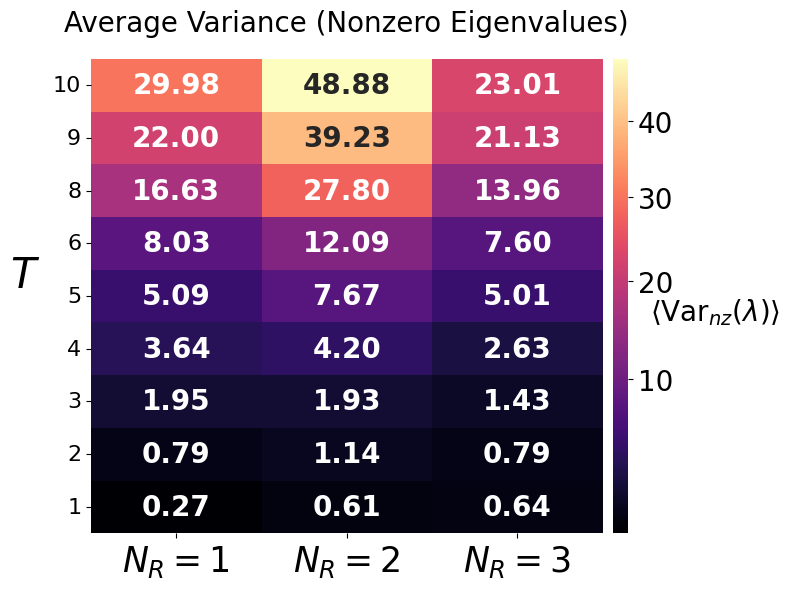

Descr: 


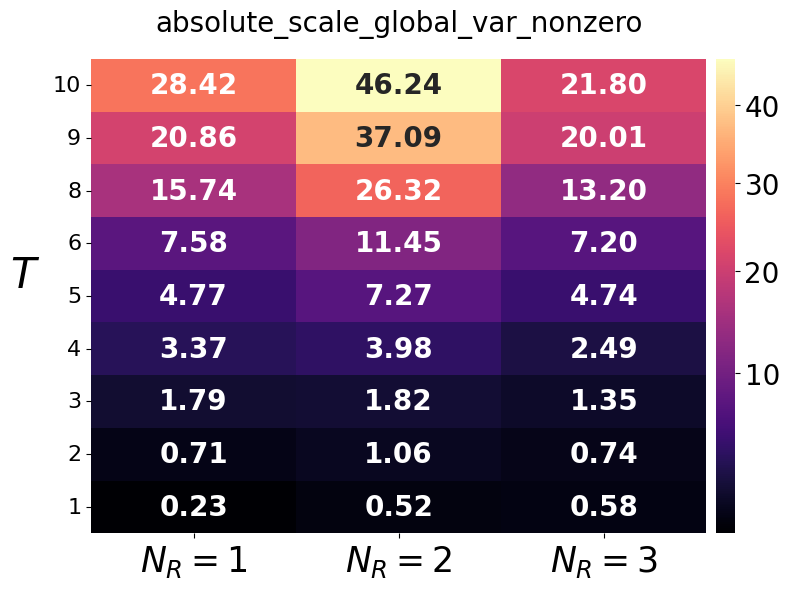

Descr: 


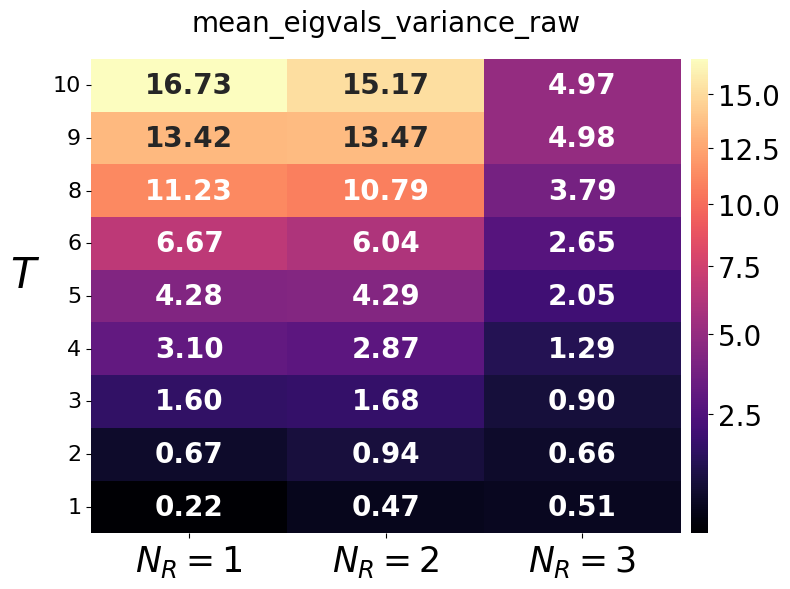

Descr: 


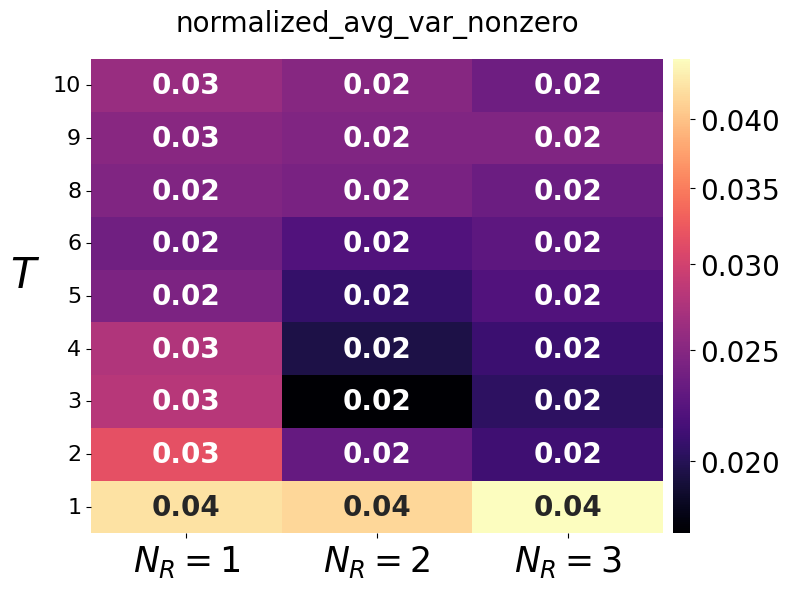

Descr: 


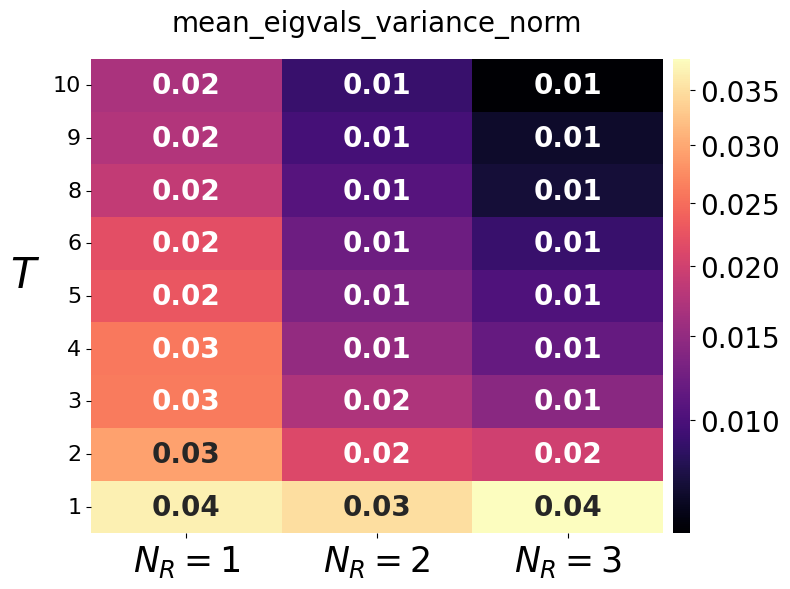

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import PowerNorm
chosen_n_ctrl=2
N_ctrl = chosen_n_ctrl
def plot_qfim_metrics_heatmaps(df_all, N_ctrl, metric_keys, metrics_info, resies=None):
    """
    Generates heatmaps for multiple metrics specified in 'metric_keys' 
    using the definitions/titles in 'metrics_info'.

    - df_all: your main DataFrame.
    - N_ctrl: the control-qubit dimension you're focusing on (int).
    - metric_keys: list of column names in df_all that you want to plot.
    - metrics_info: dict with metadata for each metric_key
    - resies: list of reservoir-qubit counts you want on the x-axis 
      (defaults to [1,2,3,4] or whatever you specify).
    """

    # 1) Default reservoir list if none provided
    if resies is None:
        resies = [1, 2, 3]

    # 2) Decide how to pick Trotter steps based on N_ctrl
    if N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6]
    elif N_ctrl == 3:
        trots = np.arange(1, 60, 1)  # or your preferred range
    else:
        # trots = [1, 2, 3, 4, 5, 6, 8, 9, 10,11, 12,13, 14, 16, 18, 20]
        trots = [1, 2, 3, 4, 5, 6, 8, 9, 10]

    # 3) Single filter step for this N_ctrl, reservoir set, and Trotter steps
    df_filtered = df_all.query("N_ctrl == @N_ctrl").copy()
    df_filtered = df_filtered[df_filtered["N_reserv"].isin(resies)]
    df_filtered = df_filtered[df_filtered["Trotter_Step"].isin(trots)]

    # 4) Loop over each metric you want to plot
    for metric_key in metric_keys:
        if metric_key not in df_filtered.columns:
            print(f"Warning: '{metric_key}' not in df_filtered columns.")
            continue

        # Retrieve title & color bar label from your dictionary

        metric_title = metrics_info.get(metric_key, {}).get('title', metric_key)
        metric_cbar  = metrics_info.get(metric_key, {}).get('label', '')
        metric_descr  = metrics_info.get(metric_key, {}).get('description', '')
        print(f"Descr: {metric_descr}")

        # 4a) Pivot the data for a heatmap
        df_heatmap = (
            df_filtered[["N_reserv", "Trotter_Step", metric_key]]
            .groupby(["Trotter_Step", "N_reserv"])[metric_key]
            .mean()  # or .median(), .max() etc. if desired
            .reset_index()
        )
        heatmap_pivot = df_heatmap.pivot(index="Trotter_Step", columns="N_reserv", values=metric_key)

        # 4b) Compute min/max for color normalization
        min_val = heatmap_pivot.min().min()
        max_val = heatmap_pivot.max().max()

        # 4c) Create formatted annotations
        # D_C: integer ranks, so show 0 decimal places
        if metric_key == "D_C":
            annotation_matrix = heatmap_pivot.map(lambda x: f"{x:.0f}")
        else:
            annotation_matrix = heatmap_pivot.map(lambda x: f"{x:.2f}")

        # 5) Plotting
        fig, ax = plt.subplots(figsize=(8, 6))

        # Create a divider to place colorbar alongside the heatmap
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.1)

        # Example: use a power-law normalization
        sns.heatmap(
            heatmap_pivot,
            annot=annotation_matrix, fmt="",  # fmt="" so we use our own annotated strings
            ax=ax, cbar_ax=cax, cmap="magma",
            annot_kws={"weight": "bold", "size": 20},
            norm=PowerNorm(gamma=0.7, vmin=min_val, vmax=max_val)
        )

        # Invert y-axis so T=1 is at the top
        ax.invert_yaxis()

        # Configure colorbar
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label(metric_cbar, rotation=0, labelpad=30, fontsize=20)

        # Title & labels
        ax.set_title(metric_title, fontsize=20, pad=20)
        ax.set_ylabel('$T$', labelpad=20, fontsize=30, rotation=0)
        ax.set_xlabel("", fontsize=20)
        ax.tick_params(axis='y', labelrotation=0, labelsize=16)
        ax.tick_params(axis='x', labelsize=16)

        # Format x-tick labels
        xticklabels = [f'$N_R = {int(col)}$' for col in heatmap_pivot.columns]
        ax.set_xticklabels(xticklabels, fontweight="bold", fontsize=25, rotation=0)

        plt.tight_layout()
        plt.show()

metric_keys = ['D_C',"spectrum_shape_avg_ipr_deffs_norm",'spectrum_shape_avg_abbas_deffs_norm','avg_abbas_deffs_raw', 'spread_mean_per_sample_variance_normal', 'spread_mean_per_sample_mad_normal']
# metric_keys = ['absolute_scale_avg_var_nonzero','avg_per_active_mode_avg_var_norm_rank','spread_mean_per_sample_variance_normal']
metric_keys = ['D_C',"spread_mean_per_sample_variance_normal","spread_normalized_variance_normal","spread_normalized_variance_1.0"]
metric_keys = ["absolute_scale_avg_var_nonzero","absolute_scale_global_var_nonzero","mean_eigvals_variance_raw","normalized_avg_var_nonzero","mean_eigvals_variance_norm"]
# 'spectrum_shape_ipr_deffs_norm_per_draw',
#        'spectrum_shape_avg_ipr_deffs_norm',
#        'spectrum_shape_abbas_deffs_norm_per_draw',
#        'spectrum_shape_avg_abbas_deffs_norm',
plot_qfim_metrics_heatmaps(df_with_stats, N_ctrl=chosen_n_ctrl, metric_keys=metric_keys, metrics_info=metrics_info, resies=[1,2,3,4])

Descr: The mean variance computed over only the nonzero eigenvalues across draws, measuring the typical dispersion among the significant eigenvalues.


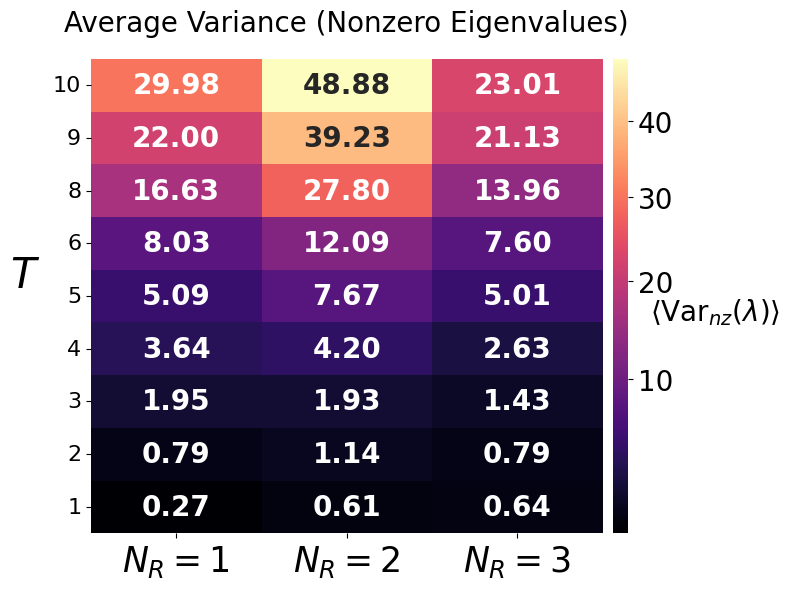

Descr: 


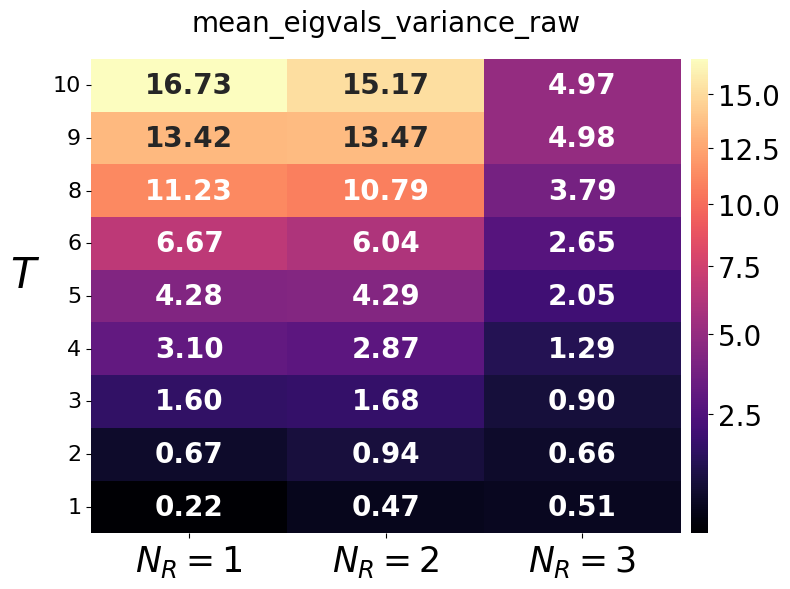

Descr: 


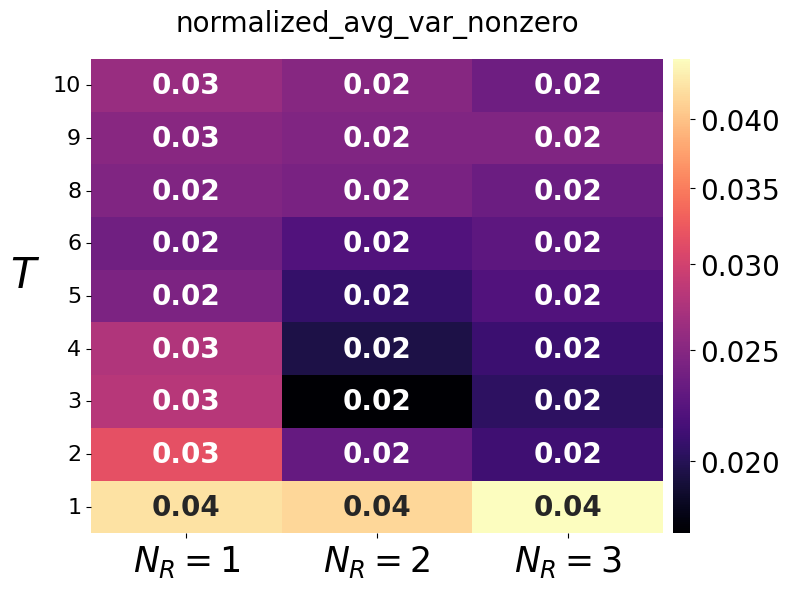

Descr: 


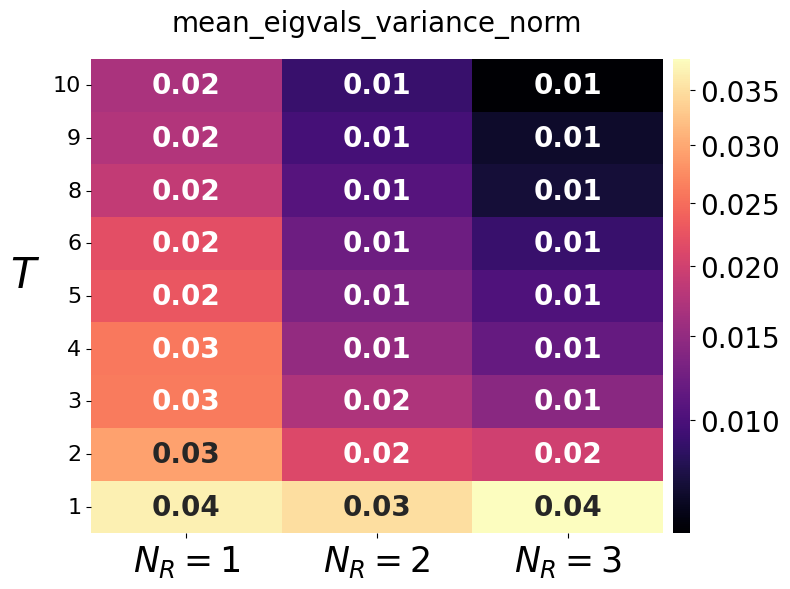

In [28]:
metric_keys = ["absolute_scale_avg_var_nonzero","mean_eigvals_variance_raw","normalized_avg_var_nonzero","mean_eigvals_variance_norm"]
plot_qfim_metrics_heatmaps(df_with_stats, N_ctrl=chosen_n_ctrl, metric_keys=metric_keys, metrics_info=metrics_info, resies=[1,2,3,4])

Descr: 


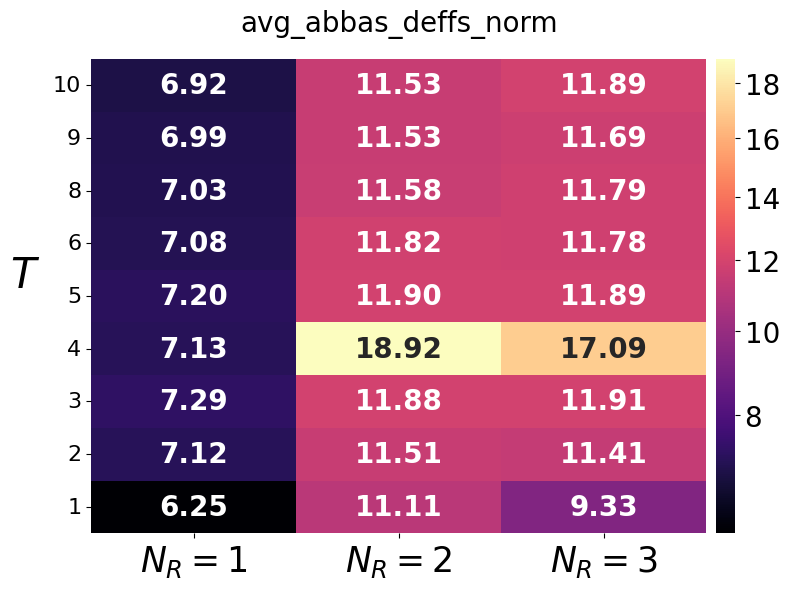

Descr: 


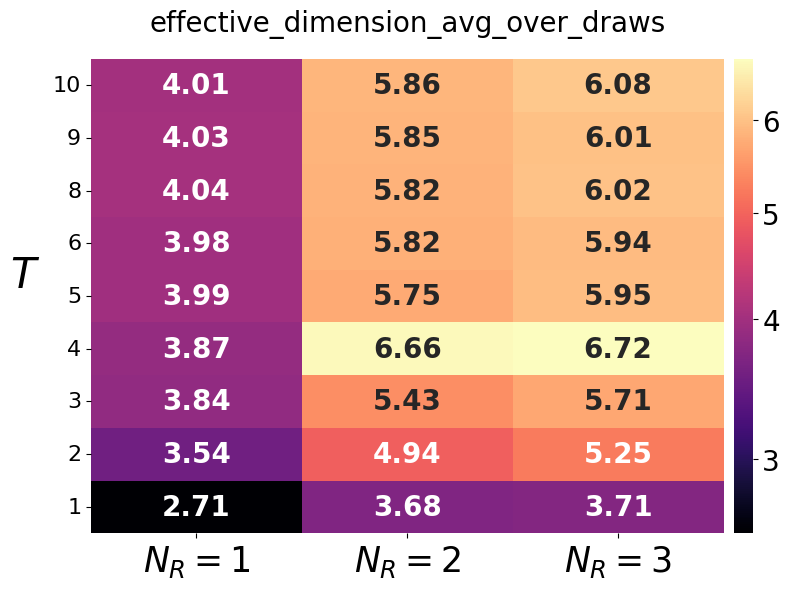

Descr: 


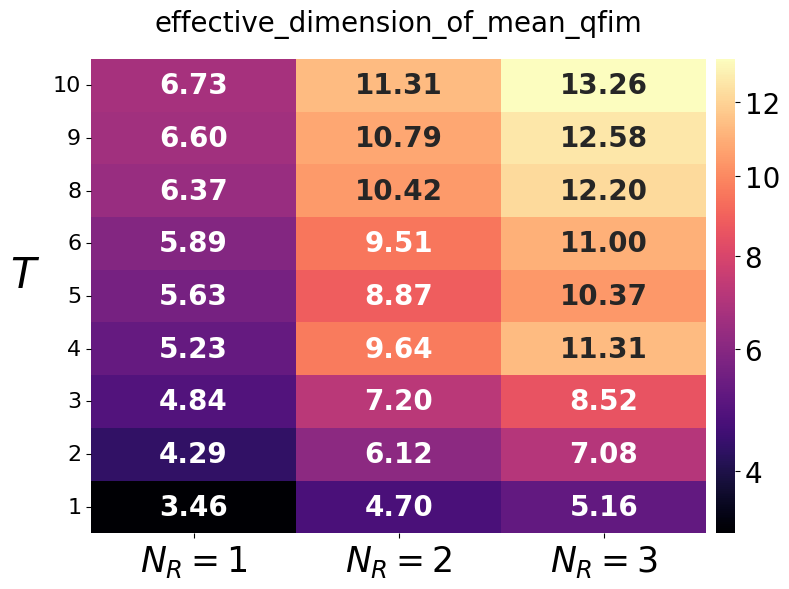

In [35]:
metric_keys = [  'avg_abbas_deffs_norm', 'effective_dimension_avg_over_draws',
       'effective_dimension_of_mean_qfim',]
plot_qfim_metrics_heatmaps(df_with_stats, N_ctrl=chosen_n_ctrl, metric_keys=metric_keys, metrics_info=metrics_info, resies=[1,2,3,4])

[9, 15, 21, 27, 33, 39, 51, 57, 63, 75]
(1, 2, 3, 4, 5, 6, 8, 9, 10, 12)
[INFO] For N_ctrl=2, N_reserv=3, Detected critical T_C = 2 where M = 15
[INFO] For N_ctrl=2, N_reserv=3, peak T_C is 1

[INFO] For N_ctrl=2, N_reserv=3, peak T_C is 2



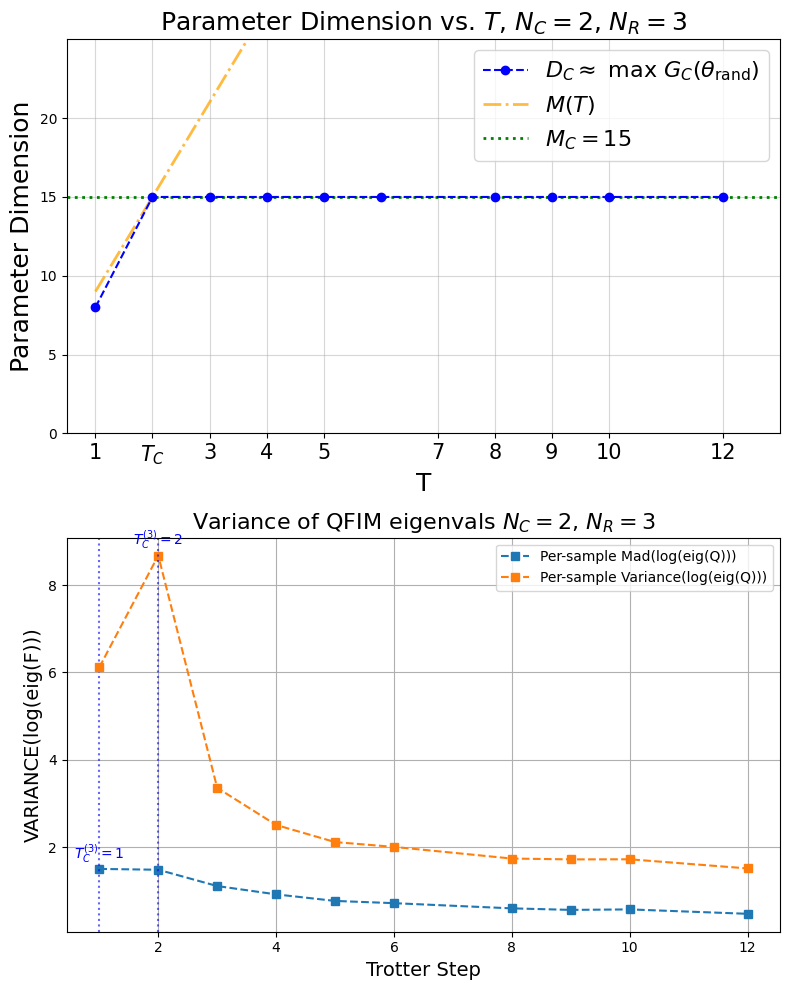

In [20]:
def plot_spread_analysis(df, chosen_n_ctrl, chosen_n_reserv, ax=None,
                         spread_type="variance", combination="sampled",
                         show_yerr=False, title=None, xlabel="Trotter Step",
                         ylabel=None, num_ticks=6, scale='normal'):
    """
    Plots the spread analysis based on the given spread type and combination technique,
    *with* an annotated T_C vertical line (T_C^{(N_R)}).
    
    Parameters:
    -----------
    - df: DataFrame containing spread data.
    - chosen_n_ctrl: Selected N_ctrl value.
    - chosen_n_reserv: Selected N_reserv value.
    - ax: Matplotlib axis to plot on (default: creates new figure).
    - spread_type: 'variance' or 'mad'.
    - combination: 'pooled' or 'sampled'.
    - show_yerr: Whether to plot error bars (for sample-based only).
    - title: Title of the plot.
    - xlabel, ylabel: Axis labels.
    - num_ticks: number of x-ticks to generate.
    - scale: 'normal', etc., to match your naming in df columns.
    """

    # Ensure valid inputs
    if spread_type not in ["variance", "mad"]:
        raise ValueError("spread_type must be 'variance' or 'mad'")
    if combination not in ["pooled", "sampled"]:
        raise ValueError("combination must be 'pooled' or 'sampled'")

    # Filter data for the chosen N_ctrl, N_reserv
    df_plot = df.query("N_ctrl==@chosen_n_ctrl & N_reserv==@chosen_n_reserv").copy()
    df_plot.sort_values("Trotter_Step", inplace=True)

    # Extract x values
    x_vals = df_plot["Trotter_Step"].values

    # Column names for y-values
    y_mean_key = f"spread_mean_per_sample_{spread_type}_{scale}"
    y_std_key  = f"spread_std_per_sample_{spread_type}_{scale}"
    # y_pool_key = f"spread_val_pooled_{spread_type}_{scale}"

    y_mean, y_std = (
        df_plot[y_mean_key].values,
        df_plot[y_std_key].values,
        # df_plot[y_pool_key].values
    )

    # Decide which array to use for peak detection & plotting
    if combination == "sampled":
        data_for_peak = y_mean
        data_label = f"Per-sample {spread_type.capitalize()}(log(eig(Q)))"
    else:  # "pooled"
        data_for_peak = y_pool
        data_label = f"Pooled {spread_type.capitalize()}(log(eig(Q)))"

    # Identify peak (T_C)
    peak_idx = int(np.argmax(data_for_peak))
    peak_T   = x_vals[peak_idx]
    peak_val = data_for_peak[peak_idx]
    print(f"[INFO] For N_ctrl={chosen_n_ctrl}, N_reserv={chosen_n_reserv}, "
          f"peak T_C is {peak_T}\n")

    # Create plot if no axis is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Actually plot
    if combination == "sampled":
        if show_yerr:
            ax.errorbar(
                x_vals, y_mean, yerr=y_std, fmt="o--",
                capsize=4, label=f"{data_label} ± std"
            )
        else:
            ax.plot(
                x_vals, y_mean, "s--", label=data_label
            )
    else:  # combination == "pooled"
        ax.plot(x_vals, y_pool, "s--", label=data_label)

    # Construct x-ticks, ensuring T=1 and T_C are included
    # x_ticks = np.linspace(min(x_vals), max(x_vals), num=num_ticks, dtype=int)
    # x_ticks = np.unique(np.append(x_ticks, [1, peak_T]))  # ensure T=1 & T_C

    # # Label T_C explicitly on x-axis
    # xtick_labels = [f"$T_C$" if tick == peak_T else str(tick) for tick in x_ticks]
    # ax.set_xticks(x_ticks)
    # ax.set_xticklabels(xtick_labels, fontsize=15)

    # 2) Annotate T_C with a vertical line plus a text label T_C^{(N_reserv)}
    ax.axvline(x=peak_T, color='b', linestyle=':', alpha=0.6)
    ax.text(
        peak_T, peak_val + 0.1,
        fr"$T_C^{{({chosen_n_reserv})}}={peak_T}$",
        fontsize=10, color='b',
        ha='center', va='bottom'
    )

    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel or f"{spread_type.upper()}(log(eig(F)))", fontsize=14)
    if not title:
        title=f'Variance of QFIM eigenvals $N_C = {chosen_n_ctrl}$, $N_R = {chosen_n_reserv}$'
    ax.set_title(title or f"{spread_type.capitalize()}-based Spread Analysis", fontsize=16)
    ax.grid(True)
    ax.legend()

    return ax

def get_num_params(N_r, N_c, T, model_type = 'digital'):
        if model_type == 'analog':
            return N_r * N_c * T + 3 + T
        elif model_type == 'digital':
            return N_r * N_c * T + 3
        else:
             raise TypeError(f'No model type: {model_type}')
def plot_max_rank_vs_params(df, chosen_n_ctrl, chosen_n_reserv, ax=None,
                            xlabel='T', ylabel='Parameter Dimension', title=None,
                            color='b', param_color='orange', critical_color='green',
                            legend_loc='upper right',num_ticks=10):
    """
    Plots max rank vs. parameters for given control and reservoir values.

    Parameters:
    - df: DataFrame containing 'Trotter_Step', 'N_ctrl', 'N_reserv', 'QFIM_ranks'.
    - chosen_n_ctrl: Selected control value for filtering.
    - chosen_n_reserv: Selected reservoir value for filtering.
    - ax: Matplotlib axis to plot on (default: creates new figure).
    - xlabel, ylabel: Axis labels.
    - title: Title of the plot.
    - color: Color for max rank plot line.
    - param_color: Color for parameter dimension line.
    - critical_color: Color for the critical threshold line.
    - legend_loc: Legend location.
    """
    
    # Filter for chosen values
    subset = df[(df['N_ctrl'] == chosen_n_ctrl) & (df['N_reserv'] == chosen_n_reserv)]
    
    trotter_steps, max_ranks = [], []
    for T_step, grp in subset.groupby('Trotter_Step'):
        all_ranks = [rank for row in grp['QFIM_ranks'] for rank in row]
        max_rank = np.max(all_ranks) if all_ranks else 0
        trotter_steps.append(T_step)
        max_ranks.append(max_rank)

    # Sort data
    trotter_steps, max_ranks = zip(*sorted(zip(trotter_steps, max_ranks)))

    # Compute parameter dimension M(T)
    # param_list = [get_num_params(chosen_n_reserv, chosen_n_ctrl, t, model_type="digital") for t in trotter_steps]
    param_list = [get_num_params(chosen_n_reserv, chosen_n_ctrl, t, model_type="digital") for t in trotter_steps]
    print(param_list)
    print(trotter_steps)
    # Detect critical T_C
    idx_C = int(np.argmax(max_ranks))
    T_C, M_C, D_C = trotter_steps[idx_C], param_list[idx_C], max_ranks[idx_C]
    print(f"[INFO] For N_ctrl={chosen_n_ctrl}, N_reserv={chosen_n_reserv}, Detected critical T_C = {T_C} where M = {M_C}")
    # Create plot if no axis is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Plot max rank vs. Trotter step
    ax.plot(trotter_steps, max_ranks, marker='o', linestyle='--', color=color,
            label=r'$D_C \approx$ max $G_C(\theta_{\text{rand}})$', zorder=10)
    
    # Plot M(T)
    ax.plot(trotter_steps, param_list, color=param_color, linestyle='-.',
            alpha=0.75, linewidth=2, label='$M(T)$')
    
    # Horizontal line at M_C
    ax.axhline(y=M_C, color=critical_color, linestyle=':', linewidth=2, label=f'$M_C={M_C}$')

    # X-axis ticks: evenly spaced, always including T=1 and T_C
    x_ticks = np.linspace(min(trotter_steps), max(trotter_steps), num=num_ticks, dtype=int)
    x_ticks = np.unique(np.append(x_ticks, [1, T_C]))  # Ensure T=1 and T_C are always included

    # Labeling T_C explicitly
    xtick_labels = [f"$T_C$" if tick == T_C else str(tick) for tick in x_ticks]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(xtick_labels, fontsize=15)
    


    # Y-axis: Ensure labels are integers
    yticks = list(np.arange(0, max(max_ranks) + 10, step=5))
    if M_C not in yticks:
        yticks.append(M_C)
    
    ax.set_yticks(yticks)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))

    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.legend(fontsize=16, loc=legend_loc)
    ax.grid(True, alpha=0.5)
    ax.set_ylim(top=M_C + 10)
    ax.set_xlim(left=0.5, right=max(trotter_steps)+1)
    if not title:
        title=f'Parameter Dimension vs. $T$, $N_C = {chosen_n_ctrl}$, $N_R = {chosen_n_reserv}$'
    if title:
        ax.set_title(title, fontsize=18)

    return ax
chosen_n_reserv = 3
chosen_n_ctrl = 2
selected_T_plot = np.arange(1,11,1)
df_filtered = df_with_stats[df_with_stats['Trotter_Step'].isin(selected_T_plot)]
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
plot_max_rank_vs_params(df_with_stats, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv, ax=axes[0])
plot_spread_analysis(df_with_stats, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv, spread_type="mad", combination="sampled", scale='1.0',ax=axes[1])
plot_spread_analysis(df_with_stats, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv, spread_type="variance", combination="sampled", scale='normal',ax=axes[1])
# plot_spread_analysis(df_with_stats, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv, spread_type="variance", combination="sampled",scale=1.0, ax=axes[1])

plt.tight_layout()
plt.show()

[5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43]
(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20)
[INFO] For N_ctrl=2, N_reserv=1, Detected critical T_C = 6 where M = 15
[INFO] For N_ctrl=2, N_reserv=1, peak T_C is 6

[7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 51]
(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12)
[INFO] For N_ctrl=2, N_reserv=2, Detected critical T_C = 3 where M = 15
[INFO] For N_ctrl=2, N_reserv=2, peak T_C is 3

[9, 15, 21, 27, 33, 39, 51, 57, 63, 75]
(1, 2, 3, 4, 5, 6, 8, 9, 10, 12)
[INFO] For N_ctrl=2, N_reserv=3, Detected critical T_C = 2 where M = 15
[INFO] For N_ctrl=2, N_reserv=3, peak T_C is 2



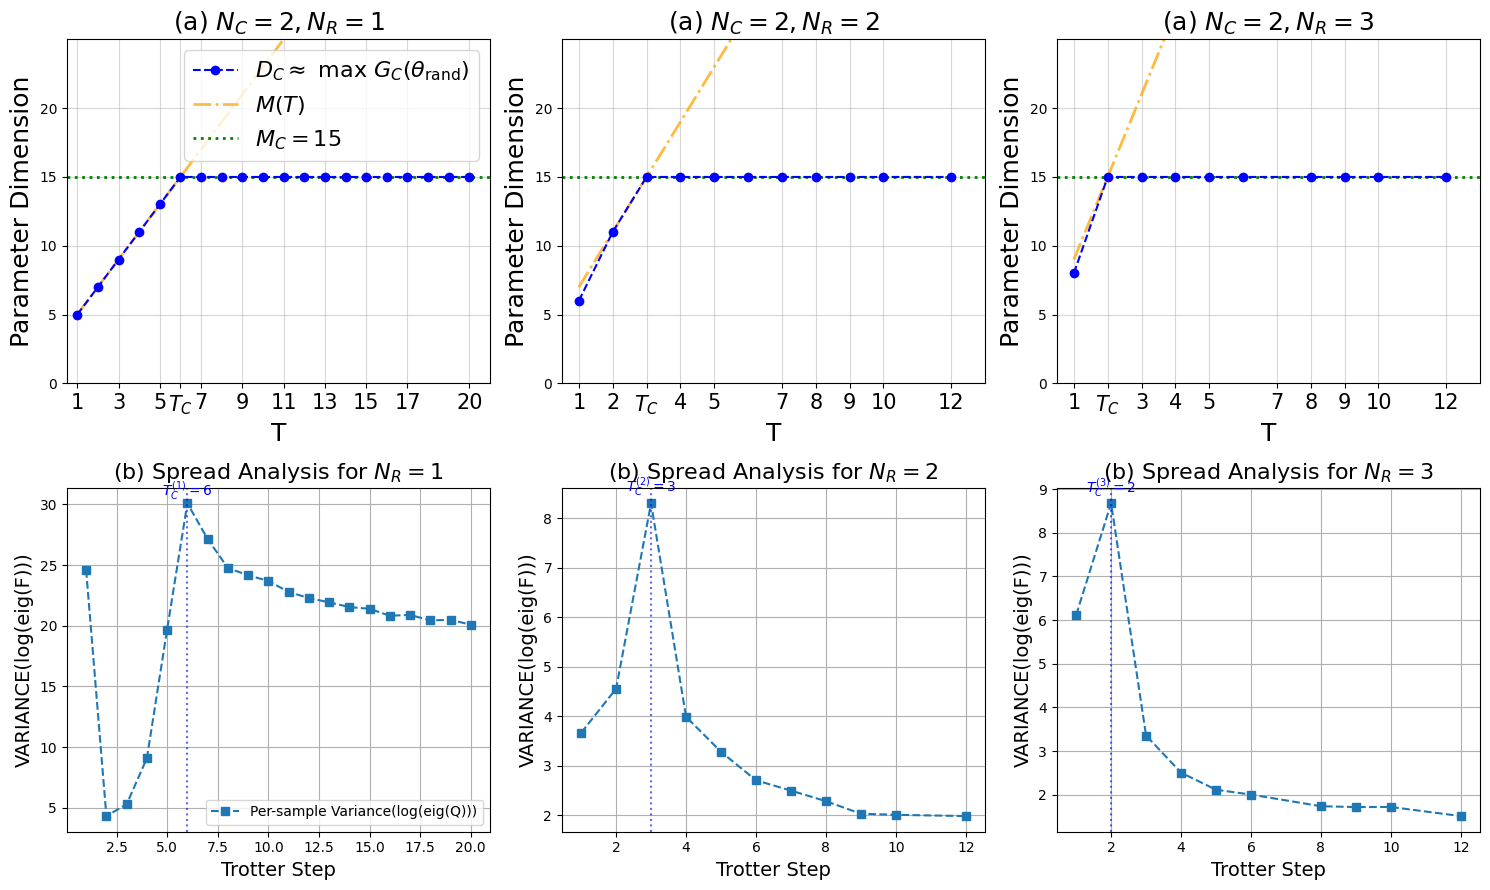

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_many_reserv(df, N_ctrl=2, reserv_list=[1, 2, 3], spread_type="mad"):
    """
    Creates a 2xN grid of subplots, with the top row showing plot_max_rank_vs_params
    and the bottom row showing plot_spread_analysis, each column for a different N_R.

    Parameters:
    -----------
    df : pd.DataFrame
        The dataframe containing your QFIM info (with 'N_ctrl','N_reserv','Trotter_Step', etc.).
    N_ctrl : int
        The control qubit count to fix for all columns.
    reserv_list : list of int
        The distinct N_reserv values you want to show (e.g. [1, 2, 3]).
    spread_type : str
        'variance' or 'mad', as accepted by your plot_spread_analysis function.

    Returns:
    --------
    fig, axes : The figure and axes objects for further customization.
    """

    # Number of columns is the length of reserv_list
    ncols = len(reserv_list)
    fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(5*ncols, 9), sharex=False, sharey=False)

    # If there is only 1 column, make sure we index axes as 2D
    if ncols == 1:
        # shape would be (2, ) if there's only one column
        axes = np.array([axes]).T  # transform to shape (2,1)

    for col_idx, nr_val in enumerate(reserv_list):
        # ------------------
        # Top row: max-rank vs. T
        # ------------------
        ax_top = axes[0, col_idx]
        plot_max_rank_vs_params(
            df, chosen_n_ctrl=N_ctrl, chosen_n_reserv=nr_val, ax=ax_top,
            xlabel="T", ylabel="Parameter Dimension",
            title=f"(a) $N_C={N_ctrl}, N_R={nr_val}$"
        )

        # Hide repeated legends if you only want them once:
        if col_idx > 0:
            ax_top.legend_.remove()

        # ------------------
        # Bottom row: spread analysis
        # ------------------
        ax_bot = axes[1, col_idx]
        plot_spread_analysis(
            df, chosen_n_ctrl=N_ctrl, chosen_n_reserv=nr_val,
            ax=ax_bot, spread_type=spread_type, combination="sampled",
            xlabel="Trotter Step", ylabel=f"{spread_type.upper()}(log(eig(F)))",
            title=f"(b) Spread Analysis for $N_R={nr_val}$"
        )

        if col_idx > 0:
            # Similarly remove legends if you want minimal duplication
            # Or keep them if you prefer each subplot to have its own
            ax_bot.legend_.remove()

    plt.tight_layout()
    return fig, axes

# Example usage:
fig, axes = plot_many_reserv(df_with_stats, N_ctrl=2, reserv_list=[1,2,3], spread_type="variance")
# plt.show()

In [18]:
import numpy.ma as ma
def compute_all_stats(
    eigval_list,
    threshold=1e-12,
    spread_methods=("variance", "mad"),  # e.g. ["variance", "mad"]
    ddof=1,
    scale="normal",
    qfim_mats_list=None,   
    dataset_sizes=None,    
    n=1,                   # overshadowed in the old code, kept for signature
    n_ctrl=None,
    n_reserv=None,
    trotter_step=None,
):
    """
    Vectorized version of stats computations over 'eigval_list' (shape [n_draws, M]).
    We remove the explicit Python for-loop for IPR, raw Abbas dimension, etc.
    and rely on NumPy's built-in array operations.

    Parameters
    ----------
    eigval_list : list of lists (or 2D array)
        Each row is the set of eigenvalues for one QFIM draw. shape [n_draws, M].
    threshold : float
        Zero out or mask any eigenvalues below this threshold.
    spread_methods : tuple
        e.g. ("variance", "mad"). Passed to your 'spread_per_sample_vectorized' function.
    ddof : int
        Degrees of freedom for variance computations.
    scale : str
        Scale for median_abs_deviation if "mad" is used.
    qfim_mats_list : list of 2D arrays (or None)
        If provided, we compute the 'effective_dimension' from these full QFIM matrices
        using a partial loop (because standard NumPy lacks batch diagonalization).
    dataset_sizes : int or list of int, optional
        For Qiskit’s global ED or advanced dimension approaches. Not used here.
    n : int
        Overridden in the code below, but kept for signature consistency.
    n_ctrl, n_reserv, trotter_step : optional
        Additional metadata.

    Returns
    -------
    metrics : dict
        A dictionary with the computed statistics:
         - Ranks, var, trace
         - IPR-based dimension (raw, normalized)
         - Abbas-based dimension (raw, normalized)
         - 'effective_dimension' from the full QFIMs in qfim_mats_list
         - etc.
    """

    # 1) Convert eigval_list -> 2D array arr of shape [n_draws, M]
    arr = np.array(eigval_list, dtype=float)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    # Zero out near-zero eigenvalues
    arr = np.where(arr < threshold, 0.0, arr)

    n_draws, M = arr.shape

    # 2) Basic stats: rank, var, trace, etc. (vectorized)
    ranks_per_draw = np.count_nonzero(arr, axis=1)            # rank = # of nonzero
    var_all_per_draw = np.var(arr, axis=1, ddof=ddof)         # var of each row
    trace_per_draw = np.sum(arr, axis=1)                      # sum (trace) of each row

    # variance of nonzero subset => masked arrays
    masked = ma.masked_where(arr <= 0.0, arr)
    var_nonzero_ma = ma.var(masked, axis=1, ddof=ddof)
    var_nonzero_per_draw = var_nonzero_ma.filled(0.0)

    # rank-based average (var, trace)
    var_norm_rank_per_draw = np.where(ranks_per_draw > 0,
                                      var_all_per_draw / ranks_per_draw,
                                      0.0)
    trace_norm_rank_per_draw = np.where(ranks_per_draw > 0,
                                        trace_per_draw / ranks_per_draw,
                                        0.0)

    # 3) IPR-based dimension
    sum_of_squares = np.sum(arr**2, axis=1)
    ipr_raw_per_draw = np.divide(trace_per_draw**2, sum_of_squares,
                                 out=np.zeros_like(trace_per_draw),
                                 where=(sum_of_squares>0))

    # IPR (normalized)
    trace_mask = (trace_per_draw>0)
    arr_norm = np.zeros_like(arr)
    arr_norm[trace_mask] = arr[trace_mask] / trace_per_draw[trace_mask, np.newaxis]
    sum_norm_sq = np.sum(arr_norm**2, axis=1)
    ipr_norm_per_draw = np.divide(1.0, sum_norm_sq,
                                  out=np.zeros_like(sum_norm_sq),
                                  where=(sum_norm_sq>0))

    # 4) Abbas-based dimension (raw, normalized)
    # alpha = (gamma * n_draws) / (2 ln(n_draws)) in your code
    gamma = 1.0
    if n_draws>1:
        alpha = (gamma * n_draws) / (2.0 * np.log(n_draws))
    else:
        alpha = 0.0

    # raw => sum of log(1 + alpha*lam)
    val = 1.0 + alpha * arr
    val[val<=0] = 1e-15
    abbas_raw_per_draw = np.sum(np.log(val), axis=1)

    # normalized => sum of log(1 + alpha*(lam/trace)), row by row
    val_norm = 1.0 + alpha * arr_norm
    val_norm[val_norm<=0] = 1e-15
    abbas_norm_per_draw = np.sum(np.log(val_norm), axis=1)

    # 5) Aggregation across draws
    D_C = ranks_per_draw.max() if len(ranks_per_draw)>0 else 0

    avg_var_all = float(var_all_per_draw.mean()) if var_all_per_draw.size>0 else 0.0
    avg_trace   = float(trace_per_draw.mean())   if trace_per_draw.size>0   else 0.0
    avg_var_nonzero = float(var_nonzero_per_draw.mean()) if var_nonzero_per_draw.size>0 else 0.0
    avg_var_norm_rank   = float(var_norm_rank_per_draw.mean())   if var_norm_rank_per_draw.size>0   else 0.0
    avg_trace_norm_rank = float(trace_norm_rank_per_draw.mean()) if trace_norm_rank_per_draw.size>0 else 0.0

    var_var_all     = float(np.var(var_all_per_draw)) if var_all_per_draw.size>1 else 0.0
    var_var_nonzero = float(np.var(var_nonzero_per_draw)) if var_nonzero_per_draw.size>1 else 0.0

    avg_ipr_raw  = float(ipr_raw_per_draw.mean())  if ipr_raw_per_draw.size>0  else 0.0
    avg_ipr_norm = float(ipr_norm_per_draw.mean()) if ipr_norm_per_draw.size>0 else 0.0
    avg_abbas_raw = float(abbas_raw_per_draw.mean()) if abbas_raw_per_draw.size>0 else 0.0
    avg_abbas_norm= float(abbas_norm_per_draw.mean()) if abbas_norm_per_draw.size>0 else 0.0

    # 6) Spread-of-log calculations (unchanged from your snippet, but vectorizable if you want)
    arr_2d = arr.copy()  # shape [n_draws, M]
    spread_results = {}
    for method in spread_methods:
        per_draw = spread_per_sample_vectorized(
            arr_2d,
            method=method,
            threshold=threshold,
            ddof=ddof,
            scale=scale,
            n_ctrl=n_ctrl,
            n_reserv=n_reserv,
            trotter_step=trotter_step,
        )
        # per_draw = spread_per_sample_vectorized(arr_2d, method=method,
        #                                         threshold=threshold, ddof=ddof, scale=scale)
        spread_mean = float(per_draw.mean()) if per_draw.size>0 else 0.0
        spread_std  = float(per_draw.std())  if per_draw.size>1 else 0.0
        pooled_val  = float(spread_pooling_vectorized(arr_2d, method=method,
                                                      threshold=threshold, ddof=ddof, scale=scale))
        prefix = method.lower()
        spread_results[f"spread_mean_per_sample_{prefix}_{scale}"] = spread_mean
        spread_results[f"spread_std_per_sample_{prefix}_{scale}"]  = spread_std
        spread_results[f"spread_val_pooled_{prefix}_{scale}"]      = pooled_val
    # print(f"num of trainable params: {len(eigval_list[0])}")
    for method in spread_methods:
        per_draw_nolog = spread_per_sample_vectorized_nolog(
            arr_2d,
            method=method,
            threshold=threshold,
            ddof=ddof,
            scale=scale,
            n_ctrl=n_ctrl,
            n_reserv=n_reserv,
            trotter_step=trotter_step,
        )
        spread_results[f"spread_metric_{method}_nolog"] = per_draw_nolog[0] if per_draw_nolog.size > 0 else 0.0

    # 7) 'effective_dimension' from the QFIMs in qfim_mats_list
    #    Because standard NumPy doesn't have a batch eigvalsh, we keep a small loop
    effective_dim = 0.0
    if qfim_mats_list is not None:
        qfim_mats_array = np.array(qfim_mats_list, dtype=float)
        z_values = []
        for F_theta in qfim_mats_array:
            trF = np.trace(F_theta)
         
            F_hat = F_theta / trF
            eigs_F = np.linalg.eigvalsh(F_hat)
            eps = 1e-12
            z = 0.5 * np.sum(np.log(1.0 + n_draws * eigs_F + eps))
            z_values.append(z)
        z_values = np.array(z_values)
        if z_values.size > 0:
            z_max = z_values.max()
            avg_exp_z = np.mean(np.exp(z_values - z_max))
            log_avg = np.log(avg_exp_z) + z_max
            effective_dim = (2.0 / np.log(n_draws)) * log_avg

    # 8) Build final dictionary
    metrics = {
        # Per-draw lists
        "QFIM_ranks": ranks_per_draw,
        "var_all_eigenvals_per_draw": var_all_per_draw,
        "var_nonzero_eigenvals_per_draw": var_nonzero_per_draw,
        "trace_eigenvals_per_draw": trace_per_draw,

        # Aggregates
        "D_C": D_C,
        "absolute_scale_avg_var_all": avg_var_all,
        "absolute_scale_avg_var_nonzero": avg_var_nonzero,
        "absolute_scale_avg_trace": avg_trace,
        "absolute_scale_var_of_var_all": var_var_all,
        "absolute_scale_var_of_var_nonzero": var_var_nonzero,

        "avg_per_active_mode_var_norm_rank_per_draw": var_norm_rank_per_draw,
        "avg_per_active_mode_trace_norm_rank_per_draw": trace_norm_rank_per_draw,
        "avg_per_active_mode_avg_var_norm_rank": avg_var_norm_rank,
        "avg_per_active_mode_avg_trace_norm_rank": avg_trace_norm_rank,

        # IPR draws & means
        "ipr_deffs_raw_per_draw": ipr_raw_per_draw,
        "spectrum_shape_avg_ipr_deffs_raw": avg_ipr_raw,
        "ipr_deffs_norm_per_draw": ipr_norm_per_draw,
        "spectrum_shape_avg_ipr_deffs_norm": avg_ipr_norm,

        # Abbas draws & means
        "abbas_deffs_raw_per_draw": abbas_raw_per_draw,
        "avg_abbas_deffs_raw": avg_abbas_raw,
        "abbas_deffs_norm_per_draw": abbas_norm_per_draw,
        "avg_abbas_deffs_norm": avg_abbas_norm,

        # Effective dimension from QFIMs
        "effective_dimension": effective_dim,
    }
    metrics.update(spread_results)
    return metrics


#############################################
#   BUILD_QFIM_DATAFRAME (wrapper function) #
#############################################
def build_qfim_dataframe(df_all, threshold=1e-12):
    """
    1) Convert all_qfim_eigvals -> qfim_eigs_2d
    2) Single-pass stats => expanded columns (including spread-of-log)
    3) Optionally, extra 'compute_spread_columns' calls 
       if you want separate columns for 'median', etc.
    4) Return final df_all with everything included.
    """
    # 1) Convert for convenience
    df_all["qfim_eigs_2d"] = df_all["all_qfim_eigvals"].apply(to_2d)

    # 2) Single-pass stats
    stats_series = df_all.apply(
        lambda row: compute_all_stats(
            eigval_list=row["all_qfim_eigvals"],
            threshold=threshold,
            spread_methods=["variance", "mad"],  # You can add "median" if desired
            ddof=0,
            scale="normal",
            qfim_mats_list=row["all_full_qfim_mats"],
            n_ctrl=row["N_ctrl"],
            n_reserv=row["N_reserv"],
            trotter_step=row["Trotter_Step"]
        ),
        axis=1
    )

    # 3) Normalize the resulting series (which is a series of dictionaries)
    df_stats = pd.json_normalize(stats_series)

    # 4) Concatenate the original dataframe with the computed statistics
    df_out = pd.concat([df_all.reset_index(drop=True), df_stats.reset_index(drop=True)], axis=1)
    return df_out
df_with_stats = build_qfim_dataframe(df_all=df_all, threshold=1e-10)
df_with_stats.head()

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_73929/4148927500.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  qfim_mats_array = np.array(qfim_mats_list, dtype=float)


[DEBUG spread] Row 0: method=variance, ddof=0, val_count=8
    raw row (normalized): [0.00000000e+00 3.30305843e-05 5.81089023e-05 4.81732253e-04
 5.49493376e-02 9.98543301e-02 1.21093938e-01 2.81187550e-01
 4.42341973e-01]
    row_nonzero logs: [-10.31807663  -9.75319168  -7.63812209  -2.90134365  -2.30404285
  -2.11118869  -1.26873339  -0.815672  ]
    => spread=13.5299
[DEBUG spread] Row 1: method=variance, ddof=0, val_count=8
    raw row (normalized): [0.00000000e+00 4.36950836e-05 1.10049029e-03 5.82232658e-03
 3.21050789e-02 8.06616526e-02 8.72501961e-02 9.79367381e-02
 6.95079822e-01]
    row_nonzero logs: [-10.03827497  -6.81199948  -5.14605534  -3.43874104  -2.517492
  -2.43897547  -2.32343354  -0.36372859]
    => spread=8.3149
[DEBUG spread] Row 2: method=variance, ddof=0, val_count=8
    raw row (normalized): [0.00000000e+00 1.00398366e-04 1.46955583e-03 2.76230789e-02
 5.34161543e-02 6.09678552e-02 1.06400953e-01 3.31441654e-01
 4.18580351e-01]
    row_nonzero logs: [-9.206

,N_ctrl,N_reserv,Trotter_Step,all_qfim_eigvals,all_full_qfim_mats,mean_entropy,num_test_keys,key_pair_tuple,qfim_eigs_2d,QFIM_ranks,var_all_eigenvals_per_draw,var_nonzero_eigenvals_per_draw,trace_eigenvals_per_draw,D_C,absolute_scale_avg_var_all,absolute_scale_avg_var_nonzero,absolute_scale_avg_trace,absolute_scale_var_of_var_all,absolute_scale_var_of_var_nonzero,avg_per_active_mode_var_norm_rank_per_draw,avg_per_active_mode_trace_norm_rank_per_draw,avg_per_active_mode_avg_var_norm_rank,avg_per_active_mode_avg_trace_norm_rank,ipr_deffs_raw_per_draw,spectrum_shape_avg_ipr_deffs_raw,ipr_deffs_norm_per_draw,spectrum_shape_avg_ipr_deffs_norm,abbas_deffs_raw_per_draw,avg_abbas_deffs_raw,abbas_deffs_norm_per_draw,avg_abbas_deffs_norm,effective_dimension,spread_mean_per_sample_variance_normal,spread_std_per_sample_variance_normal,spread_val_pooled_variance_normal,spread_mean_per_sample_mad_normal,spread_std_per_sample_mad_normal,spread_val_pooled_mad_normal,spread_metric_variance_nolog,spread_metric_mad_nolog
0,2,1,1,"[[4.044978944144145e-05, 0.0001530984610274836...","[[[(1.0000515090138917+0j), (3.799106520992842...",0.555336,100,"[(fixed_params0, test0), (fixed_params0, test1...","[[4.044978944144145e-05, 0.0001530984610274836...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.20019154810992862, 0.10846401734504621, 0.0...","[0.20019154810992862, 0.10846401734504621, 0.0...","[2.500707150262698, 2.21895490593897, 1.880577...",5,0.233867,0.233867,2.419301,0.023628,0.023628,"[0.04003830962198572, 0.02169280346900924, 0.0...","[0.5001414300525396, 0.44379098118779403, 0.37...",0.046773,0.483860,"[2.7772942586297957, 3.224314263486083, 3.3610...",2.746270,"[2.7772942586297957, 3.224314263486083, 3.3610...",2.746270,"[6.808970918050502, 7.355530915050582, 6.98749...",7.107176,"[4.506143880536385, 4.949042630213883, 5.05909...",4.677554,2.590788,19.935203,6.180869,20.276567,1.278944,0.917527,3.626656,0.032013,0.296347
1,2,1,2,"[[0.009481708440169575, 0.020315447000540075, ...","[[[(1.1318866845041362+0j), (-0.28204863605541...",0.580095,100,"[(fixed_params0, test0), (fixed_params0, test1...","[[0.009481708440169575, 0.020315447000540075, ...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[0.7595201904737502, 1.1190232890348197, 0.262...","[0.7595201904737502, 1.1190232890348197, 0.262...","[4.6130777906030875, 5.358389192102195, 3.2901...",7,0.644146,0.644146,4.561915,0.223302,0.223302,"[0.10850288435339288, 0.1598604698621171, 0.03...","[0.6590111129432982, 0.7654841703003136, 0.470...",0.092021,0.651702,"[2.546514657869152, 2.4057406666440877, 3.1997...",3.151978,"[2.5465146578691518, 2.4057406666440877, 3.199...",3.151978,"[10.18325997785571, 11.174775859141185, 9.8605...",11.147769,"[4.779400500374503, 4.858562915646297, 5.25597...",5.208010,3.286920,4.116780,3.179399,4.344265,1.413063,0.551026,1.667824,0.035691,0.074379
2,2,1,3,"[[0.0075758742355789, 0.0657085401062319, 0.13...","[[[(1.3021484662498417+0j), (-0.38691685953482...",0.541307,100,"[(fixed_params0, test0), (fixed_params0, test1...","[[0.0075758742355789, 0.0657085401062319, 0.13...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ...","[1.2434350305446302, 0.4517265121706162, 1.091...","[1.2434350305446302, 0.4517265121706162, 1.091...","[7.204580072080255, 5.002603561807728, 8.13905...",9,1.664301,1.664301,7.583699,1.873010,1.873010,"[0.13815944783829226, 0.05019183468562402, 0.1...","[0.800508896897806, 0.5558448402008587, 0.9043...",0.184922,0.842633,"[3.0608103496633716, 3.655459362824589, 3.8548...",3.207577,"[3.0608103496633716, 3.6554593628245895, 3.854...",3.207577,"[14.439244592185684, 13.462264236417848, 15.37...",14.529013,"[5.230495524475904, 5.66988470286098, 5.535880...",5.306582,3.530892,4.736160,3.238264,4.980723,1.870150,0.578215,2.010903,0.023956,0.035376
3,2,1,4,"[[0.0017181285368676265, 0.015960381436301595,...","[[[(4.015395476023706+0j), (-0.501230143152080...",0.531556,100,"[(fixed_params0, test0), (fixed_params0, test1...","[[0.001

In [19]:
config_df = df_all[(df_all['N_ctrl'] == 2) & (df_all['N_reserv'] == 3)]
print("Number of rows for configuration (N_ctrl=3, N_reserv=1):", config_df.shape[0])
# print(np.array(config_df['all_qfim_eigvals']))
# print(np.array(config_df['all_qfim_eigvals'][1]).shape)
# print(config_df['qfim_eigs_2d'][1].shape)
# Option 1: Check uniqueness within each row.
print("\nChecking uniqueness within each row:")
for idx, row in config_df.iterrows():
    eig_sets = row["all_qfim_eigvals"]
    # Convert each eigenvalue set to a hashable tuple.
    # (Flatten the array, round for stability, and convert to a tuple.)
    eig_tuples = [tuple(np.round(np.array(eig).flatten(), decimals=5)) for eig in eig_sets]
    if len(eig_tuples) == len(set(eig_tuples)):
         print(f"T={row['Trotter_Step']}: All {len(eig_tuples)} eigenvalue sets are unique.  {np.array(eig_sets).shape}")
    else:
         print(f"T={row['Trotter_Step']}: Duplicate eigenvalue sets found! {np.array(eig_sets).shape}")

Number of rows for configuration (N_ctrl=3, N_reserv=1): 8

Checking uniqueness within each row:
T=1: Duplicate eigenvalue sets found! (500, 9)
T=2: All 500 eigenvalue sets are unique.  (500, 15)
T=3: All 500 eigenvalue sets are unique.  (500, 21)
T=4: All 500 eigenvalue sets are unique.  (500, 27)
T=5: All 500 eigenvalue sets are unique.  (500, 33)
T=6: All 500 eigenvalue sets are unique.  (500, 39)
T=7: All 500 eigenvalue sets are unique.  (500, 45)
T=8: All 500 eigenvalue sets are unique.  (500, 51)


In [20]:
print(df_with_stats.columns)

Index(['N_ctrl', 'N_reserv', 'Trotter_Step', 'all_qfim_eigvals',
       'all_full_qfim_mats', 'mean_entropy', 'num_test_keys', 'key_pair_tuple',
       'qfim_eigs_2d', 'QFIM_ranks', 'var_all_eigenvals_per_draw',
       'var_nonzero_eigenvals_per_draw', 'trace_eigenvals_per_draw', 'D_C',
       'absolute_scale_avg_var_all', 'absolute_scale_avg_var_nonzero',
       'absolute_scale_avg_trace', 'absolute_scale_var_of_var_all',
       'absolute_scale_var_of_var_nonzero',
       'avg_per_active_mode_var_norm_rank_per_draw',
       'avg_per_active_mode_trace_norm_rank_per_draw',
       'avg_per_active_mode_avg_var_norm_rank',
       'avg_per_active_mode_avg_trace_norm_rank', 'ipr_deffs_raw_per_draw',
       'spectrum_shape_avg_ipr_deffs_raw', 'ipr_deffs_norm_per_draw',
       'spectrum_shape_avg_ipr_deffs_norm', 'abbas_deffs_raw_per_draw',
       'avg_abbas_deffs_raw', 'abbas_deffs_norm_per_draw',
       'avg_abbas_deffs_norm', 'effective_dimension',
       'spread_mean_per_sample_variance_no

Descr: The mean variance computed over only the nonzero eigenvalues across draws, measuring the typical dispersion among the significant eigenvalues.


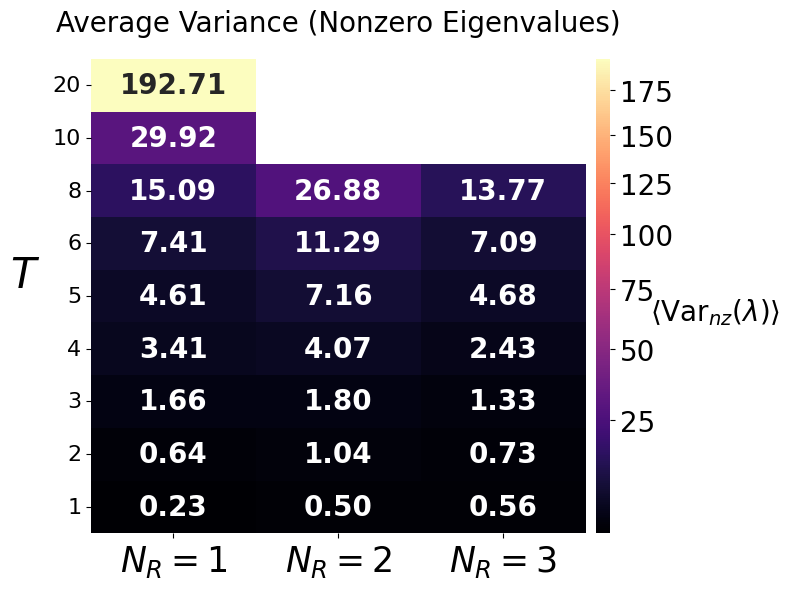

Descr: The average of the variance-per-rank values over all draws, reflecting the typical dispersion per active mode.


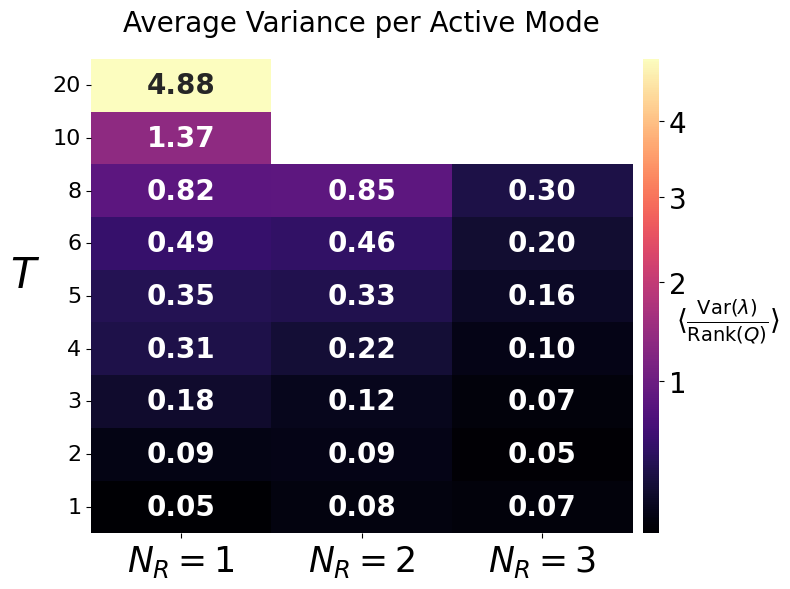

Descr: The average of the trace-per-rank values over all draws, representing the typical signal per active mode.


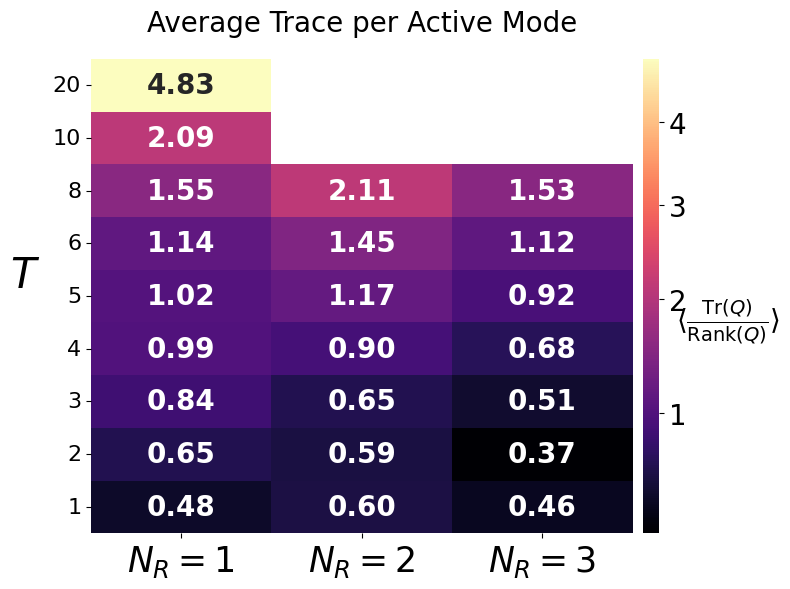

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import PowerNorm

def plot_qfim_metrics_heatmaps(df_all, N_ctrl, metric_keys, metrics_info, resies=None):
    """
    Generates heatmaps for multiple metrics specified in 'metric_keys' 
    using the definitions/titles in 'metrics_info'.

    - df_all: your main DataFrame.
    - N_ctrl: the control-qubit dimension you're focusing on (int).
    - metric_keys: list of column names in df_all that you want to plot.
    - metrics_info: dict with metadata for each metric_key
    - resies: list of reservoir-qubit counts you want on the x-axis 
      (defaults to [1,2,3,4] or whatever you specify).
    """

    # 1) Default reservoir list if none provided
    if resies is None:
        resies = [1, 2, 3]

    # 2) Decide how to pick Trotter steps based on N_ctrl
    if N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6]
    elif N_ctrl == 3:
        trots = np.arange(1, 60, 1)  # or your preferred range
    else:
        trots = [1, 2, 3, 4, 5, 6, 8, 9, 10,11, 12,13, 14, 16, 18, 20]

    # 3) Single filter step for this N_ctrl, reservoir set, and Trotter steps
    df_filtered = df_all.query("N_ctrl == @N_ctrl").copy()
    df_filtered = df_filtered[df_filtered["N_reserv"].isin(resies)]
    df_filtered = df_filtered[df_filtered["Trotter_Step"].isin(trots)]

    # 4) Loop over each metric you want to plot
    for metric_key in metric_keys:
        if metric_key not in df_filtered.columns:
            print(f"Warning: '{metric_key}' not in df_filtered columns.")
            continue

        # Retrieve title & color bar label from your dictionary

        metric_title = metrics_info.get(metric_key, {}).get('title', metric_key)
        metric_cbar  = metrics_info.get(metric_key, {}).get('label', '')
        metric_descr  = metrics_info.get(metric_key, {}).get('description', '')
        print(f"Descr: {metric_descr}")

        # 4a) Pivot the data for a heatmap
        df_heatmap = (
            df_filtered[["N_reserv", "Trotter_Step", metric_key]]
            .groupby(["Trotter_Step", "N_reserv"])[metric_key]
            .mean()  # or .median(), .max() etc. if desired
            .reset_index()
        )
        heatmap_pivot = df_heatmap.pivot(index="Trotter_Step", columns="N_reserv", values=metric_key)

        # 4b) Compute min/max for color normalization
        min_val = heatmap_pivot.min().min()
        max_val = heatmap_pivot.max().max()

        # 4c) Create formatted annotations
        # D_C: integer ranks, so show 0 decimal places
        if metric_key == "D_C":
            annotation_matrix = heatmap_pivot.map(lambda x: f"{x:.0f}")
        else:
            annotation_matrix = heatmap_pivot.map(lambda x: f"{x:.2f}")

        # 5) Plotting
        fig, ax = plt.subplots(figsize=(8, 6))

        # Create a divider to place colorbar alongside the heatmap
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.1)

        # Example: use a power-law normalization
        sns.heatmap(
            heatmap_pivot,
            annot=annotation_matrix, fmt="",  # fmt="" so we use our own annotated strings
            ax=ax, cbar_ax=cax, cmap="magma",
            annot_kws={"weight": "bold", "size": 20},
            norm=PowerNorm(gamma=0.7, vmin=min_val, vmax=max_val)
        )

        # Invert y-axis so T=1 is at the top
        ax.invert_yaxis()

        # Configure colorbar
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label(metric_cbar, rotation=0, labelpad=30, fontsize=20)

        # Title & labels
        ax.set_title(metric_title, fontsize=20, pad=20)
        ax.set_ylabel('$T$', labelpad=20, fontsize=30, rotation=0)
        ax.set_xlabel("", fontsize=20)
        ax.tick_params(axis='y', labelrotation=0, labelsize=16)
        ax.tick_params(axis='x', labelsize=16)

        # Format x-tick labels
        xticklabels = [f'$N_R = {int(col)}$' for col in heatmap_pivot.columns]
        ax.set_xticklabels(xticklabels, fontweight="bold", fontsize=25, rotation=0)

        plt.tight_layout()
        plt.show()
chosen_n_ctrl=2
N_ctrl = chosen_n_ctrl
metric_keys = ['D_C','avg_ipr_deffs_raw','avg_abbas_deffs_raw','spectrum_shape_avg_abbas_deffs_norm','spread_mean_per_sample_variance_normal','spread_val_pooled_variance_normal']
# metric_keys = ['D_C','spread_mean_per_sample_variance_normal','spread_val_pooled_variance_normal','spread_mean_per_sample_mad_normal','spectrum_shape_avg_ipr_deffs_raw']
metric_keys = ['absolute_scale_avg_var_nonzero','avg_per_active_mode_avg_var_norm_rank','avg_per_active_mode_avg_trace_norm_rank']
# metric_keys = ['D_C','d_eff_ipr']
# 'spectrum_shape_ipr_deffs_norm_per_draw',
#        'spectrum_shape_avg_ipr_deffs_norm',
#        'spectrum_shape_abbas_deffs_norm_per_draw',
#        'spectrum_shape_avg_abbas_deffs_norm',
plot_qfim_metrics_heatmaps(df_with_stats, N_ctrl=chosen_n_ctrl, metric_keys=metric_keys, metrics_info=metrics_info, resies=[1,2,3,4])

Detected critical T_C = 6
[INFO] For N_ctrl=2, N_reserv=1, peak T_C is 6
[INFO] For N_ctrl=2, N_reserv=1, peak T_C is 6


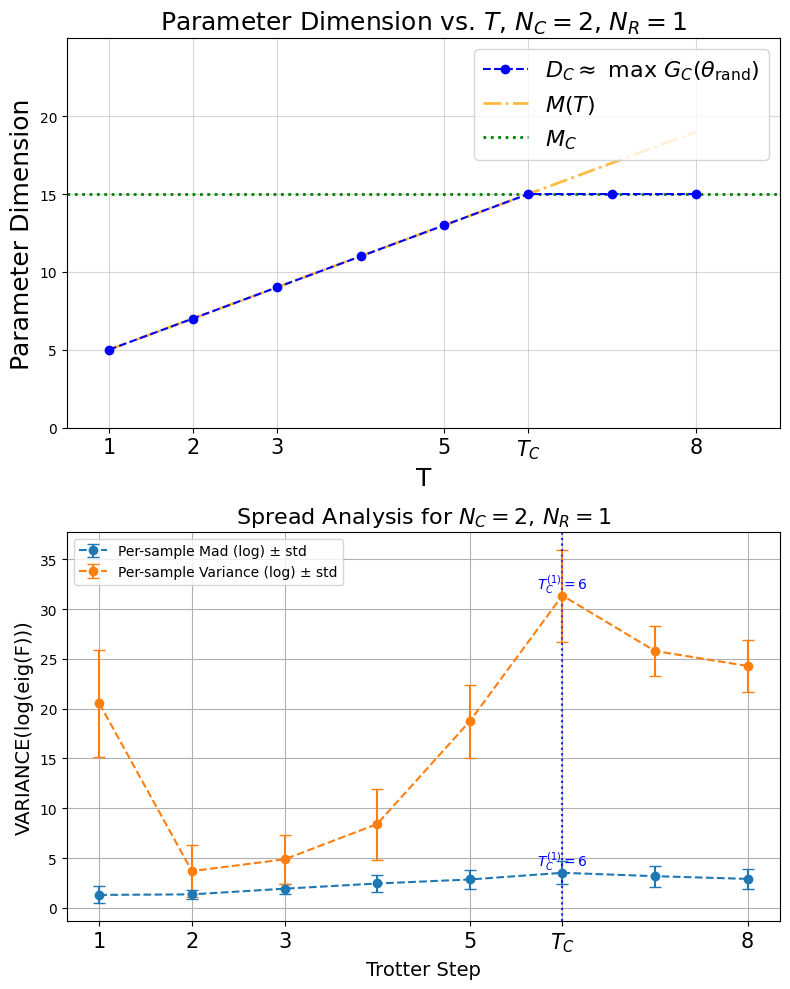

In [33]:
import matplotlib.pyplot as plt
def plot_spread_analysis(df, chosen_n_ctrl, chosen_n_reserv, ax=None,
                         spread_type="variance", combination="pooled",
                         show_yerr=False, title=None, xlabel="Trotter Step",
                         ylabel=None, num_ticks=6, scale='normal'):
    """
    Plots the spread analysis based on the given spread type and combination technique.
    
    If spread_type ends with "_nolog", then the function uses the corresponding key 
    (e.g. "spread_metric_variance_nolog") and labels the curve accordingly.
    
    Parameters:
    -----------
    - df: DataFrame containing spread data.
    - chosen_n_ctrl: Selected N_ctrl value.
    - chosen_n_reserv: Selected N_reserv value.
    - ax: Matplotlib axis to plot on (default: creates new figure).
    - spread_type: 'variance', 'mad', or with a "_nolog" suffix (e.g. "variance_nolog").
    - combination: 'pooled' or 'sampled'.
    - show_yerr: Whether to plot error bars (for sample-based only).
    - title: Title of the plot.
    - xlabel, ylabel: Axis labels.
    - num_ticks: Number of x-ticks to generate.
    - scale: String to match naming in df columns.
    """
    
    # Filter data for the chosen N_ctrl, N_reserv
    df_plot = df.query("N_ctrl==@chosen_n_ctrl & N_reserv==@chosen_n_reserv").copy()
    df_plot.sort_values("Trotter_Step", inplace=True)
    x_vals = df_plot["Trotter_Step"].values

    # Determine keys based on whether spread_type ends with "_nolog"
    if spread_type.endswith("_nolog"):
        y_mean_key = f"spread_metric_{spread_type}"
        data_label = f"Per-sample {spread_type.replace('_nolog','').capitalize()} (no log)"
        # For a no-log metric, we won't have y_std or pooled value
        y_mean = df_plot[y_mean_key].values
    else:
        y_mean_key = f"spread_mean_per_sample_{spread_type}_{scale}"
        y_std_key  = f"spread_std_per_sample_{spread_type}_{scale}"
        y_pool_key = f"spread_val_pooled_{spread_type}_{scale}"
        y_mean = df_plot[y_mean_key].values
        y_std = df_plot[y_std_key].values
        y_pool = df_plot[y_pool_key].values
        data_label = f"Per-sample {spread_type.capitalize()} (log)"
    
    # Choose which data array to use for detecting the peak T_C
    if combination == "sampled" or spread_type.endswith("_nolog"):
        data_for_peak = y_mean
    else:
        data_for_peak = y_pool

    peak_idx = int(np.argmax(data_for_peak))
    peak_T   = x_vals[peak_idx]
    peak_val = data_for_peak[peak_idx]
    print(f"[INFO] For N_ctrl={chosen_n_ctrl}, N_reserv={chosen_n_reserv}, peak T_C is {peak_T}")

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot the chosen data
    if not spread_type.endswith("_nolog"):
        if combination == "sampled":
            if show_yerr:
                ax.errorbar(x_vals, y_mean, yerr=y_std, fmt="o--",
                            capsize=4, label=f"{data_label} ± std")
            else:
                ax.plot(x_vals, y_mean, "s--", label=data_label)
        else:
            ax.plot(x_vals, y_pool, "s--", label=data_label)
    else:
        ax.plot(x_vals, y_mean, "r-^", label=data_label, alpha=0.7)

    # Annotate T_C with a vertical line and label.
    ax.axvline(x=peak_T, color='b', linestyle=':', alpha=0.6)
    ax.text(peak_T, peak_val + 0.1,
            fr"$T_C^{{({chosen_n_reserv})}}={peak_T}$",
            fontsize=10, color='b', ha='center', va='bottom')

    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel or f"{spread_type.upper()}(log(eig(F)))", fontsize=14)
    if not title:
        title = f'Spread Analysis for $N_C = {chosen_n_ctrl}$, $N_R = {chosen_n_reserv}$'
    ax.set_title(title, fontsize=16)
    ax.grid(True)
    ax.legend()

    # X-ticks: ensure T=1 and T_C are included.
    x_ticks = np.linspace(min(x_vals), max(x_vals), num=num_ticks, dtype=int)
    x_ticks = np.unique(np.append(x_ticks, [1, peak_T]))
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([f"$T_C$" if tick == peak_T else str(tick) for tick in x_ticks], fontsize=15)

    return ax

def get_num_params(N_r, N_c, T, model_type = 'digital'):
        if model_type == 'analog':
            return N_r * N_c * T + 3 + T
        elif model_type == 'digital':
            return N_r * N_c * T + 3
        else:
             raise TypeError(f'No model type: {model_type}')
def plot_max_rank_vs_params(df, chosen_n_ctrl, chosen_n_reserv, ax=None,
                            xlabel='T', ylabel='Parameter Dimension', title=None,
                            color='b', param_color='orange', critical_color='green',
                            legend_loc='upper right',num_ticks=6):
    """
    Plots max rank vs. parameters for given control and reservoir values.

    Parameters:
    - df: DataFrame containing 'Trotter_Step', 'N_ctrl', 'N_reserv', 'QFIM_ranks'.
    - chosen_n_ctrl: Selected control value for filtering.
    - chosen_n_reserv: Selected reservoir value for filtering.
    - ax: Matplotlib axis to plot on (default: creates new figure).
    - xlabel, ylabel: Axis labels.
    - title: Title of the plot.
    - color: Color for max rank plot line.
    - param_color: Color for parameter dimension line.
    - critical_color: Color for the critical threshold line.
    - legend_loc: Legend location.
    """
    
    # Filter for chosen values
    subset = df[(df['N_ctrl'] == chosen_n_ctrl) & (df['N_reserv'] == chosen_n_reserv)]
    
    trotter_steps, max_ranks = [], []
    for T_step, grp in subset.groupby('Trotter_Step'):
        all_ranks = [rank for row in grp['QFIM_ranks'] for rank in row]
        max_rank = np.max(all_ranks) if all_ranks else 0
        trotter_steps.append(T_step)
        max_ranks.append(max_rank)

    # Sort data
    trotter_steps, max_ranks = zip(*sorted(zip(trotter_steps, max_ranks)))

    # Compute parameter dimension M(T)
    param_list = [get_num_params(chosen_n_reserv, chosen_n_ctrl, t) for t in trotter_steps]

    # Detect critical T_C
    idx_C = int(np.argmax(max_ranks))
    T_C, M_C = trotter_steps[idx_C], param_list[idx_C]
    print(f"Detected critical T_C = {T_C}")
    # Create plot if no axis is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Plot max rank vs. Trotter step
    ax.plot(trotter_steps, max_ranks, marker='o', linestyle='--', color=color,
            label=r'$D_C \approx$ max $G_C(\theta_{\text{rand}})$', zorder=10)
    
    # Plot M(T)
    ax.plot(trotter_steps, param_list, color=param_color, linestyle='-.',
            alpha=0.75, linewidth=2, label='$M(T)$')
    
    # Horizontal line at M_C
    ax.axhline(y=M_C, color=critical_color, linestyle=':', linewidth=2, label='$M_C$')

    # X-axis ticks: evenly spaced, always including T=1 and T_C
    x_ticks = np.linspace(min(trotter_steps), max(trotter_steps), num=num_ticks, dtype=int)
    x_ticks = np.unique(np.append(x_ticks, [1, T_C]))  # Ensure T=1 and T_C are always included

    # Labeling T_C explicitly
    xtick_labels = [f"$T_C$" if tick == T_C else str(tick) for tick in x_ticks]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(xtick_labels, fontsize=15)
    


    # Y-axis: Ensure labels are integers
    ax.set_yticks(np.arange(0, max(max_ranks) + 10, step=5))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))

    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.legend(fontsize=16, loc=legend_loc)
    ax.grid(True, alpha=0.5)
    ax.set_ylim(top=M_C + 10)
    ax.set_xlim(left=0.5, right=max(trotter_steps)+1)
    if not title:
        title=f'Parameter Dimension vs. $T$, $N_C = {chosen_n_ctrl}$, $N_R = {chosen_n_reserv}$'
    if title:
        ax.set_title(title, fontsize=18)

    return ax
chosen_n_reserv = 1
chosen_n_ctrl = 2
scale="normal"
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
plot_max_rank_vs_params(df_with_stats, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv, ax=axes[0])
plot_spread_analysis(df_with_stats, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv, spread_type="mad", combination="sampled",scale=scale,show_yerr=True, ax=axes[1])
plot_spread_analysis(df_with_stats, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv, spread_type="variance", combination="sampled",scale=scale,show_yerr=True,ax=axes[1])
# plot_spread_analysis(df_with_stats, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv, spread_type="nolog", combination="sampled",scale=scale,ax=axes[1])

plt.tight_layout()
plt.show()

Detected critical T_C = 6


KeyError: 'spread_mean_per_sample_mad_normal'

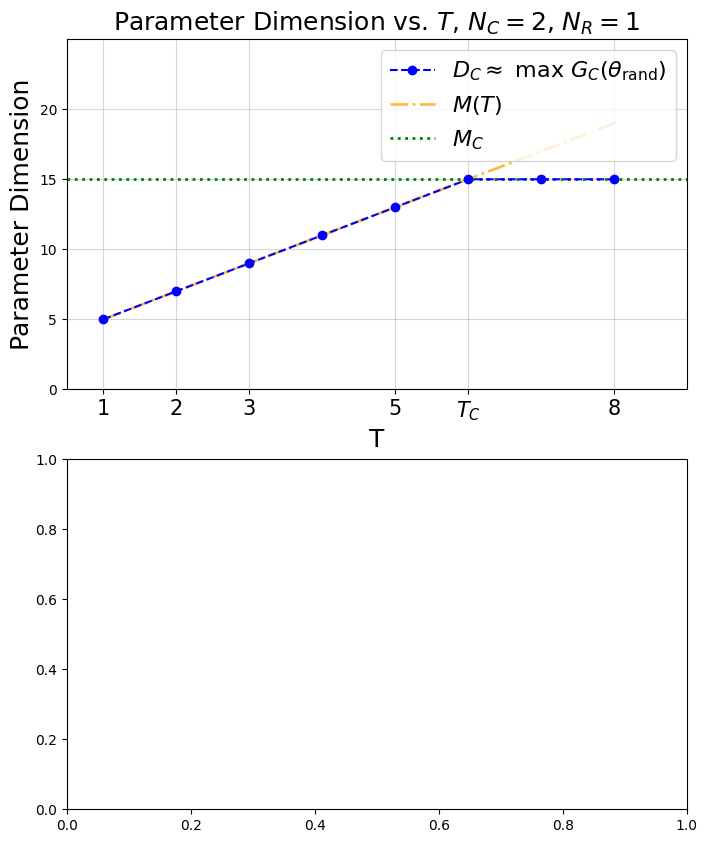

In [10]:

def get_num_params(N_r, N_c, T, model_type = 'digital'):
        if model_type == 'analog':
            return N_r * N_c * T + 3 + T
        elif model_type == 'digital':
            return N_r * N_c * T + 3
        else:
             raise TypeError(f'No model type: {model_type}')
def plot_max_rank_vs_params(df, chosen_n_ctrl, chosen_n_reserv, ax=None,
                            xlabel='T', ylabel='Parameter Dimension', title=None,
                            color='b', param_color='orange', critical_color='green',
                            legend_loc='upper right',num_ticks=6):
    """
    Plots max rank vs. parameters for given control and reservoir values.

    Parameters:
    - df: DataFrame containing 'Trotter_Step', 'N_ctrl', 'N_reserv', 'QFIM_ranks'.
    - chosen_n_ctrl: Selected control value for filtering.
    - chosen_n_reserv: Selected reservoir value for filtering.
    - ax: Matplotlib axis to plot on (default: creates new figure).
    - xlabel, ylabel: Axis labels.
    - title: Title of the plot.
    - color: Color for max rank plot line.
    - param_color: Color for parameter dimension line.
    - critical_color: Color for the critical threshold line.
    - legend_loc: Legend location.
    """
    
    # Filter for chosen values
    subset = df[(df['N_ctrl'] == chosen_n_ctrl) & (df['N_reserv'] == chosen_n_reserv)]
    
    trotter_steps, max_ranks = [], []
    for T_step, grp in subset.groupby('Trotter_Step'):
        all_ranks = [rank for row in grp['QFIM_ranks'] for rank in row]
        max_rank = np.max(all_ranks) if all_ranks else 0
        trotter_steps.append(T_step)
        max_ranks.append(max_rank)

    # Sort data
    trotter_steps, max_ranks = zip(*sorted(zip(trotter_steps, max_ranks)))

    # Compute parameter dimension M(T)
    param_list = [get_num_params(chosen_n_reserv, chosen_n_ctrl, t) for t in trotter_steps]

    # Detect critical T_C
    idx_C = int(np.argmax(max_ranks))
    T_C, M_C = trotter_steps[idx_C], param_list[idx_C]
    print(f"Detected critical T_C = {T_C}")
    # Create plot if no axis is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Plot max rank vs. Trotter step
    ax.plot(trotter_steps, max_ranks, marker='o', linestyle='--', color=color,
            label=r'$D_C \approx$ max $G_C(\theta_{\text{rand}})$', zorder=10)
    
    # Plot M(T)
    ax.plot(trotter_steps, param_list, color=param_color, linestyle='-.',
            alpha=0.75, linewidth=2, label='$M(T)$')
    
    # Horizontal line at M_C
    ax.axhline(y=M_C, color=critical_color, linestyle=':', linewidth=2, label='$M_C$')

    # X-axis ticks: evenly spaced, always including T=1 and T_C
    x_ticks = np.linspace(min(trotter_steps), max(trotter_steps), num=num_ticks, dtype=int)
    x_ticks = np.unique(np.append(x_ticks, [1, T_C]))  # Ensure T=1 and T_C are always included

    # Labeling T_C explicitly
    xtick_labels = [f"$T_C$" if tick == T_C else str(tick) for tick in x_ticks]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(xtick_labels, fontsize=15)
    


    # Y-axis: Ensure labels are integers
    ax.set_yticks(np.arange(0, max(max_ranks) + 10, step=5))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))

    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.legend(fontsize=16, loc=legend_loc)
    ax.grid(True, alpha=0.5)
    ax.set_ylim(top=M_C + 10)
    ax.set_xlim(left=0.5, right=max(trotter_steps)+1)
    if not title:
        title=f'Parameter Dimension vs. $T$, $N_C = {chosen_n_ctrl}$, $N_R = {chosen_n_reserv}$'
    if title:
        ax.set_title(title, fontsize=18)

    return ax
chosen_n_reserv = 1
chosen_n_ctrl = 2
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
plot_max_rank_vs_params(df_with_stats, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv, ax=axes[0])
# plot_max_rank_vs_params(df_with_stats, chosen_n_ctrl=chosen_n_ctrl+1, chosen_n_reserv=chosen_n_reserv, ax=axes[1])
plot_spread_analysis(df_all, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv, spread_type="mad", combination="sampled",scale="normal",show_yerr=True, ax=axes[1])
# plot_spread_analysis(df_all, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv, spread_type="variance", combination="sampled",ax=axes[1])

plt.tight_layout()
plt.show()

Detected critical T_C = 6
[INFO] For N_ctrl=2, N_reserv=1, peak T_C is 6
Detected critical T_C = 3
[INFO] For N_ctrl=2, N_reserv=2, peak T_C is 3


ValueError: not enough values to unpack (expected 2, got 0)

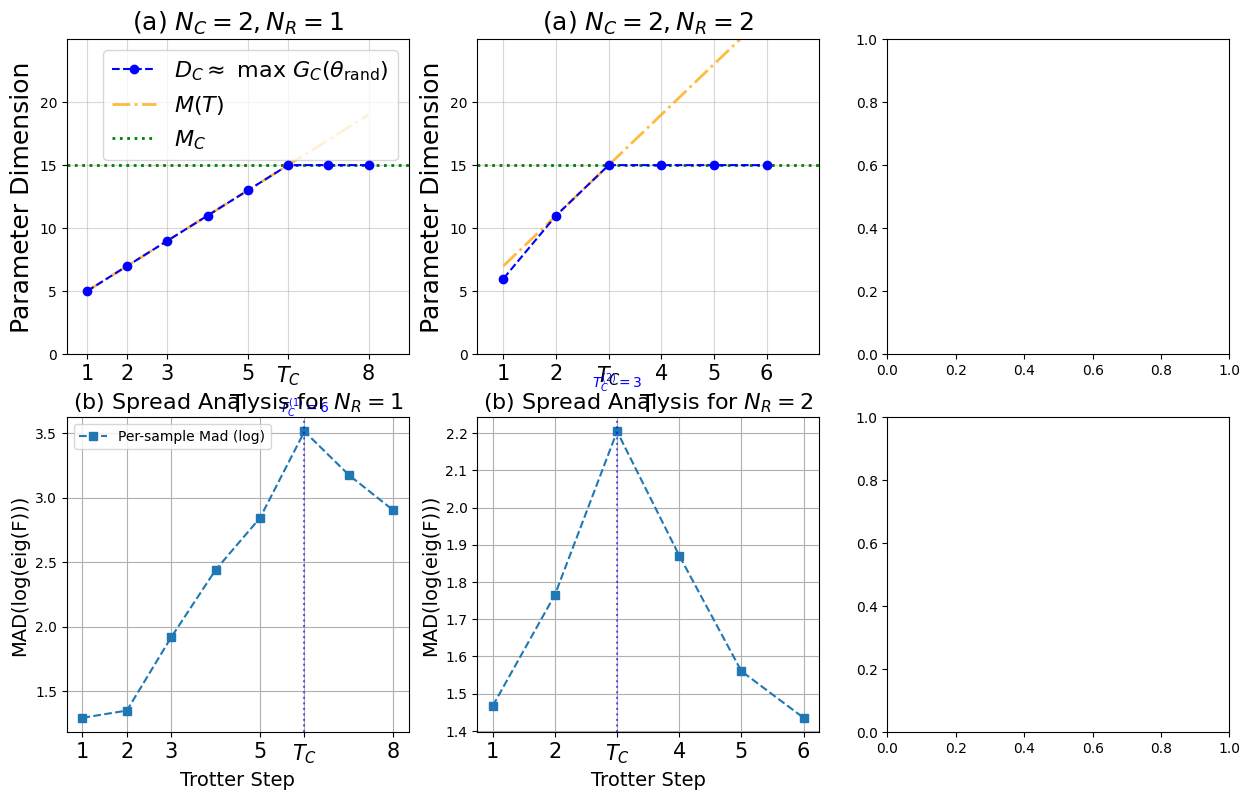

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_many_reserv(df, N_ctrl=2, reserv_list=[1, 2, 3], spread_type="mad"):
    """
    Creates a 2xN grid of subplots, with the top row showing plot_max_rank_vs_params
    and the bottom row showing plot_spread_analysis, each column for a different N_R.

    Parameters:
    -----------
    
    df : pd.DataFrame
        The dataframe containing your QFIM info (with 'N_ctrl','N_reserv','Trotter_Step', etc.).
    N_ctrl : int
        The control qubit count to fix for all columns.
    reserv_list : list of int
        The distinct N_reserv values you want to show (e.g. [1, 2, 3]).
    spread_type : str
        'variance' or 'mad', as accepted by your plot_spread_analysis function.

    Returns:
    --------
    fig, axes : The figure and axes objects for further customization.
    """

    # Number of columns is the length of reserv_list
    ncols = len(reserv_list)
    fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(5*ncols, 9), sharex=False, sharey=False)

    # If there is only 1 column, make sure we index axes as 2D
    if ncols == 1:
        # shape would be (2, ) if there's only one column
        axes = np.array([axes]).T  # transform to shape (2,1)

    for col_idx, nr_val in enumerate(reserv_list):
        # ------------------
        # Top row: max-rank vs. T
        # ------------------
        ax_top = axes[0, col_idx]
        plot_max_rank_vs_params(
            df, chosen_n_ctrl=N_ctrl, chosen_n_reserv=nr_val, ax=ax_top,
            xlabel="T", ylabel="Parameter Dimension",
            title=f"(a) $N_C={N_ctrl}, N_R={nr_val}$"
        )

        # Hide repeated legends if you only want them once:
        if col_idx > 0:
            ax_top.legend_.remove()

        # ------------------
        # Bottom row: spread analysis
        # ------------------
        ax_bot = axes[1, col_idx]
        plot_spread_analysis(
            df, chosen_n_ctrl=N_ctrl, chosen_n_reserv=nr_val,
            ax=ax_bot, spread_type=spread_type, combination="sampled",scale="normal",
            xlabel="Trotter Step", ylabel=f"{spread_type.upper()}(log(eig(F)))",
            title=f"(b) Spread Analysis for $N_R={nr_val}$"
        )

        if col_idx > 0:
            # Similarly remove legends if you want minimal duplication
            # Or keep them if you prefer each subplot to have its own
            ax_bot.legend_.remove()

    plt.tight_layout()
    return fig, axes

# Example usage:
fig, axes = plot_many_reserv(df_with_stats, N_ctrl=2, reserv_list=[1,2,3], spread_type="mad")

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_72983/3987386988.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap(color_map, len(ctrl_list))


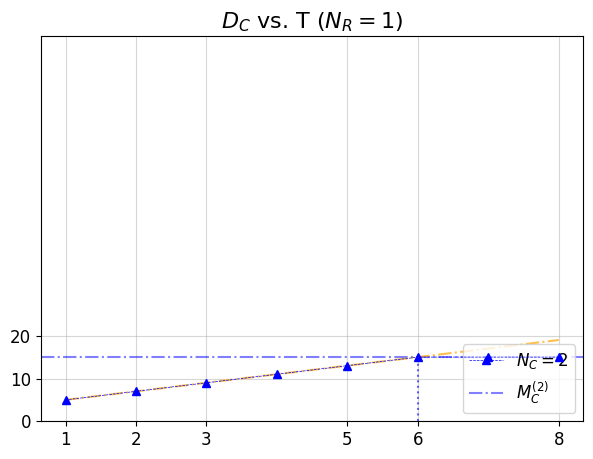

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_72983/3987386988.py:307: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(color_map, len(ctrl_list))


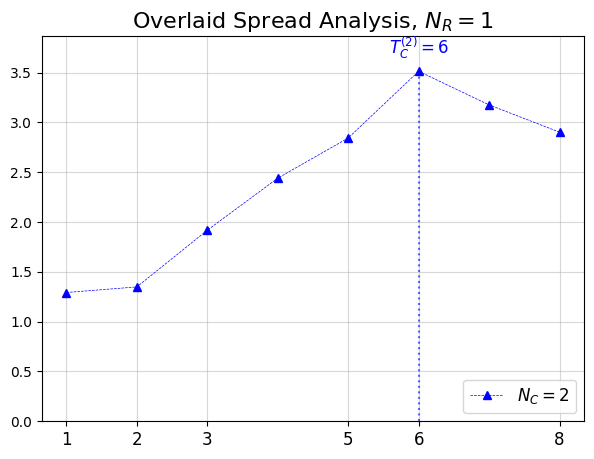

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
def plot_max_rank_vs_params_overlaid_for_ctrl(
    df,
    reserv_fixed=1,
    ctrl_list=[2, 3],
    rank_colors=None,
    xlabel='T',
    ylabel='Parameter Dimension',
    title=None,
    ax=None,
    color_map='tab10',
    legend_loc='lower right',
    num_ticks=6
):
    """
    Single subplot overlaying the 'max rank vs. T' logic for multiple N_ctrl values,
    while N_reserv is fixed (defaults to 1).

    Each N_ctrl gets:
      - A rank-vs-T line with color c
      - M(T) = (N_reserv*N_ctrl*T + 3) line in the same color, with different style
      - A horizontal line at M_C (param dimension at T_C) in that same color
      - A vertical line at T_C with text label T_C^{(N_ctrl)}

    This imitates the full 'plot_max_rank_vs_params' style but for multiple curves in one figure.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns 'N_ctrl','N_reserv','Trotter_Step','QFIM_ranks'.
    reserv_fixed : int
        N_reserv value to hold constant across all overlaid lines.
    ctrl_list : list of int
        Distinct N_ctrl values we want to overlay in one plot.
    xlabel, ylabel : str
        Axis labels.
    title : str
        Plot title. If None, we autogenerate one.
    color_map : str
        The colormap name to draw distinct colors from, e.g. 'tab10'.
    legend_loc : str
        Where to place the legend.
    num_ticks : int
        Number of x ticks to generate.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """

    if df.empty:
        raise ValueError("DataFrame is empty. Please provide valid data.")

    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))
    else:
        fig = ax.figure

    # Prepare a color cycle
    cm = plt.cm.get_cmap(color_map, len(ctrl_list))

    # We will gather all T values from all lines for setting x-ticks
    # and keep track of the global max dimension for y-limits
    all_t = set()
    global_max_dim = 0.0  # to store the max of (rank or M(T)) across all lines
    # We only want one legend entry for M(T)
    m_legend_added = False
    for i, ctrl_val in enumerate(ctrl_list):
        # Filter the DataFrame for this N_ctrl
        subset = df.query("N_ctrl == @ctrl_val and N_reserv == @reserv_fixed").copy()
        if subset.empty:
            continue

        # For each Trotter_Step, find the maximum rank
        trotter_steps = []
        max_ranks = []
        for T_step, grp in subset.groupby('Trotter_Step'):
            all_ranks = [rank for row in grp['QFIM_ranks'] for rank in row]
            if all_ranks:
                rmax = np.max(all_ranks)
            else:
                rmax = 0
            trotter_steps.append(T_step)
            max_ranks.append(rmax)

        # Sort them by T
        trotter_steps, max_ranks = zip(*sorted(zip(trotter_steps, max_ranks)))

        # Construct M(T) = N_reserv*N_ctrl*T + 3 (digital model)
        param_list = [reserv_fixed * ctrl_val * t + 3 for t in trotter_steps]

        # Identify T_C => argmax of max_ranks
        idx_C = int(np.argmax(max_ranks))
        T_C   = trotter_steps[idx_C]
        M_C   = param_list[idx_C]
        rankC = max_ranks[idx_C]

        # Determine the color for this rank curve
        c = rank_colors.get(ctrl_val, f"C{ctrl_val}")  # default fallback if not in dict


        # Plot the rank line, labeled with N_ctrl
        ax.plot(
            trotter_steps, max_ranks,
            marker='^', linestyle='--', linewidth=0.5,
            color=c, label=fr"$N_C={ctrl_val}$",
            zorder=10
        )

        

        # 3) Horizontal line at M_C, slightly lighter
        c_h = to_rgba(c)
        # reduce alpha for the horizontal line
        c_h = (c_h[0], c_h[1], c_h[2], 0.5)
        ax.axhline(
            y=M_C,
            color=c_h,
            linestyle='-.',
            linewidth=1.5,
            label=fr"$M_C^{{({ctrl_val})}}$"
        )

        ax.vlines(T_C, 0, M_C, color=c, linestyle=':', alpha=0.6)
        # ax.text(
        #     T_C, rankC + 2,   # position above the rank
        #     fr"$T_C^{{({ctrl_val})}}={T_C}$",
        #     fontsize=10, color=c, ha='center', va='bottom'
        # )

        # Update the global sets
        for t in trotter_steps:
            all_t.add(t)

        # Track largest dimension among rank or param
        local_max_dim = max(np.max(max_ranks), np.max(param_list))
        if local_max_dim > global_max_dim:
            global_max_dim = local_max_dim
        # 2) Plot M(T) in orange, with only one legend entry
        if not m_legend_added:
            ax.plot(
                trotter_steps,
                param_list,
                color='orange',
                linestyle='-.',
                alpha=0.7,
                linewidth=1.5,
                
            )
            m_legend_added = True
        else:
            # no label for subsequent lines
            ax.plot(
                trotter_steps,
                param_list,
                color='orange',
                linestyle='-.',
                alpha=0.7,
                linewidth=1.5,
                label=r"$M(T)$"
            )

    # Now define the x-ticks
    if len(all_t) == 0:
        # no data?
        all_t = {1}
    t_min, t_max = min(all_t), max(all_t)
    x_ticks = np.linspace(t_min, t_max, num=num_ticks, dtype=int)
    # ensure T=1 included
    x_ticks = np.unique(np.append(x_ticks, [1]))
    # set them
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(t) for t in x_ticks], fontsize=12)

    # Y-axis: integer ticks up to global_max_dim
    # We'll step in increments of 5
    ytop = int(global_max_dim + 10)
    steps = np.arange(0, ytop+1, 10)
    ax.set_yticks(steps)
    ax.set_ylim(bottom=0,top=90)
    ax.set_yticklabels([str(int(y)) for y in steps], fontsize=12)

    # Axis labeling
    # ax.set_xlabel(xlabel, fontsize=14)
    # ax.set_ylabel(ylabel, fontsize=14)

    if not title:
        title = fr"Overlaid Max Rank vs. T for $N_R={reserv_fixed}$"
    ax.set_title(title, fontsize=16)
    
    ax.legend(loc=legend_loc, fontsize=12)
    ax.grid(True, alpha=0.5)

    return ax


fig, ax = plt.subplots(figsize=(7, 5))
rank_colors = {
    2: 'blue',
    3: 'purple',
    4: 'green'
}

plot_max_rank_vs_params_overlaid_for_ctrl(
    df_with_stats,
    reserv_fixed=1,
    ctrl_list=[2, 3, 4],
    rank_colors=rank_colors,
    ax=ax,
    xlabel='T',
    ylabel='Parameter Dimension',
    title='$D_C$ vs. T ($N_R=1$)',
)

plt.show()
import numpy as np
import matplotlib.pyplot as plt

def plot_spread_overlaid_with_TC_for_ctrl(
    df,
    reserv_fixed=1,
    ctrl_list=[2, 3],
    spread_type="mad",
    combination="sampled",
    scale="normal",
    ax=None,
    ctrl_colors=None,
    color_map="tab10",
    title=None,
    xlabel="Trotter Step",
    ylabel=None,
    legend_loc="lower right",
    num_xticks=10
):
    """
    Single subplot that overlays multiple lines for distinct N_ctrl values,
    all at a fixed N_reserv. Each line shows the chosen spread metric
    ('variance' or 'mad'), either 'sampled' or 'pooled', with T_C detection.

    Styling is made to match plot_max_rank_vs_params_overlaid_for_ctrl:
      - Marker '^', dashed line '--', custom color or fallback to a colormap
      - Vertical line at T_C from y=0 to y=peak_value
      - T_C annotation above the peak
      - Legend in 'lower right' by default
      - X-ticks set similarly

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns for spread data, e.g.:
          'spread_mean_per_sample_{spread_type}_{scale}',
          'spread_std_per_sample_{spread_type}_{scale}',
          'spread_val_pooled_{spread_type}_{scale}',
        plus 'N_ctrl','N_reserv','Trotter_Step'.
    reserv_fixed : int
        Which N_reserv to fix for all lines.
    ctrl_list : list of int
        Which N_ctrl values to overlay.
    spread_type : {'variance','mad'}
        Which spread metric to plot.
    combination : {'pooled','sampled'}
        Whether to plot 'pooled' or 'sampled' data.
    scale : str
        Usually 'normal', matching the suffix in your DataFrame columns.
    ax : matplotlib.axes.Axes or None
        If None, a new figure/axes is created.
    ctrl_colors : dict or None
        Optional mapping {N_ctrl_value: color_str}.
        If None or missing a key, we use a fallback from 'color_map'.
    color_map : str
        Name of the colormap to use if ctrl_colors is missing an entry.
    title : str
        Plot title. If None, a default is generated.
    xlabel : str
        Label for the x-axis.
    ylabel : str
        Label for the y-axis. If None, defaults to "MAD(log(eig(F)))" or "VARIANCE(...)"
    legend_loc : str
        Location of the legend.
    num_xticks : int
        Number of x ticks to generate via linspace.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """

    # Validate inputs
    if combination not in ["pooled", "sampled"]:
        raise ValueError("combination must be 'pooled' or 'sampled'")
    if spread_type not in ["variance", "mad"]:
        raise ValueError("spread_type must be 'variance' or 'mad'")

    # Create axis if none provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    # If no custom color dict, create an empty one
    if ctrl_colors is None:
        ctrl_colors = {}

    # Prepare a colormap fallback
    cmap = plt.cm.get_cmap(color_map, len(ctrl_list))

    # Column names
    y_mean_col = f"spread_mean_per_sample_{spread_type}_{scale}"
    y_pool_col = f"spread_val_pooled_{spread_type}_{scale}"

    # Track the global max Y for setting a suitable y-limit
    global_max_y = 0.0

    for i, ctrl_val in enumerate(ctrl_list):
        # Filter data for (N_ctrl, N_reserv)
        df_filt = df.query("N_ctrl == @ctrl_val & N_reserv == @reserv_fixed").copy()
        df_filt.sort_values("Trotter_Step", inplace=True)
        if df_filt.empty:
            continue

        x_vals = df_filt["Trotter_Step"].values
        y_mean = df_filt[y_mean_col].values
        y_pool = df_filt[y_pool_col].values

        # Choose which array to plot
        if combination == "sampled":
            y_plot = y_mean
        else:  # "pooled"
            y_plot = y_pool

        # Determine color for this N_ctrl
        c = ctrl_colors.get(ctrl_val, cmap(i))

        # Plot with marker '^' and dashed line '--'
        ax.plot(
            x_vals,
            y_plot,
            marker='^',
            linestyle='--',
            linewidth=0.5,
            color=c,
            label=fr"$N_C={ctrl_val}$",
            zorder=10
        )

        # Identify T_C => peak in y_plot
        peak_idx = int(np.argmax(y_plot))
        peak_T   = x_vals[peak_idx]
        peak_val = y_plot[peak_idx]

        # Draw a vertical line from y=0 to y=peak_val
        ax.vlines(peak_T, 0, peak_val, color=c, linestyle=':', alpha=0.6)

        # Annotate T_C near the peak
        ax.text(
            peak_T,
            peak_val + 0.1,  # slight offset
            fr"$T_C^{{({ctrl_val})}}={peak_T}$",
            fontsize=12,
            color=c,
            ha='center',
            va='bottom'
        )

        # Update global max
        local_max = np.max(y_plot)
        if local_max > global_max_y:
            global_max_y = local_max

    # Set x-ticks
    # We gather all Trotter steps for the chosen N_reserv from the entire df
    df_res = df.query("N_reserv == @reserv_fixed")
    if not df_res.empty:
        all_t = df_res["Trotter_Step"].unique()
        t_min, t_max = all_t.min(), all_t.max()
    else:
        t_min, t_max = 1, 1
    t_min, t_max = min(all_t), max(all_t)
    x_ticks = np.linspace(t_min, t_max, num=6, dtype=int)
    # ensure T=1 included
    x_ticks = np.unique(np.append(x_ticks, [1]))
    # set them
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(t) for t in x_ticks], fontsize=12)
    # x_ticks = np.linspace(t_min, t_max, num=num_xticks, dtype=int)
    # x_ticks = np.unique(np.append(x_ticks, [1]))  # ensure T=1 included
    # ax.set_xticks(x_ticks)
    # ax.set_xticklabels([str(t) for t in x_ticks], fontsize=12)

    # Let matplotlib auto-handle y-ticks; just set an upper limit with some margin
    # so we don't clip the peak annotation
    if global_max_y <= 0:
        # fallback if no data
        global_max_y = 1.0
    margin_factor = 1.1
    ax.set_ylim(bottom=0, top=global_max_y * margin_factor)

    # Axis labeling
    # ax.set_xlabel(xlabel, fontsize=14)
    # ax.set_ylabel(ylabel or f"{spread_type.upper()}(log(eig(F)))", fontsize=14)

    # Title & legend
    if not title:
        title = f"Overlaid Spread Analysis, $N_R={reserv_fixed}$"
    ax.set_title(title, fontsize=16)

    ax.legend(loc=legend_loc, fontsize=12)
    ax.grid(True, alpha=0.5)

    return ax

fig, ax = plt.subplots(figsize=(7,5))

# Suppose we want N_C=2 to be 'blue', N_C=3 to be 'purple':
ctrl_colors = {
    2: 'blue',
    3: 'purple'
}

plot_spread_overlaid_with_TC_for_ctrl(
    df_with_stats,
    reserv_fixed=1,
    ctrl_list=[2, 3],
    spread_type="mad",
    combination="sampled",
    scale="normal",
    ax=ax,
    ctrl_colors=ctrl_colors,
    color_map="tab10",
    legend_loc="lower right",
    title="Overlaid Spread Analysis, $N_R=1$"
)
plt.show()


New global max rank: 19, rankC: 15
New global max rank: 27, rankC: 15
ytop: 37


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_72983/2416534060.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap(color_map, len(reserv_list))


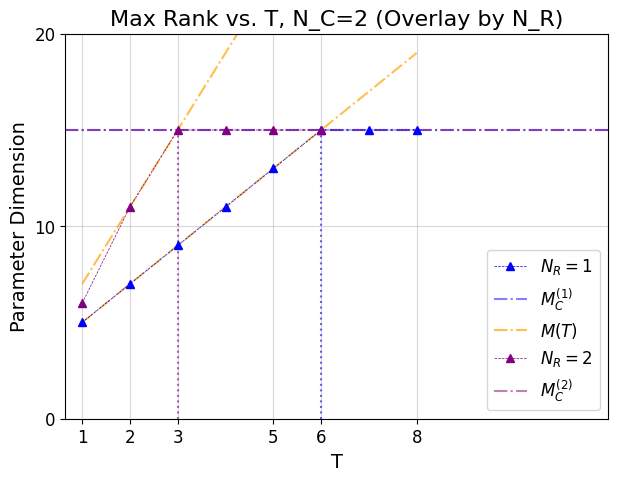

In [13]:
def plot_max_rank_vs_params_overlaid_for_reserv(
    df,
    ctrl_fixed=2,
    reserv_list=[1, 2, 3],
    rank_colors=None,
    xlabel='T',
    ylabel='Parameter Dimension',
    title=None,
    ax=None,
    color_map='tab10',
    legend_loc='lower right',
    num_ticks=6,
    model_type='digital'
):
    """
    Single subplot overlaying the 'max rank vs. T' logic for multiple N_reserv values,
    while N_ctrl is fixed (defaults to 2).

    Each N_reserv gets:
      - A rank-vs-T line with color c
      - M(T) = (N_reserv*N_ctrl*T + 3) line in the same color, with different style
        (or M(T) = N_reserv*N_ctrl*T + 3 + T if model_type='analog')
      - A horizontal line at M_C (param dimension at T_C) in that same color
      - A vertical line at T_C with text label T_C^{(N_reserv)}

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns 'N_ctrl','N_reserv','Trotter_Step','QFIM_ranks'.
    ctrl_fixed : int
        N_ctrl value to hold constant across all overlaid lines.
    reserv_list : list of int
        Distinct N_reserv values we want to overlay in one plot.
    rank_colors : dict or None
        Optional mapping {N_reserv_value: color_str}. If missing a key, fallback is used.
    xlabel, ylabel : str
        Axis labels.
    title : str
        Plot title. If None, autogenerate one.
    ax : matplotlib.axes.Axes or None
        If None, create a new figure/axes.
    color_map : str
        Name of a matplotlib colormap to use if rank_colors is missing keys.
    legend_loc : str
        Legend location.
    num_ticks : int
        Number of x-ticks to generate via linspace.
    model_type : {'digital','analog'}
        If 'digital', param dimension = N_reserv*N_ctrl*T + 3.
        If 'analog',  param dimension = N_reserv*N_ctrl*T + 3 + T.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """

    import matplotlib.pyplot as plt
    from matplotlib.colors import to_rgba

    if df.empty:
        raise ValueError("DataFrame is empty. Provide valid data.")
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    if rank_colors is None:
        rank_colors = {}

    cm = plt.cm.get_cmap(color_map, len(reserv_list))

    all_t = set()
    global_max_dim = 0.0
    m_legend_added = False

    def get_num_params(N_r, N_c, T, model_type='digital'):
        if model_type == 'analog':
            return N_r * N_c * T + 3 + T
        elif model_type == 'digital':
            return N_r * N_c * T + 3
        else:
            raise TypeError(f'No model type: {model_type}')

    for i, r_val in enumerate(reserv_list):
        subset = df.query("N_ctrl == @ctrl_fixed and N_reserv == @r_val").copy()
        if subset.empty:
            continue

        trotter_steps = []
        max_ranks = []
        for T_step, grp in subset.groupby('Trotter_Step'):
            all_ranks = [rank for row in grp['QFIM_ranks'] for rank in row]
            rmax = np.max(all_ranks) if all_ranks else 0
            trotter_steps.append(T_step)
            max_ranks.append(rmax)

        # Sort them
        trotter_steps, max_ranks = zip(*sorted(zip(trotter_steps, max_ranks)))
        # Construct param dimension M(T)
        param_list = [get_num_params(r_val, ctrl_fixed, t, model_type=model_type)
                      for t in trotter_steps]

        idx_C = int(np.argmax(max_ranks))
        T_C   = trotter_steps[idx_C]
        M_C   = param_list[idx_C]
        rankC = max_ranks[idx_C]

        c = rank_colors.get(r_val, cm(i))

        # Plot rank line
        ax.plot(
            trotter_steps, max_ranks,
            marker='^', linestyle='--', linewidth=0.5,
            color=c, label=fr"$N_R={r_val}$",
            zorder=10
        )

        # Horizontal line at M_C
        c_h = to_rgba(c)
        c_h = (c_h[0], c_h[1], c_h[2], 0.5)
        ax.axhline(y=M_C, color=c_h, linestyle='-.', linewidth=1.5,
                   label=fr"$M_C^{{({r_val})}}$")

        # Vertical line at T_C
        ax.vlines(T_C, 0, M_C, color=c, linestyle=':', alpha=0.6)

        # Update sets
        all_t.update(trotter_steps)
        local_max_dim = max(np.max(max_ranks), np.max(param_list))
        if local_max_dim > global_max_dim:
            global_max_dim = local_max_dim

            print(f"New global max rank: {global_max_dim}, rankC: {rankC}")

        # Plot M(T) in orange, with only one legend entry if not added
        if not m_legend_added:
            ax.plot(trotter_steps, param_list, color='orange', linestyle='-.',
                    alpha=0.7, linewidth=1.5, label=r"$M(T)$")
            m_legend_added = True
        else:
            ax.plot(trotter_steps, param_list, color='orange', linestyle='-.',
                    alpha=0.7, linewidth=1.5)

    if len(all_t) == 0:
        all_t = {1}
    t_min, t_max = min(all_t), max(all_t)
    x_ticks = np.linspace(t_min, t_max, num=num_ticks, dtype=int)
    x_ticks = np.unique(np.append(x_ticks, [1]))
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(t) for t in x_ticks], fontsize=12)

    # Y-axis integer ticks
    ytop = int(global_max_dim + 10)
    steps = np.arange(0, ytop+1, 10)
    ax.set_yticks(steps)
    print(f"ytop: {ytop}")
    ax.set_ylim(bottom=0, top=rankC +5)
    ax.set_xlim(right=12)
    ax.set_yticklabels([str(int(y)) for y in steps], fontsize=12)

    if not title:
        title = fr"Overlaid Max Rank vs. T for $N_C={ctrl_fixed}$"
    ax.set_title(title, fontsize=16)
    ax.legend(loc=legend_loc, fontsize=12)
    ax.grid(True, alpha=0.5)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

    return ax
fig, ax = plt.subplots(figsize=(7, 5))
rank_colors = {
    1: 'blue',
    2: 'purple',
    3: 'green'
}
plot_max_rank_vs_params_overlaid_for_reserv(
    df_with_stats,
    ctrl_fixed=2,
    reserv_list=[1, 2, 3],
    rank_colors=rank_colors,
    ax=ax,
    xlabel='T',
    ylabel='Parameter Dimension',
    title='Max Rank vs. T, N_C=2 (Overlay by N_R)',
    model_type='digital'
)
plt.show()

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_72983/2051984672.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(color_map, len(reserv_list))


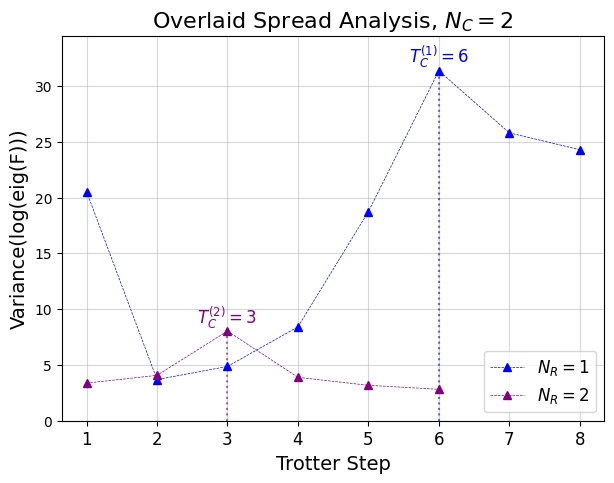

In [14]:
def plot_spread_overlaid_with_TC_for_reserv(
    df,
    ctrl_fixed=2,
    reserv_list=[1, 2, 3],
    spread_type="mad",
    combination="sampled",
    scale="normal",
    ax=None,
    reserv_colors=None,
    color_map="tab10",
    title=None,
    xlabel="Trotter Step",
    ylabel=None,
    legend_loc="lower right",
    num_xticks=10
):
    """
    Single subplot that overlays multiple lines for distinct N_reserv values,
    all at a fixed N_ctrl. Each line shows the chosen spread metric
    ('variance' or 'mad'), either 'sampled' or 'pooled', with T_C detection.

    Styling parallels plot_spread_overlaid_with_TC_for_ctrl:
      - Marker '^', dashed line '--', custom color or fallback to colormap
      - Vertical line at T_C from y=0 to y=peak_value
      - T_C annotation above the peak
      - Legend in 'lower right' by default
      - X-ticks set similarly

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns for spread data, e.g.:
          'spread_mean_per_sample_{spread_type}_{scale}',
          'spread_std_per_sample_{spread_type}_{scale}',
          'spread_val_pooled_{spread_type}_{scale}',
        plus 'N_ctrl','N_reserv','Trotter_Step'.
    ctrl_fixed : int
        Which N_ctrl to fix for all lines.
    reserv_list : list of int
        Which N_reserv values to overlay.
    spread_type : {'variance','mad'}
        Which spread metric to plot.
    combination : {'pooled','sampled'}
        Whether to plot 'pooled' or 'sampled' data.
    scale : str
        Usually 'normal', matching the suffix in your DataFrame columns.
    ax : matplotlib.axes.Axes or None
        If None, a new figure/axes is created.
    reserv_colors : dict or None
        Optional mapping {N_reserv_value: color_str}.
        If missing a key, fallback is used from color_map.
    color_map : str
        Name of the colormap to use if reserv_colors is missing an entry.
    title : str
        Plot title. If None, a default is generated.
    xlabel : str
        Label for the x-axis.
    ylabel : str
        Label for the y-axis. If None, defaults to "MAD(log(eig(F)))" or "VARIANCE(...)"
    legend_loc : str
        Location of the legend.
    num_xticks : int
        Number of x ticks to generate.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """

    import matplotlib.pyplot as plt

    if combination not in ["pooled", "sampled"]:
        raise ValueError("combination must be 'pooled' or 'sampled'")
    if spread_type not in ["variance", "mad"]:
        raise ValueError("spread_type must be 'variance' or 'mad'")

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    if reserv_colors is None:
        reserv_colors = {}

    cmap = plt.cm.get_cmap(color_map, len(reserv_list))

    # Column names
    y_mean_col = f"spread_mean_per_sample_{spread_type}_{scale}"
    y_std_col  = f"spread_std_per_sample_{spread_type}_{scale}"
    y_pool_col = f"spread_val_pooled_{spread_type}_{scale}"

    global_max_y = 0.0

    for i, r_val in enumerate(reserv_list):
        df_filt = df.query("N_ctrl == @ctrl_fixed & N_reserv == @r_val").copy()
        df_filt.sort_values("Trotter_Step", inplace=True)
        if df_filt.empty:
            continue

        x_vals = df_filt["Trotter_Step"].values
        y_mean = df_filt[y_mean_col].values
        y_std  = df_filt[y_std_col].values
        y_pool = df_filt[y_pool_col].values

        # Choose which array to plot
        if combination == "sampled":
            y_plot = y_mean
        else:
            y_plot = y_pool

        c = reserv_colors.get(r_val, cmap(i))

        # Plot with marker '^' and dashed line '--'
        ax.plot(
            x_vals, y_plot,
            marker='^', linestyle='--', linewidth=0.5,
            color=c, label=fr"$N_R={r_val}$",
            zorder=10
        )

        # Identify T_C => peak in y_plot
        peak_idx = int(np.argmax(y_plot))
        peak_T   = x_vals[peak_idx]
        peak_val = y_plot[peak_idx]

        # Draw a vertical line from y=0 to y=peak_val
        ax.vlines(peak_T, 0, peak_val, color=c, linestyle=':', alpha=0.6)

        # Annotate T_C near the peak
        ax.text(
            peak_T, peak_val + 0.1,
            fr"$T_C^{{({r_val})}}={peak_T}$",
            fontsize=12,
            color=c,
            ha='center',
            va='bottom'
        )

        local_max = np.max(y_plot)
        if local_max > global_max_y:
            global_max_y = local_max

    # X-ticks
    df_ctrl = df.query("N_ctrl == @ctrl_fixed")
    if not df_ctrl.empty:
        all_t = df_ctrl["Trotter_Step"].unique()
        t_min, t_max = all_t.min(), all_t.max()
    else:
        t_min, t_max = 1, 1
    x_ticks = np.linspace(t_min, t_max, num=num_xticks, dtype=int)
    x_ticks = np.unique(np.append(x_ticks, [1]))
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(t) for t in x_ticks], fontsize=12)

    # Y-limit
    margin_factor = 1.1
    if global_max_y <= 0:
        global_max_y = 1.0
    ax.set_ylim(bottom=0, top=global_max_y * margin_factor)

    if not title:
        title = fr"Overlaid Spread Analysis, $N_C={ctrl_fixed}$"
    ax.set_title(title, fontsize=16)

    if ylabel is None:
        ylabel = f"{spread_type.capitalize()}(log(eig(F)))"
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.grid(True, alpha=0.5)
    ax.legend(loc=legend_loc, fontsize=12)

    return ax
fig, ax = plt.subplots(figsize=(7,5))
reserv_colors = {
    1: 'blue',
    2: 'purple',
    3: 'green'
}
plot_spread_overlaid_with_TC_for_reserv(
    df_with_stats,
    ctrl_fixed=2,
    reserv_list=[1, 2, 3],
    spread_type="variance",
    combination="sampled",
    scale="normal",
    ax=ax,
    reserv_colors=reserv_colors,
    color_map="tab10",
    legend_loc="lower right",
    title="Overlaid Spread Analysis, $N_C=2$"
)
plt.show()

In [ ]:
metric_keys = ['var_test_var_qfim_eigvals','var_test_var_qfim_eigvals_nonzero','avg_test_var_qfim_eigvals_normalized_by_rank','avg_test_tr_qfim_eigvals_norm_by_rank']
# metric_keys = ['D_C']

plot_qfim_metrics_heatmaps(df_with_stats, N_ctrl=chosen_n_ctrl, metric_keys=metric_keys, metrics_info={}, resies=[1,2,3,4])


In [ ]:
def filter_and_sort_df(df):
    # Select just the three columns
    filtered_df = df[["Trotter_Step", "num_test_keys", "num_keys"]]
    
    # Sort by increasing Trotter_Step
    sorted_df = filtered_df.sort_values(by="Trotter_Step", ascending=True)
    
    return sorted_df

filtered_df = df_with_stats[(df_with_stats["N_ctrl"]==2) & (df_with_stats["N_reserv"]==1)]
# sorted_df = filter_and_sort_df(filtered_df)
# print(sorted_df)

def all_tuples_unique(tuples_list):
    # Return True if all items are unique (no duplicates)
    return len(tuples_list) == len(set(tuples_list))

filtered_df["all_key_pairs_unique"] = filtered_df["key_pair_tuple"].apply(all_tuples_unique)
filtered_df['num_keys'] = filtered_df["key_pair_tuple"].apply(lambda x: len(x))


for idx, row in filtered_df.iterrows():
    # Extract the list of tuples from the current row
    tuples_list = row["key_pair_tuple"]
    
    # Collect the second element of each tuple
    second_elems = [t[1] for t in tuples_list]
    
    # Assert that the second elements are unique
    assert len(second_elems) == len(set(second_elems)), f"Duplicate second element found in row {idx}!"
filtered_df[['N_ctrl','N_reserv','Trotter_Step', 'key_pair_tuple']].head()
filtered_df.head()


In [ ]:
import numpy as np
from scipy.stats import median_abs_deviation
def compute_ipr_dimension(eigenvalues, threshold=1e-10):
    """
    Compute the inverse-participation-ratio-based dimension for a
    single list of eigenvalues, following eq. (32):
        d_eff = (sum(eigvals)^2) / sum(eigvals^2)
    Eigenvalues below 'threshold' are treated as negligible.
    """
    # Filter out very small eigenvalues
    valid_eigs = [val for val in eigenvalues if val > threshold]
    
    if not valid_eigs:
        # If all eigenvalues are below threshold, return 0
        return 0.0
    
    sum_eigs = sum(valid_eigs)
    sum_eigs_sq = sum(val**2 for val in valid_eigs)
    
    # If sum_eigs_sq == 0 (which is extremely unlikely if valid_eigs is non-empty),
    # set dimension to 0 to avoid divide-by-zero
    if sum_eigs_sq == 0:
        return 0.0
    
    return (sum_eigs ** 2) / sum_eigs_sq

def compute_all_stats(
    eigval_list,
    N_c,
    N_r,
    T,
    threshold=1e-12,
    spread_methods=("variance", "mad"),  
    ddof=1,
    scale="normal",
    # Whether to compute local effective dimension (IPR, Abbas, etc.)
    do_effective_dim=True,
    # If provided, we can do a "global" dimension approach by averaging QFIMs
    qfim_mats_list=None,
    dataset_sizes=None,
):
    
    n_draws = len(eigval_list)
    # print(f'N_C={N_c}, N_R={N_r}, T={T}: n_draws={n_draws} ')

    # 1) Basic stats per draw
    ranks_per_draw = []
    var_all_per_draw = []
    var_nonzero_per_draw = []
    trace_per_draw = []
    var_norm_rank_per_draw = []
    trace_norm_rank_per_draw = []

    # 2) Local effective dimension lists
    ipr_deffs_raw   = []
    ipr_deffs_norm  = []
    abbas_deffs_raw = []
    abbas_deffs_norm= []
    abbas_deffs_norm_by_gc = []

    # For the local Abbas measure
    gamma = 1.0
    if n_draws>1:
        alpha = (gamma * n_draws)/(2.0*np.log(n_draws))
    else:
        alpha=0.0

    # ---------- Loop over each draw’s eigenvalues ----------
    for eigs in eigval_list:
        arr = np.array(eigs, dtype=float)
        arr = np.where(arr<threshold, 0.0, arr)
        # rank
        rank = np.count_nonzero(arr)
        ranks_per_draw.append(rank)

        # variance(all) + trace
        var_all = np.var(arr)
        var_all_per_draw.append(var_all)
        trace_val = arr.sum()
        trace_per_draw.append(trace_val)

        # variance(nonzero)
        nonz = arr[arr>0]
        var_non = np.var(nonz) if nonz.size>1 else 0.0
        var_nonzero_per_draw.append(var_non)

        # variance, trace normalized by rank
        if rank>0:
            var_norm_rank_per_draw.append(var_all/rank)
            trace_norm_rank_per_draw.append(trace_val/rank)
        else:
            var_norm_rank_per_draw.append(0.0)
            trace_norm_rank_per_draw.append(0.0)

        # 2A) IPR-based dimension
        if do_effective_dim:
            sum_sq = np.sum(arr**2)
            if sum_sq>0:
                ipr_raw = (trace_val**2)/sum_sq
            else:
                ipr_raw=0.0
            ipr_deffs_raw.append(ipr_raw)

            if trace_val>0:
                arr_norm = arr/trace_val
                sum_norm_sq = np.sum(arr_norm**2)
                ipr_norm = 1.0/sum_norm_sq if sum_norm_sq>0 else 0.0
            else:
                ipr_norm=0.0
            ipr_deffs_norm.append(ipr_norm)

        # 2B) Abbas-based dimension
        if do_effective_dim:
            # raw
            abbas_raw=0.0
            for lam in arr:
                val = 1.0 + alpha*lam
                if val<=0.0:
                    val=1e-15
                abbas_raw+=np.log(val)
            abbas_deffs_raw.append(abbas_raw)
            abbas_deffs_norm_by_gc.append(compute_ipr_dimension(eigs))
            # normalized
            if trace_val>0:
                abbas_norm=0.0
                arr_norm = arr/trace_val
                for lam_norm in arr_norm:
                    val = 1.0+ alpha*lam_norm
                    if val<=0.0:
                        val=1e-15
                    abbas_norm+=np.log(val)
            else:
                abbas_norm=0.0
            abbas_deffs_norm.append(abbas_norm)

    # Summaries
    D_C = max(ranks_per_draw) if ranks_per_draw else 0
    avg_var_all = float(np.mean(var_all_per_draw)) if var_all_per_draw else 0.0
    avg_trace   = float(np.mean(trace_per_draw))   if trace_per_draw   else 0.0
    avg_var_nonzero  = float(np.mean(var_nonzero_per_draw)) if var_nonzero_per_draw else 0.0
    avg_var_norm_rank= float(np.mean(var_norm_rank_per_draw)) if var_norm_rank_per_draw else 0.0
    avg_trace_norm_rank= float(np.mean(trace_norm_rank_per_draw)) if trace_norm_rank_per_draw else 0.0
    var_var_all  = float(np.var(var_all_per_draw))  if len(var_all_per_draw)>1     else 0.0
    var_var_nonzero= float(np.var(var_nonzero_per_draw)) if len(var_nonzero_per_draw)>1 else 0.0

    # local ED means
    avg_ipr_raw   = float(np.mean(ipr_deffs_raw))   if ipr_deffs_raw   else 0.0
    avg_ipr_norm  = float(np.mean(ipr_deffs_norm))  if ipr_deffs_norm  else 0.0
    avg_abbas_raw = float(np.mean(abbas_deffs_raw)) if abbas_deffs_raw else 0.0
    avg_abbas_norm= float(np.mean(abbas_deffs_norm))if abbas_deffs_norm else 0.0
    abbas_deffs_simple = float(np.mean(abbas_deffs_norm_by_gc))
    # 3) Spread-of-log 
    if eigval_list:
        max_len = max(len(x) for x in eigval_list)
        arr_2d  = np.zeros((n_draws,max_len))
        for i,e in enumerate(eigval_list):
            tmp = np.array(e,dtype=float)
            tmp = np.where(tmp<threshold,0.0,tmp)
            arr_2d[i,:len(tmp)] = tmp
    else:
        arr_2d = np.zeros((0,0))

    def _compute_spread_metric(values, method, ddof, scale):
        if len(values)<=1:
            return 0.0
        if method=="variance":
            return np.var(values, ddof=ddof)
        elif method=="mad":
            return median_abs_deviation(values, scale=scale)
        elif method=="median":
            return np.median(values)
        else:
            raise ValueError(f"Unknown spread method: {method}")

    def _spread_per_sample_vectorized(mat, method, thr, ddof, scale):
        clipped = np.where(mat>thr, mat, 0.0)
        sums = clipped.sum(axis=1, keepdims=True)
        mask = (sums[:,0]>0)
        clipped[mask] = clipped[mask]/sums[mask]
        logs = np.zeros_like(clipped)
        with np.errstate(divide="ignore"):
            logs[clipped>0] = np.log(clipped[clipped>0])
        out = np.zeros(len(mat))
        for i in range(len(mat)):
            row_nonzero = logs[i, clipped[i]>0]
            out[i] = _compute_spread_metric(row_nonzero, method, ddof, scale)
        return out

    def _spread_pooling_vectorized(mat, method, thr, ddof, scale):
        flat = mat.ravel()
        filtered = flat[flat>thr]
        if filtered.size<=1:
            return 0.0
        s = filtered.sum()
        filtered/=s
        logs = np.zeros_like(filtered)
        with np.errstate(divide="ignore"):
            logs[filtered>0]=np.log(filtered[filtered>0])
        return _compute_spread_metric(logs, method, ddof, scale)

    spread_results={}
    for method in spread_methods:
        per_draw_vals = _spread_per_sample_vectorized(arr_2d,method,threshold,ddof,scale)
        sp_mean = float(per_draw_vals.mean()) if per_draw_vals.size else 0.0
        sp_std  = float(per_draw_vals.std())  if per_draw_vals.size>1 else 0.0
        sp_pool = float(_spread_pooling_vectorized(arr_2d,method,threshold,ddof,scale))
        prefix = method.lower()
        if prefix=="mad":
            prefix+=f"_{scale}"
        spread_results[f"spread_mean_per_sample_{prefix}"] = sp_mean
        spread_results[f"spread_std_per_sample_{prefix}"]  = sp_std
        spread_results[f"spread_val_pooled_{prefix}"]      = sp_pool

    # 4) optional global dimension 
    global_dim_results={}
    if (qfim_mats_list is not None) and (dataset_sizes is not None) and (len(qfim_mats_list)==n_draws):
        fisher_stack = np.stack(qfim_mats_list, axis=0)  # shape (n_draws, N, N)
        avg_fisher   = np.mean(fisher_stack, axis=0)     # (N,N)
        fisher_trace = np.trace(avg_fisher)
        n_params = avg_fisher.shape[0]
        if fisher_trace<1e-14:
            norm_fisher=np.zeros_like(avg_fisher)
        else:
            norm_fisher = (n_params*avg_fisher)/fisher_trace

        if isinstance(dataset_sizes,(int,float)):
            dataset_sizes=[dataset_sizes]

        from math import log
        import numpy.linalg as la

        global_dims=[]
        for ds in dataset_sizes:
            if ds<=1 or log(ds)<=0:
                global_dims.append(0.0)
                continue
            factor = ds/(2.0*np.pi*log(ds))
            f_mod = norm_fisher*factor
            one_plus = np.eye(n_params)+f_mod
            sign,logdet= la.slogdet(one_plus)
            if sign<=0:
                global_dims.append(0.0)
                continue
            # eq => dimension = [2( logdet( (1/2)*something ) ) ] / log( ds/(2 pi log ds) )
            det_div = 0.5*logdet
            denom   = log(ds/(2.0*np.pi*log(ds)))
            eff_dim = 2.0*det_div/denom if denom!=0 else 0.0
            global_dims.append(eff_dim)

        if len(global_dims)==1:
            global_dim_results["global_effective_dimension"]=global_dims[0]
        else:
            global_dim_results["global_effective_dimension"]=global_dims
        global_dim_results["fisher_trace"]=fisher_trace

    # 5) Final dictionary
    metrics={
        # raw per-draw lists
        "QFIM_ranks":ranks_per_draw,
        "test_var_qfim_eigvals":var_all_per_draw,
        "test_var_qfim_eigvals_nonzero":var_nonzero_per_draw,
        "test_tr_qfim_eigvals":trace_per_draw,
        "test_var_qfim_eigvals_normalized_by_rank":var_norm_rank_per_draw,
        "test_tr_qfim_eigvals_norm_by_rank":trace_norm_rank_per_draw,

        # aggregate
        "D_C": D_C,
        "avg_test_var_qfim_eigvals": avg_var_all,
        "avg_test_var_qfim_eigvals_nonzero": avg_var_nonzero,
        "avg_test_tr_qfim_eigvals": avg_trace,
        "avg_test_var_qfim_eigvals_normalized_by_rank": avg_var_norm_rank,
        "avg_test_tr_qfim_eigvals_norm_by_rank": avg_trace_norm_rank,
        "var_test_var_qfim_eigvals": var_var_all,
        "var_test_var_qfim_eigvals_nonzero": var_var_nonzero,

        # local IPR-based
        "ipr_deffs_raw": ipr_deffs_raw,
        "ipr_deffs_norm": ipr_deffs_norm,
        "avg_ipr_deffs_raw": avg_ipr_raw,
        "avg_ipr_deffs_norm": avg_ipr_norm,

        # local Abbas-based
        "abbas_deffs_raw": abbas_deffs_raw,
        "abbas_deffs_norm": abbas_deffs_norm,
        "avg_abbas_deffs_raw": avg_abbas_raw,
        "avg_abbas_deffs_norm": avg_abbas_norm,
        "abbas_deffs_simple":abbas_deffs_simple,
    }
    metrics.update(spread_results)
    if global_dim_results:
        metrics.update(global_dim_results)

    return metrics


def build_qfim_dataframe(df_all, threshold=1e-12, dataset_sizes=None):
    """
    1) Convert all_qfim_eigvals -> qfim_eigs_2d (convenience for some spread-of-log steps).
    2) For each row, call compute_all_stats, which calculates:
       - Rank, trace, variance, IPR-based dimension, Abbas dimension, etc. from the eigenvalues,
       - If 'qfim_mats_list' is present, also compute Qiskit-style global ED for the given 'dataset_sizes'.

    Parameters
    ----------
    df_all : pd.DataFrame
        Must have columns:
            - "all_qfim_eigvals": List of eigenvalue arrays (one set per row).
            - "qfim_mats_list" (optional): List of QFIM NxN matrices (same length as eigenvals).
              If present, we can compute global dimension from them.
    threshold : float
        For zeroing out small eigenvalues.
    dataset_sizes : int or list of int, optional
        If provided, replicate Qiskit's global ED for each dataset size in this argument.
        E.g. could be 100, or [50, 100, 200]. If None, skip Qiskit-style ED.

    Returns
    -------
    df_out : pd.DataFrame
        The original df_all with additional columns for stats, including potential global ED results
        in "qiskit_style_globalED" and "qiskit_style_avgFisherTrace".
    """
    # 1) Convert for convenience
    df_all["qfim_eigs_2d"] = df_all["all_qfim_eigvals"].apply(to_2d)

    # 2) Single-pass stats for each row
    def _per_row_stats(row):
        eigs_list = row["all_qfim_eigvals"]  # list of 1D arrays
        # optional: None if not present
        qfim_mats_list = row.get("qfim_mats_list", None)
        N_c = row.get("N_ctrl", None)
        N_r = row.get("N_reserv", None)
        T = row.get("Trotter_Step", None)
        # call compute_all_stats with or without qfim_mats_list
        stats = compute_all_stats(
            eigval_list=eigs_list,
            N_c=N_c,
            N_r=N_r,
            T=T,
            threshold=threshold,
            spread_methods=["variance", "mad"],  # or add 'median'
            ddof=1,
            scale="normal",
            qfim_mats_list=qfim_mats_list,   # newly added param
            dataset_sizes=dataset_sizes      # newly added param
        )
        return stats

    # Apply row-wise
    stats_series = df_all.apply(_per_row_stats, axis=1)
    # 3) Flatten stats (dict) to columns
    df_stats = pd.json_normalize(stats_series)
    # Combine with original
    df_out = pd.concat([df_all.reset_index(drop=True), df_stats.reset_index(drop=True)], axis=1)
        # 3) If you still want “extra” spread columns for e.g. 'median' or other transformations,
    #    you can also call your existing compute_spread_columns(...) here:
    # df_out = compute_spread_columns(df_out, threshold=threshold, spread_method="median", scale="normal")
    # etc.

    
    # Spread-based columns: variance, mad, median
    # df_all = compute_spread_columns(df_all, threshold=threshold, spread_method="variance", scale="normal")
    # df_all = compute_spread_columns(df_all, threshold=threshold, spread_method="mad", scale="normal")
    # df_all = compute_spread_columns(df_all, threshold=threshold, spread_method="median", scale="normal")
    return df_out
df_all_cloned_stats = build_qfim_dataframe(df_all_cloned, threshold=threshold)
print("[INFO] df_all_cloned final shape:", df_all_cloned_stats.shape)
# print(df_all_cloned.head())
df_all_cloned_stats.columns


In [ ]:

# print(df_all[['D_C',"avg_effective_dimension","spread_val_pooled_mad_normal",'d_eff_ipr']].dtypes)
# df_all['avg_effective_dimension'] = pd.to_numeric(df_all['avg_effective_dimension'], errors='coerce')
metric_keys = ['D_C',"avg_ipr_deffs_raw","abbas_deffs_simple","avg_abbas_deffs_raw","avg_abbas_deffs_norm","spread_mean_per_sample_mad_normal","spread_val_pooled_mad_normal"]
# metric_keys = ['var_test_var_qfim_eigvals','spread_val_pooled_mad']
# metric_keys = ['D_C']

plot_qfim_metrics_heatmaps(df_all_cloned_stats, N_ctrl=chosen_n_ctrl, metric_keys=metric_keys, metrics_info={}, resies=[1,2,3,4])


In [ ]:
def filter_and_sort_df(df):
    # Select just the three columns
    filtered_df = df[["Trotter_Step", "num_test_keys", "num_keys", "num_eigvals_results"]]
    
    # Sort by increasing Trotter_Step
    sorted_df = filtered_df.sort_values(by="Trotter_Step", ascending=True)
    
    return sorted_df
filtered_df['num_eigvals_results'] = filtered_df["all_qfim_eigvals"].apply(lambda x: len(x))

sorted_df = filter_and_sort_df(filtered_df)
print(sorted_df)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import PowerNorm
chosen_n_ctrl = 2

N_ctrl = chosen_n_ctrl
def plot_qfim_metrics_heatmaps(df_all, N_ctrl, metric_keys, metrics_info, resies=None):
    """
    Generates heatmaps for multiple metrics specified in 'metric_keys' 
    using the definitions/titles in 'metrics_info'.

    - df_all: your main DataFrame.
    - N_ctrl: the control-qubit dimension you're focusing on (int).
    - metric_keys: list of column names in df_all that you want to plot.
    - metrics_info: dict with metadata for each metric_key, e.g.:
        metrics_info = {
            'mean_trace_eigvals': {
                'title': 'Mean Trace of QFIM',
                'cbar': ''
            },
            ...
        }
    - resies: list of reservoir-qubit counts you want on the x-axis 
      (defaults to [1,2,3,4] or whatever you specify).
    """

    # 1) Default reservoir list if none provided
    if resies is None:
        resies = [1, 2, 3]

    # 2) Decide how to pick Trotter steps based on N_ctrl
    if N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6]
    elif N_ctrl == 3:
        trots = np.arange(1, 60, 1)  # or your preferred range
    else:
        trots = [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 16, 18, 20]

    # 3) Single filter step for this N_ctrl, reservoir set, and Trotter steps
    df_filtered = df_all.query("N_ctrl == @N_ctrl").copy()
    df_filtered = df_filtered[df_filtered["N_reserv"].isin(resies)]
    df_filtered = df_filtered[df_filtered["Trotter_Step"].isin(trots)]

    # 4) Loop over each metric you want to plot
    for metric_key in metric_keys:
        if metric_key not in df_filtered.columns:
            print(f"Warning: '{metric_key}' not in df_filtered columns.")
            continue

        # Retrieve title & color bar label from your dictionary
        metric_title = metric_key
        metric_cbar=''
        # metric_title = metrics_info.get(metric_key, {}).get('title', metric_key)
        # metric_cbar  = metrics_info.get(metric_key, {}).get('cbar', '')

        # 4a) Pivot the data for a heatmap
        df_heatmap = (
            df_filtered[["N_reserv", "Trotter_Step", metric_key]]
            .groupby(["Trotter_Step", "N_reserv"])[metric_key]
            .mean()  # or .median(), .max() etc. if desired
            .reset_index()
        )
        heatmap_pivot = df_heatmap.pivot(index="Trotter_Step", columns="N_reserv", values=metric_key)

        # 4b) Compute min/max for color normalization
        min_val = heatmap_pivot.min().min()
        max_val = heatmap_pivot.max().max()

        # 4c) Create formatted annotations
        # D_C: integer ranks, so show 0 decimal places
        if metric_key == "QFIM_":
            annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.0f}")
        else:
            annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.2f}")

        # 5) Plotting
        fig, ax = plt.subplots(figsize=(8, 6))

        # Create a divider to place colorbar alongside the heatmap
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.1)

        # Example: use a power-law normalization
        sns.heatmap(
            heatmap_pivot,
            annot=annotation_matrix, fmt="",  # fmt="" so we use our own annotated strings
            ax=ax, cbar_ax=cax, cmap="magma",
            annot_kws={"weight": "bold", "size": 20},
            norm=PowerNorm(gamma=0.7, vmin=min_val, vmax=max_val)
        )

        # Invert y-axis so T=1 is at the top
        ax.invert_yaxis()

        # Configure colorbar
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label(metric_cbar, rotation=0, labelpad=30, fontsize=20)

        # Title & labels
        ax.set_title(metric_title, fontsize=20, pad=20)
        ax.set_ylabel('$T$', labelpad=20, fontsize=30, rotation=0)
        ax.set_xlabel("", fontsize=20)
        ax.tick_params(axis='y', labelrotation=0, labelsize=16)
        ax.tick_params(axis='x', labelsize=16)

        # Format x-tick labels
        xticklabels = [f'$N_R = {int(col)}$' for col in heatmap_pivot.columns]
        ax.set_xticklabels(xticklabels, fontweight="bold", fontsize=25, rotation=0)

        plt.tight_layout()
        plt.show()


# print(df_all[['D_C',"avg_effective_dimension","spread_val_pooled_mad_normal",'d_eff_ipr']].dtypes)
# df_all['avg_effective_dimension'] = pd.to_numeric(df_all['avg_effective_dimension'], errors='coerce')
metric_keys = ['D_C',"effective_dimension","spread_val_pooled_mad_normal",'d_eff_ipr']
# metric_keys = ['spread_val_pooled_mad_normal','spread_val_pooled_mad']
# metric_keys = ['D_C']

plot_qfim_metrics_heatmaps(df_all, N_ctrl=chosen_n_ctrl, metric_keys=metric_keys, metrics_info={}, resies=[1,2,3,4])

In [9]:
df_all.columns

Index(['N_ctrl', 'N_reserv', 'Trotter_Step', 'all_qfim_eigvals',
       'all_full_qfim_mats', 'mean_entropy', 'num_test_keys', 'key_pair_tuple',
       'qfim_eigs_2d'],
      dtype='object')

In [9]:

# plt.show()

Detected critical T_C = 6
[INFO] For N_ctrl=2, N_reserv=1, peak T_C is 6
yticks: 2.5
Detected critical T_C = 20
[INFO] For N_ctrl=3, N_reserv=1, peak T_C is 20
yticks: 6.0


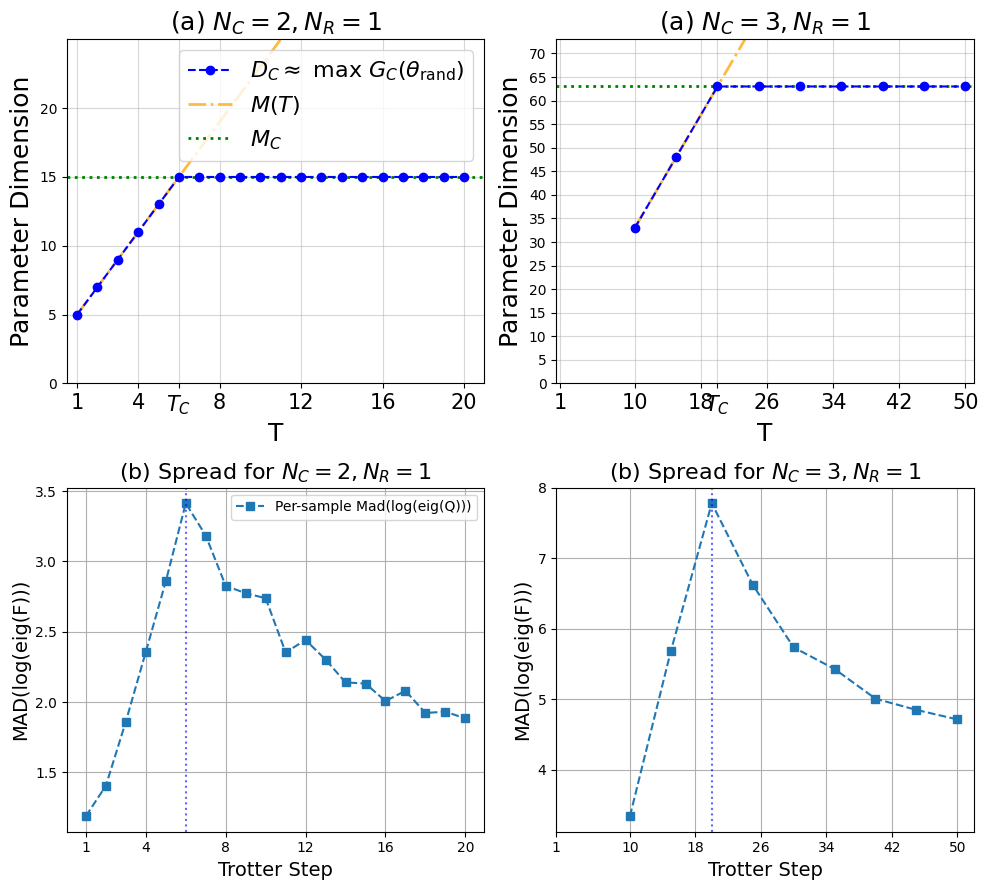

In [78]:
import numpy as np
import matplotlib.pyplot as plt
def plot_spread_analysis_Nc(df, chosen_n_ctrl, chosen_n_reserv, ax=None,
                         spread_type="variance", combination="pooled",
                         show_yerr=False, title=None, xlabel="Trotter Step",
                         ylabel=None, num_ticks=6, scale='normal'):
    """
    Plots the spread analysis based on the given spread type and combination technique,
    *with* an annotated T_C vertical line (T_C^{(N_R)}).
    
    Parameters:
    -----------
    - df: DataFrame containing spread data.
    - chosen_n_ctrl: Selected N_ctrl value.
    - chosen_n_reserv: Selected N_reserv value.
    - ax: Matplotlib axis to plot on (default: creates new figure).
    - spread_type: 'variance' or 'mad'.
    - combination: 'pooled' or 'sampled'.
    - show_yerr: Whether to plot error bars (for sample-based only).
    - title: Title of the plot.
    - xlabel, ylabel: Axis labels.
    - num_ticks: number of x-ticks to generate.
    - scale: 'normal', etc., to match your naming in df columns.
    """

    # Ensure valid inputs
    if spread_type not in ["variance", "mad"]:
        raise ValueError("spread_type must be 'variance' or 'mad'")
    if combination not in ["pooled", "sampled"]:
        raise ValueError("combination must be 'pooled' or 'sampled'")

    # Filter data for the chosen N_ctrl, N_reserv
    df_plot = df.query("N_ctrl==@chosen_n_ctrl & N_reserv==@chosen_n_reserv").copy()
    df_plot.sort_values("Trotter_Step", inplace=True)

    # Extract x values
    x_vals = df_plot["Trotter_Step"].values

    # Column names for y-values
    y_mean_key = f"spread_mean_per_sample_{spread_type}_{scale}"
    y_std_key  = f"spread_std_per_sample_{spread_type}_{scale}"
    y_pool_key = f"spread_val_pooled_{spread_type}_{scale}"

    y_mean, y_std, y_pool = (
        df_plot[y_mean_key].values,
        df_plot[y_std_key].values,
        df_plot[y_pool_key].values
    )

    # Decide which array to use for peak detection & plotting
    if combination == "sampled":
        data_for_peak = y_mean
        data_label = f"Per-sample {spread_type.capitalize()}(log(eig(Q)))"
    else:  # "pooled"
        data_for_peak = y_pool
        data_label = f"Pooled {spread_type.capitalize()}(log(eig(Q)))"

    # Identify peak (T_C)
    peak_idx = int(np.argmax(data_for_peak))
    peak_T   = x_vals[peak_idx]
    peak_val = data_for_peak[peak_idx]
    print(f"[INFO] For N_ctrl={chosen_n_ctrl}, N_reserv={chosen_n_reserv}, "
          f"peak T_C is {peak_T}")

    # Create plot if no axis is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Actually plot
    if combination == "sampled":
        if show_yerr:
            ax.errorbar(
                x_vals, y_mean, yerr=y_std, fmt="o--",
                capsize=4, label=f"{data_label} ± std"
            )
        else:
            ax.plot(
                x_vals, y_mean, "s--", label=data_label
            )
    else:  # combination == "pooled"
        ax.plot(x_vals, y_pool, "s--", label=data_label)


    x_ticks = np.linspace(min(x_vals), max(x_vals), num=num_ticks, dtype=int)
    x_ticks = np.unique(np.append(x_ticks, [1]))  # Ensure T=1 and T_C are always included

    
    ax.set_xticks(x_ticks)
    
    
    # 2) Annotate T_C with a vertical line plus a text label T_C^{(N_reserv)}
    ax.axvline(x=peak_T, color='b', linestyle=':', alpha=0.6)
    ymin, ymax = ax.get_ylim()
    yticks = ax.get_yticks()
    xticks = ax.get_xticks()
    print(f"yticks: {np.median(yticks)}")

    # ax.text(
    #     peak_T+(xticks[1]-xticks[0]), np.median(yticks),
    #     fr"$T_C^{{({chosen_n_reserv})}}={peak_T}$",
    #     fontsize=10, color='b',
    #     ha='center', va='bottom'
    # )
    # ax.annotate(
    #     fr"$T_C^{{({chosen_n_reserv})}}={peak_T}$",
    #     xy=(peak_T, peak_val),
    #     xytext=(peak_T + 0.5, peak_val + 0.2),
    #     arrowprops=dict(arrowstyle="->", color='b'),
    #     fontsize=10, color='b',
    #     ha='left', va='bottom'
    # )


    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel or f"{spread_type.upper()}(log(eig(F)))", fontsize=14)
    if not title:
        title=f'Variance of QFIM eigenvals $N_C = {chosen_n_ctrl}$, $N_R = {chosen_n_reserv}$'
    ax.set_title(title or f"{spread_type.capitalize()}-based Spread Analysis", fontsize=16)
    ax.grid(True)
    ax.legend()

    return ax
def plot_many_ctrl(df, reserv_fixed=1, ctrl_list=[1,2,3], spread_type="mad"):
    """
    Creates a 2x(len(ctrl_list)) grid of subplots.
      - Top row: plot_max_rank_vs_params for each chosen_n_ctrl in ctrl_list,
                 with chosen_n_reserv = reserv_fixed.
      - Bottom row: plot_spread_analysis for each chosen_n_ctrl.
    
    This is analogous to plot_many_reserv, except we now fix N_reserv and vary N_ctrl.

    Parameters:
    -----------
    df : pd.DataFrame
        The dataframe containing your QFIM info (with columns 'N_ctrl','N_reserv','Trotter_Step', etc.).
    reserv_fixed : int
        The reservoir-qubit count to fix for all columns (defaults to 1).
    ctrl_list : list of int
        The distinct N_ctrl values you want to show (e.g. [1, 2, 3]).
    spread_type : str
        'variance' or 'mad', to pass into plot_spread_analysis.

    Returns:
    --------
    fig, axes : The figure and axes objects for further customization.
    """

    ncols = len(ctrl_list)
    fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(5*ncols, 9),
                             sharex=False, sharey=False)
    # If there's only 1 column, ensure axes is 2D
    if ncols == 1:
        axes = np.array([axes]).T  # shape => (2,1)

    for col_idx, ctrl_val in enumerate(ctrl_list):
        # 1) Top row => max rank vs params
        ax_top = axes[0, col_idx]
        plot_max_rank_vs_params(
            df, chosen_n_ctrl=ctrl_val, chosen_n_reserv=reserv_fixed,
            ax=ax_top, xlabel="T", ylabel="Parameter Dimension",
            title=f"(a) $N_C={ctrl_val}, N_R={reserv_fixed}$"
        )
        # Possibly remove legends for columns > 0
        if col_idx > 0 and ax_top.get_legend():
            ax_top.get_legend().remove()

        # 2) Bottom row => spread analysis
        ax_bot = axes[1, col_idx]
        plot_spread_analysis_Nc(
            df, chosen_n_ctrl=ctrl_val, chosen_n_reserv=reserv_fixed,
            ax=ax_bot, spread_type=spread_type, combination="sampled",
            xlabel="Trotter Step", ylabel=f"{spread_type.upper()}(log(eig(F)))",
            title=f"(b) Spread for $N_C={ctrl_val}, N_R={reserv_fixed}$"
        )
        if col_idx > 0 and ax_bot.get_legend():
            ax_bot.legend_.remove()

    plt.tight_layout()
    return fig, axes

# Example usage:

fig, axes = plot_many_ctrl(df_with_stats, reserv_fixed=1, ctrl_list=[2,3], spread_type="mad")
plt.show()


In [85]:
# def plot_spread_overlaid_with_TC_for_ctrl(
#     df,
#     reserv_fixed=1,
#     ctrl_list=[1,2,3],
#     spread_type="mad",
#     combination="sampled",
#     scale="normal",
#     ax=None,
#     title=None,
#     xlabel="Trotter Step",
#     ylabel=None
# ):
#     """
#     Single subplot that overlays multiple lines for distinct N_ctrl values,
#     *all* at a fixed N_reserv. Each line shows the chosen spread metric
#     (variance or mad), either 'sampled' or 'pooled', with T_C detection.

#     We detect each T_C by finding the argmax of the chosen curve for that N_ctrl,
#     then annotate it with a vertical line & label: T_C^{(N_ctrl)} = value.

#     Parameters
#     ----------
#     df : pd.DataFrame
#         DataFrame with columns like 'spread_mean_per_sample_{spread_type}_{scale}',
#         'spread_std_per_sample_{spread_type}_{scale}', 'spread_val_pooled_{spread_type}_{scale}',
#         plus 'N_ctrl','N_reserv','Trotter_Step'.
#     reserv_fixed : int
#         The reservoir qubit number to hold constant.
#     ctrl_list : list of int
#         Which N_ctrl values to overlay.
#     spread_type : str
#         'variance' or 'mad'.
#     combination : str
#         'pooled' or 'sampled'.
#     scale : str
#         Typically 'normal' (to match how your columns are named).
#     ax : matplotlib axis
#         If None, we create a new figure & axis.
#     title : str
#         Title of the plot.
#     xlabel : str
#         X-axis label.
#     ylabel : str
#         Y-axis label (optional).
#     """

#     if combination not in ["pooled", "sampled"]:
#         raise ValueError("combination must be either 'pooled' or 'sampled'")
#     if spread_type not in ["variance", "mad"]:
#         raise ValueError("spread_type must be 'variance' or 'mad'")

#     # Create axis if none provided
#     if ax is None:
#         fig, ax = plt.subplots(figsize=(8,6))
#     else:
#         fig = ax.figure

#     # We'll define a color cycle for the lines
#     color_cycle = plt.cm.get_cmap('Set1', len(ctrl_list))

#     # Column names
#     y_mean_col = f"spread_mean_per_sample_{spread_type}_{scale}"
#     y_std_col  = f"spread_std_per_sample_{spread_type}_{scale}"
#     y_pool_col = f"spread_val_pooled_{spread_type}_{scale}"

#     for i, ctrl_val in enumerate(ctrl_list):
#         # Filter the DataFrame for this (N_ctrl, N_reserv)
#         df_filt = df.query("N_ctrl==@ctrl_val & N_reserv==@reserv_fixed").copy()
#         df_filt.sort_values("Trotter_Step", inplace=True)
#         if df_filt.empty:
#             # If no data for this combination, skip
#             continue

#         x_vals = df_filt["Trotter_Step"].values
#         y_mean = df_filt[y_mean_col].values
#         y_std  = df_filt[y_std_col].values
#         y_pool = df_filt[y_pool_col].values

#         # Decide which y-values to plot
#         if combination == "sampled":
#             y_plot = y_mean
#         else:  # "pooled"
#             y_plot = y_pool

#         # Plot the line
#         color = color_cycle(i)
#         ax.plot(x_vals, y_plot, 'o--', color=color, label=fr"$N_C={ctrl_val}$")

#         # Identify T_C => peak in y_plot
#         peak_idx = int(np.argmax(y_plot))
#         peak_T   = x_vals[peak_idx]
#         peak_val = y_plot[peak_idx]
#         x_ticks = np.linspace(min(x_vals), max(x_vals), num=10, dtype=int)
#         x_ticks = np.unique(np.append(x_ticks, [1]))  # Ensure T=1 and T_C are always included
#         ax.set_xticks(x_ticks)

#         # Annotate T_C with a vertical line + text: T_C^{(ctrl_val)}
#         ax.axvline(x=peak_T, color=color, linestyle=':', alpha=0.6)
#         ax.text(
#             peak_T, peak_val + 0.1,
#             fr"$T_C^{{({ctrl_val})}}={peak_T}$", fontsize=10, color=color,
#             ha='center', va='bottom'
#         )

#     # Axis labeling
#     ax.set_xlabel(xlabel, fontsize=14)
#     ax.set_ylabel(ylabel or f"{spread_type.upper()}(log(eig(F)))", fontsize=14)
#     ax.grid(True)
#     ax.legend(fontsize=12)
#     if not title:
#         title = f"Overlaid Spread Analysis, $N_R={reserv_fixed}$"
#     ax.set_title(title, fontsize=16)

#     return ax
# fig, ax = plt.subplots(figsize=(8,5))
# plot_spread_overlaid_with_TC_for_ctrl(
#     df_with_stats, reserv_fixed=1, ctrl_list=[2,3],
#     spread_type="mad", combination="sampled", scale="normal", ax=ax
# )
# plt.show()
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.colors import to_rgba

# def plot_spread_overlaid_with_TC_for_ctrl(
#     df,
#     reserv_fixed=1,
#     ctrl_list=[2, 3],
#     spread_type="mad",
#     combination="sampled",
#     scale="normal",
#     ax=None,
#     ctrl_colors=None,
#     color_map="tab10",
#     title=None,
#     xlabel="Trotter Step",
#     ylabel=None,
#     legend_loc="lower right",
#     num_xticks=10
# ):
#     """
#     Single subplot that overlays multiple lines for distinct N_ctrl values,
#     all at a fixed N_reserv. Each line shows the chosen spread metric
#     ('variance' or 'mad'), either 'sampled' or 'pooled', with T_C detection.

#     Styling is made to match plot_max_rank_vs_params_overlaid_for_ctrl:
#       - Marker '^', dashed line '--', custom color or fallback to a colormap
#       - Vertical line at T_C from y=0 to y=peak_value
#       - T_C annotation above the peak
#       - Legend in 'lower right' by default
#       - X-ticks and Y-ticks set similarly

#     Parameters
#     ----------
#     df : pd.DataFrame
#         Must contain columns for spread data, e.g.:
#           'spread_mean_per_sample_{spread_type}_{scale}',
#           'spread_std_per_sample_{spread_type}_{scale}',
#           'spread_val_pooled_{spread_type}_{scale}',
#         plus 'N_ctrl','N_reserv','Trotter_Step'.
#     reserv_fixed : int
#         Which N_reserv to fix for all lines.
#     ctrl_list : list of int
#         Which N_ctrl values to overlay.
#     spread_type : {'variance','mad'}
#         Which spread metric to plot.
#     combination : {'pooled','sampled'}
#         Whether to plot 'pooled' or 'sampled' data.
#     scale : str
#         Usually 'normal', matching the suffix in your DataFrame columns.
#     ax : matplotlib.axes.Axes or None
#         If None, a new figure/axes is created.
#     ctrl_colors : dict or None
#         Optional mapping {N_ctrl_value: color_str}.
#         If None or missing a key, we use a fallback from 'color_map'.
#     color_map : str
#         Name of the colormap to use if ctrl_colors is missing an entry.
#     title : str
#         Plot title. If None, a default is generated.
#     xlabel : str
#         Label for the x-axis.
#     ylabel : str
#         Label for the y-axis. If None, defaults to "MAD(log(eig(F)))" or "VARIANCE(...)"
#     legend_loc : str
#         Location of the legend.
#     num_xticks : int
#         Number of x ticks to generate via linspace.

#     Returns
#     -------
#     ax : matplotlib.axes.Axes
#     """

#     # Validate inputs
#     if combination not in ["pooled", "sampled"]:
#         raise ValueError("combination must be 'pooled' or 'sampled'")
#     if spread_type not in ["variance", "mad"]:
#         raise ValueError("spread_type must be 'variance' or 'mad'")

#     # Create axis if none provided
#     if ax is None:
#         fig, ax = plt.subplots(figsize=(8, 6))
#     else:
#         fig = ax.figure

#     # If no custom color dict, create an empty one
#     if ctrl_colors is None:
#         ctrl_colors = {}

#     # Prepare a colormap fallback
#     cmap = plt.cm.get_cmap(color_map, len(ctrl_list))

#     # Column names
#     y_mean_col = f"spread_mean_per_sample_{spread_type}_{scale}"
#     y_std_col  = f"spread_std_per_sample_{spread_type}_{scale}"
#     y_pool_col = f"spread_val_pooled_{spread_type}_{scale}"

#     # We'll track a global max Y for setting the y-limit
#     global_max_y = 0.0

#     for i, ctrl_val in enumerate(ctrl_list):
#         # Filter data for (N_ctrl, N_reserv)
#         df_filt = df.query("N_ctrl == @ctrl_val & N_reserv == @reserv_fixed").copy()
#         df_filt.sort_values("Trotter_Step", inplace=True)
#         if df_filt.empty:
#             continue

#         x_vals = df_filt["Trotter_Step"].values
#         y_mean = df_filt[y_mean_col].values
#         y_pool = df_filt[y_pool_col].values

#         # Choose which array to plot
#         if combination == "sampled":
#             y_plot = y_mean
#         else:  # "pooled"
#             y_plot = y_pool

#         # Determine color for this N_ctrl
#         c = ctrl_colors.get(ctrl_val, cmap(i))

#         # Plot with marker '^' and dashed line, matching style
#         ax.plot(
#             x_vals,
#             y_plot,
#             marker='^',
#             linestyle='--',
#             linewidth=0.5,
#             color=c,
#             label=fr"$N_C={ctrl_val}$",
#             zorder=10
#         )

#         # Identify T_C => peak in y_plot
#         peak_idx = int(np.argmax(y_plot))
#         peak_T   = x_vals[peak_idx]
#         peak_val = y_plot[peak_idx]

#         # Draw a vertical line from y=0 to y=peak_val
#         ax.vlines(peak_T, 0, peak_val, color=c, linestyle=':', alpha=0.6)

#         # Annotate T_C near the peak
#         # (Adjust offset as needed for your data scale)
#         ax.text(
#             peak_T,
#             peak_val + 0.1,
#             fr"$T_C^{{({ctrl_val})}}={peak_T}$",
#             fontsize=10,
#             color=c,
#             ha='center',
#             va='bottom'
#         )

#         # Update global max
#         local_max = np.max(y_plot)
#         if local_max > global_max_y:
#             global_max_y = local_max

#     # Set x-ticks similarly to your other function
#     if len(df) > 0:
#         all_t = df.query("N_reserv == @reserv_fixed")["Trotter_Step"].unique()
#         t_min, t_max = all_t.min(), all_t.max()
#     else:
#         t_min, t_max = 1, 1

#     x_ticks = np.linspace(t_min, t_max, num=num_xticks, dtype=int)
#     x_ticks = np.unique(np.append(x_ticks, [1]))  # ensure T=1 included
#     ax.set_xticks(x_ticks)
#     ax.set_xticklabels([str(t) for t in x_ticks], fontsize=12)

#     # Set Y-axis from 0 up to a bit above global_max_y
#     y_margin = 0.5  # small extra space above the max
#     top_lim = global_max_y + y_margin
#     ax.set_ylim(bottom=0, top=top_lim)

#     # You can set integer ticks or a custom spacing if desired
#     # For example, if spread values are typically small, you might do step=1
#     # We'll pick a step that depends on top_lim
#     if top_lim <= 11:
#         step = 1
#     else:
#         step = 2
#     y_ticks = np.arange(0, top_lim + step+1, step)
#     ax.set_yticks(y_ticks[y_ticks <= top_lim])
#     ax.set_yticklabels([str(int(y)) for y in y_ticks if y <= top_lim], fontsize=12)

#     # Axis labeling
#     ax.set_xlabel(xlabel, fontsize=14)
#     ax.set_ylabel(ylabel or f"{spread_type.upper()}(log(eig(F)))", fontsize=14)

#     # Title & legend
#     if not title:
#         title = f"Overlaid Spread Analysis, $N_R={reserv_fixed}$"
#     ax.set_title(title, fontsize=16)

#     ax.legend(loc=legend_loc, fontsize=12)
#     ax.grid(True, alpha=0.5)

#     return ax


# fig, ax = plt.subplots(figsize=(8,5))

# # Suppose we want N_C=2 to be 'blue', N_C=3 to be 'purple':
# ctrl_colors = {
#     2: 'blue',
#     3: 'purple'
# }

# plot_spread_overlaid_with_TC_for_ctrl(
#     df_with_stats,
#     reserv_fixed=1,
#     ctrl_list=[2, 3],
#     spread_type="mad",
#     combination="sampled",
#     scale="normal",
#     ax=ax,
#     ctrl_colors=ctrl_colors,
#     color_map="tab10",
#     legend_loc="lower right",
#     title="Overlaid Spread Analysis, $N_R=1$"
# )
# plt.show()


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_42192/305760661.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap(color_map, len(ctrl_list))


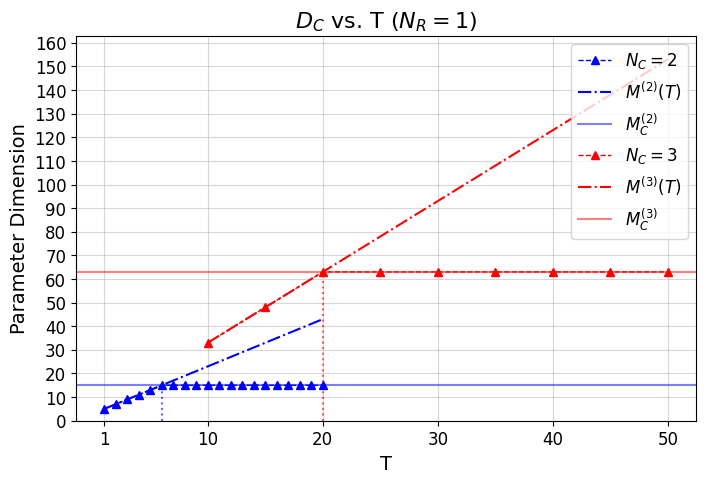

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

def plot_max_rank_vs_params_overlaid_for_ctrl(
    df,
    reserv_fixed=1,
    ctrl_list=[2, 3],
    rank_colors=None,
    xlabel='T',
    ylabel='Parameter Dimension',
    title=None,
    ax=None,
    color_map='tab10',
    legend_loc='upper right',
    num_ticks=6
):
    """
    Single subplot overlaying the 'max rank vs. T' logic for multiple N_ctrl values,
    while N_reserv is fixed (defaults to 1).

    Each N_ctrl gets:
      - A rank-vs-T line (color c, with marker '^')
      - M(T) = (N_reserv*N_ctrl*T + 3) line in the same color (dash-dot),
        labeled "M^{(ctrl_val)}(T)"
      - A horizontal line at M_C (param dimension at T_C) in a lighter alpha
        version of the same color, labeled "M_C^{(ctrl_val)}"
      - A vertical line at T_C (dotted) from y=0 to y=M_C

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns 'N_ctrl','N_reserv','Trotter_Step','QFIM_ranks'.
    reserv_fixed : int
        N_reserv value to hold constant across all overlaid lines.
    ctrl_list : list of int
        Distinct N_ctrl values we want to overlay in one plot.
    rank_colors : dict or None
        Optional mapping {N_ctrl_value: color_str}.
        If None or missing a key, we use a default color cycle.
    xlabel, ylabel : str
        Axis labels.
    title : str
        Plot title. If None, we autogenerate one.
    ax : matplotlib.axes.Axes or None
        If None, a new figure/axes is created.
    color_map : str
        The colormap name (used only if rank_colors does not provide a color).
    legend_loc : str
        Where to place the legend.
    num_ticks : int
        Number of x ticks to generate.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """

    if df.empty:
        raise ValueError("DataFrame is empty. Please provide valid data.")

    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))
    else:
        fig = ax.figure

    # If no custom colors provided, we'll fall back to colormap
    if rank_colors is None:
        rank_colors = {}

    cm = plt.cm.get_cmap(color_map, len(ctrl_list))

    all_t = set()
    global_max_dim = 0.0

    for i, ctrl_val in enumerate(ctrl_list):
        subset = df.query("N_ctrl == @ctrl_val and N_reserv == @reserv_fixed").copy()
        if subset.empty:
            continue

        # Gather max rank per T
        trotter_steps = []
        max_ranks = []
        for T_step, grp in subset.groupby('Trotter_Step'):
            all_ranks = [r for row in grp['QFIM_ranks'] for r in row]
            rmax = np.max(all_ranks) if all_ranks else 0
            trotter_steps.append(T_step)
            max_ranks.append(rmax)

        # Sort by T
        trotter_steps, max_ranks = zip(*sorted(zip(trotter_steps, max_ranks)))

        # M(T) = N_reserv*N_ctrl*T + 3
        param_list = [reserv_fixed * ctrl_val * t + 3 for t in trotter_steps]

        # Identify T_C => argmax of max_ranks
        idx_C = int(np.argmax(max_ranks))
        T_C   = trotter_steps[idx_C]
        M_C   = param_list[idx_C]

        # Determine color for this N_ctrl
        if ctrl_val in rank_colors:
            c = rank_colors[ctrl_val]
        else:
            # fallback: use color from colormap
            c = cm(i)

        # 1) Plot max-rank line
        ax.plot(
            trotter_steps,
            max_ranks,
            marker='^', linestyle='--',
            linewidth=1,
            color=c,
            label=fr"$N_C={ctrl_val}$",
            zorder=10
        )

        # 2) Plot M(T) in the same color (dash-dot)
        ax.plot(
            trotter_steps,
            param_list,
            color=c,
            linestyle='-.',
            linewidth=1.5,
            label=fr"$M^{{({ctrl_val})}}(T)$"
        )

        # 3) Horizontal line at M_C, slightly lighter
        c_h = to_rgba(c)
        # reduce alpha for the horizontal line
        c_h = (c_h[0], c_h[1], c_h[2], 0.5)
        ax.axhline(
            y=M_C,
            color=c_h,
            linestyle='-',
            linewidth=1.5,
            label=fr"$M_C^{{({ctrl_val})}}$"
        )

        # 4) Vertical line at T_C from y=0 to y=M_C
        ax.vlines(
            T_C,
            0, M_C,
            color=c,
            linestyle=':',
            alpha=0.6
        )

        # Update sets and dimension tracking
        for t in trotter_steps:
            all_t.add(t)

        local_max_dim = max(np.max(max_ranks), np.max(param_list))
        if local_max_dim > global_max_dim:
            global_max_dim = local_max_dim

    # X-ticks
    if not all_t:
        all_t = {1}
    t_min, t_max = min(all_t), max(all_t)
    x_ticks = np.linspace(t_min, t_max, num=num_ticks, dtype=int)
    x_ticks = np.unique(np.append(x_ticks, [1]))  # ensure T=1 included
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(t) for t in x_ticks], fontsize=12)

    # Y-ticks in increments of 10, from 0 to a bit above global max
    ytop = int(global_max_dim + 10)
    steps = np.arange(0, ytop + 1, 10)
    ax.set_yticks(steps)
    ax.set_ylim(bottom=0, top=ytop)
    ax.set_yticklabels([str(int(y)) for y in steps], fontsize=12)

    # Axis labels
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

    if not title:
        title = fr"Overlaid Max Rank vs. T for $N_R={reserv_fixed}$"
    ax.set_title(title, fontsize=16)

    ax.legend(loc=legend_loc, fontsize=12)
    ax.grid(True, alpha=0.5)

    return ax


fig, ax = plt.subplots(figsize=(8, 5))
rank_colors = {
    2: 'blue',
    3: 'red',
    4: 'green'
}

plot_max_rank_vs_params_overlaid_for_ctrl(
    df_with_stats,
    reserv_fixed=1,
    ctrl_list=[2, 3, 4],
    rank_colors=rank_colors,
    ax=ax,
    xlabel='T',
    ylabel='Parameter Dimension',
    title='$D_C$ vs. T ($N_R=1$)',
)

plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_many_reserv_shared_y(df, N_ctrl=2, reserv_list=[1, 2, 3], spread_type="mad"):
    """
    Creates a 2xN grid of subplots, with the top row showing plot_max_rank_vs_params
    and the bottom row showing plot_spread_analysis. Each column is a different N_R.
    
    This version uses a single shared y-axis label for the top row 
    and a single shared y-axis label for the bottom row.
    """

    ncols = len(reserv_list)
    fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(5*ncols, 9),
                             sharex=False, sharey='row')
    # 'sharey=row' means each row shares a y-axis among its columns.

    # If there's only 1 column, axes might not be 2D, so ensure we treat it properly
    if ncols == 1:
        axes = np.array([axes]).T  # shape => (2,1)

    # 1) Top row label: set on the leftmost subplot
    axes[0,0].set_ylabel("Parameter Dimension", fontsize=12)

    # 2) Bottom row label: similarly on the leftmost subplot
    axes[1,0].set_ylabel("Spread of log(eig(F))", fontsize=12)

    for col_idx, nr_val in enumerate(reserv_list):
        # ------------------------------------------------
        # Top row: param dimension vs. T
        # ------------------------------------------------
        ax_top = axes[0, col_idx]
        plot_max_rank_vs_params(
            df, chosen_n_ctrl=N_ctrl, chosen_n_reserv=nr_val, ax=ax_top,
            xlabel="Trotter Step" if col_idx == 0 else "", # maybe keep or remove 
            ylabel=None,  # We'll rely on the shared row label
            title=f"N_R={nr_val}: Param Dimension"
        )
        # Optionally remove repeated legends from columns > 0
        if col_idx > 0 and ax_top.get_legend():
            ax_top.get_legend().remove()

        # ------------------------------------------------
        # Bottom row: spread analysis
        # ------------------------------------------------
        ax_bot = axes[1, col_idx]
        plot_spread_analysis(
            df, chosen_n_ctrl=N_ctrl, chosen_n_reserv=nr_val,
            ax=ax_bot, spread_type=spread_type, combination="sampled",
            xlabel="Trotter Step", ylabel=None,
            title=f"N_R={nr_val}: Spread {spread_type}"
        )

        if col_idx > 0 and ax_bot.get_legend():
            ax_bot.get_legend().remove()

    plt.tight_layout()
    return fig, axes

# Example usage:
fig, axes = plot_many_reserv_shared_y(df_with_stats, N_ctrl=2, reserv_list=[1,2,3], spread_type="mad")
# plt.show()

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_65183/2019598949.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_cycle = plt.cm.get_cmap('tab10', len(reserv_list))


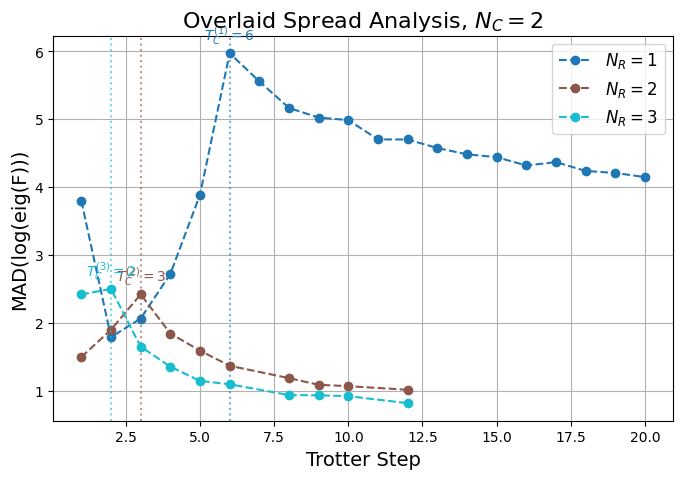

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_spread_overlaid_with_TC(
    df,
    N_ctrl=2,
    reserv_list=[1,2,3],
    spread_type="mad",
    combination="sampled",
    scale="normal",
    ax=None,
    title=None,
    xlabel="Trotter Step",
    ylabel=None
):
    """
    Single subplot that overlays multiple lines for each N_reserv,
    showing the spread_of_log metric from your DataFrame.
    
    We also detect each T_C by finding the argmax of the chosen curve 
    and annotate it with a vertical line & label: T_C^{(N_R=2)}.
    
    Parameters:
      - df: your main DataFrame with columns like spread_mean_per_sample_{spread_type}_{scale}
      - N_ctrl: the control qubit number
      - reserv_list: which reservoir values to overplot
      - spread_type: 'variance' or 'mad'
      - combination: 'pooled' or 'sampled'
      - scale: typically 'normal'
      - ax: optional matplotlib axis
      - title: figure title
      - xlabel, ylabel: axis labels
    """

    if combination not in ["pooled", "sampled"]:
        raise ValueError("combination must be either 'pooled' or 'sampled'")
    if spread_type not in ["variance", "mad"]:
        raise ValueError("spread_type must be 'variance' or 'mad'")

    # Create axis if none provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))
    else:
        fig = ax.figure

    # We'll define a color cycle for the lines
    color_cycle = plt.cm.get_cmap('tab10', len(reserv_list))

    # Column names
    y_mean_col = f"spread_mean_per_sample_{spread_type}_{scale}"
    y_std_col  = f"spread_std_per_sample_{spread_type}_{scale}"
    y_pool_col = f"spread_val_pooled_{spread_type}_{scale}"

    for i, nr_val in enumerate(reserv_list):
        df_filt = df.query("N_ctrl==@N_ctrl & N_reserv==@nr_val").copy()
        df_filt.sort_values("Trotter_Step", inplace=True)
        x_vals = df_filt["Trotter_Step"].values

        y_mean = df_filt[y_mean_col].values
        y_std  = df_filt[y_std_col].values
        y_pool = df_filt[y_pool_col].values

        # Decide which y-values to plot
        if combination == "sampled":
            y_plot = y_mean
        else:
            y_plot = y_pool

        # Plot the line
        color = color_cycle(i)
        ax.plot(x_vals, y_plot, 'o--', color=color, label=fr"$N_R={nr_val}$")

        # 1) Identify T_C => peak in y_plot
        peak_idx = int(np.argmax(y_plot))
        peak_T   = x_vals[peak_idx]
        peak_val = y_plot[peak_idx]

        # 2) Annotate T_C with a vertical line or text
        # We'll do a vertical line plus a small text
        # e.g. T_C^{(2)} near the top
        ax.axvline(x=peak_T, color=color, linestyle=':', alpha=0.6)
        ax.text(
            peak_T, peak_val + 0.1,   # position slightly above the peak
            fr"$T_C^{{({nr_val})}}={peak_T}$", fontsize=10, color=color,
            ha='center', va='bottom'
        )

    # Axis labeling
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel or f"{spread_type.upper()}(log(eig(F)))", fontsize=14)
    ax.grid(True)
    ax.legend(fontsize=12)
    if not title:
        title = f"Overlaid Spread Analysis, $N_C={N_ctrl}$"
    ax.set_title(title, fontsize=16)
    return ax

# Example usage:

fig, ax = plt.subplots(figsize=(8,5))
plot_spread_overlaid_with_TC(
    df_with_stats, N_ctrl=2, reserv_list=[1,2,3], spread_type="mad",
    combination="sampled", scale="normal", ax=ax
)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import PowerNorm

N_ctrl = chosen_n_ctrl
def plot_qfim_metrics_heatmaps(df_all, N_ctrl, metric_keys, metrics_info, resies=None):
    """
    Generates heatmaps for multiple metrics specified in 'metric_keys' 
    using the definitions/titles in 'metrics_info'.

    - df_all: your main DataFrame.
    - N_ctrl: the control-qubit dimension you're focusing on (int).
    - metric_keys: list of column names in df_all that you want to plot.
    - metrics_info: dict with metadata for each metric_key, e.g.:
        metrics_info = {
            'mean_trace_eigvals': {
                'title': 'Mean Trace of QFIM',
                'cbar': ''
            },
            ...
        }
    - resies: list of reservoir-qubit counts you want on the x-axis 
      (defaults to [1,2,3,4] or whatever you specify).
    """

    # 1) Default reservoir list if none provided
    if resies is None:
        resies = [1, 2, 3]

    # 2) Decide how to pick Trotter steps based on N_ctrl
    if N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6]
    elif N_ctrl == 3:
        trots = np.arange(1, 60, 1)  # or your preferred range
    else:
        trots = [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 16, 18, 20]

    # 3) Single filter step for this N_ctrl, reservoir set, and Trotter steps
    df_filtered = df_all.query("N_ctrl == @N_ctrl").copy()
    df_filtered = df_filtered[df_filtered["N_reserv"].isin(resies)]
    df_filtered = df_filtered[df_filtered["Trotter_Step"].isin(trots)]

    # 4) Loop over each metric you want to plot
    for metric_key in metric_keys:
        if metric_key not in df_filtered.columns:
            print(f"Warning: '{metric_key}' not in df_filtered columns.")
            continue

        # Retrieve title & color bar label from your dictionary
        metric_title = metric_key
        metric_cbar=''
        # metric_title = metrics_info.get(metric_key, {}).get('title', metric_key)
        # metric_cbar  = metrics_info.get(metric_key, {}).get('cbar', '')

        # 4a) Pivot the data for a heatmap
        df_heatmap = (
            df_filtered[["N_reserv", "Trotter_Step", metric_key]]
            .groupby(["Trotter_Step", "N_reserv"])[metric_key]
            .mean()  # or .median(), .max() etc. if desired
            .reset_index()
        )
        heatmap_pivot = df_heatmap.pivot(index="Trotter_Step", columns="N_reserv", values=metric_key)

        # 4b) Compute min/max for color normalization
        min_val = heatmap_pivot.min().min()
        max_val = heatmap_pivot.max().max()

        # 4c) Create formatted annotations
        # D_C: integer ranks, so show 0 decimal places
        if metric_key == "D_C":
            annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.0f}")
        else:
            annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.2f}")

        # 5) Plotting
        fig, ax = plt.subplots(figsize=(8, 6))

        # Create a divider to place colorbar alongside the heatmap
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.1)

        # Example: use a power-law normalization
        sns.heatmap(
            heatmap_pivot,
            annot=annotation_matrix, fmt="",  # fmt="" so we use our own annotated strings
            ax=ax, cbar_ax=cax, cmap="magma",
            annot_kws={"weight": "bold", "size": 20},
            norm=PowerNorm(gamma=0.7, vmin=min_val, vmax=max_val)
        )

        # Invert y-axis so T=1 is at the top
        ax.invert_yaxis()

        # Configure colorbar
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label(metric_cbar, rotation=0, labelpad=30, fontsize=20)

        # Title & labels
        ax.set_title(metric_title, fontsize=20, pad=20)
        ax.set_ylabel('$T$', labelpad=20, fontsize=30, rotation=0)
        ax.set_xlabel("", fontsize=20)
        ax.tick_params(axis='y', labelrotation=0, labelsize=16)
        ax.tick_params(axis='x', labelsize=16)

        # Format x-tick labels
        xticklabels = [f'$N_R = {int(col)}$' for col in heatmap_pivot.columns]
        ax.set_xticklabels(xticklabels, fontweight="bold", fontsize=25, rotation=0)

        plt.tight_layout()
        plt.show()

metric_keys = ['D_C',"effective_dimension","effective_dimensio2","spread_val_pooled_mad_normal",'d_eff_ipr']
# metric_keys = ['spread_val_pooled_mad_normal','spread_val_pooled_mad']
# metric_keys = ['D_C','d_eff_ipr']

plot_qfim_metrics_heatmaps(df_with_stats, N_ctrl=chosen_n_ctrl, metric_keys=metric_keys, metrics_info={}, resies=[1,2,3,4])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import PowerNorm
chosen_n_ctrl=2
N_ctrls = [2,3]
N_ctrl = chosen_n_ctrl
metrics_info ={
    'avg_test_tr_qfim_eigvals_norm_by_rank': {
        'title': f'Sum($\lambda_Q$)/ $G_C$ [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_ipr_dim': {
        'title': f'Mean IPR Dimension [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_var_qfim_eigvals_normalized': {
        'title': f'Mean Var($\lambda_Q$) Normalized [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_var_qfim_eigvals_nonzero_normalized_by_rank': {
        'title': f'Var($\lambda_Q$) Normalized by Quantum Dimension [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_tr_qfim_eigvals_norm': {
        'title': f'Normalized Trace of QFIM over tests [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'D_C': {
        'title': f'Parameter Dimension $D_C$ [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    # Entropy
    'mean_entropy': {
        'title': f'Mean Von Neumann Entropy [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'entropy': {
        'title': f'Von Neumann Entropy Distribution [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Condition Numbers
    'mean(cond_nums)': {
        'title': f'Mean Condition Number of QFIM [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'cond_nums': {
        'title': f'Condition Numbers of QFIM [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
}
metrics_info = {
    # Trace Metrics
    'mean_trace_eigvals': {
        'title': f'Mean Trace of QFIM [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_ipr_dim': {
        'title': f'Mean IPR Dimension [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_tr_qfim_eigvals': {
        'title': f'Trace of QFIM over tests [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_tr_qfim_eigvals_norm': {
        'title': f'Normalized Trace of QFIM over tests [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_tr_qfim_eigvals_norm_by_rank': {
        'title': f'Normalized (R) Trace of QFIM over tests [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'median_trace_eigvals': {
        'title': f'Median Trace of QFIM [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'iqr_trace_eigvals': {
        'title': f'IQR of Trace(QFIM) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'weighted_avg_trace_eigvals': {
        'title': f'Weighted Average of Trace(QFIM) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Variance of Eigenvalues
    'mean_var_eigval': {
        'title': f'Mean Variance of QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
     'avg_test_var_qfim_eigvals_nonzero': {
        'title': f'Mean Variance of QFIM Eigenvalues (nonzero) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_var_qfim_eigvals_normalized': {
        'title': f'Mean Variance of QFIM Eigenvalues (normalized) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_var_qfim_eigvals_nonzero_normalized_by_rank': {
        'title': f'Mean Variance of QFIM Eigenvalues (normalized by rank) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_var_qfim_eigvals_normalized_by_rank': {
        'title': f'Mean Variance of QFIM Eigenvalues (normalized by R) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'var_test_var_qfim_eigvals_nonzero': {
        'title': f'log Var(Variance of QFIM) over tsts (nonzero) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_var_qfim_eigvals': {
        'title': f'Avg(Variance of QFIM) over tsts [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'median_var_eigval': {
        'title': f'Median Variance of QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'iqr_var_eigval': {
        'title': f'IQR of Variance(QFIM Eigenvalues) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'weighted_avg_var_eigval': {
        'title': f'Weighted Average Variance of QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'normalized_var_qfim_eigvals': {
        'title': f'Normalized Variance of QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'var_test_var_qfim_eigvals': {
        'title': f'Var(Variance of QFIM) over tsts  [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'var_test_var_qfim_eigvals_log': {
        'title': f'log(Var(Variance of QFIM)) over tsts  [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    # Variance of Log-Scaled Eigenvalues
    'mean_var_log_eigval': {
        'title': f'Mean Variance of log(QFIM Eigenvalues) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'median_var_log_eigval': {
        'title': f'Median Variance of log(QFIM Eigenvalues) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'iqr_var_log_eigval': {
        'title': f'IQR of Variance(log(QFIM Eigenvalues)) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'weighted_avg_var_log_eigval': {
        'title': f'Weighted Average Variance of log(QFIM Eigenvalues) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Entropy
    'mean_entropy': {
        'title': f'Mean Von Neumann Entropy [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'entropy': {
        'title': f'Von Neumann Entropy Distribution [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Condition Numbers
    'mean(cond_nums)': {
        'title': f'Mean Condition Number of QFIM [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'cond_nums': {
        'title': f'Condition Numbers of QFIM [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Eigenvalue Metrics
    'max_eigvals': {
        'title': f'Maximum QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'min_eigvals': {
        'title': f'Minimum QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Ratios and Redundancies
    'ratios': {
        'title': f'Ratio of Non-Zero Eigenvalues to Parameters [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'redundancies': {
        'title': f'Redundancy ($G_C$)[$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'global_redundancies': {
        'title': f'Global Redundancy ($R$) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Quantum Dimension
    'quantum_dim': {
        'title': f'Quantum Dimension $G_C$ (Rank) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'D_C': {
        'title': f'Parameter Dimension $D_C$ [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'effective params': {
        'title': f'Effective Parameters [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    # Normalized Trace
    'mean_norm_trace_eigvals': {
        'title': f'Mean Normalized Trace of QFIM [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Power-Scaled Metrics
    'var_power_scaled_avg_qfim_eigvals': {
        'title': f'Power-Scaled Variance of QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'var_power_scaled_avg_qfim_eigvals_nonzero': {
        'title': f'Power-Scaled Variance of Non-Zero QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Variance of Log Scaled Metrics
    'var_log_qfim_eigvals_nonzero': {
        'title': f'Variance of log(QFIM Eigenvalues) Non-Zero [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Trace Values Direct
    'trace_eigvals': {
        'title': f'Trace of QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    }
}
def plot_qfim_metrics_heatmaps(df_all, N_ctrl, metric_keys, metrics_info, resies=None):
    """
    Generates heatmaps for multiple metrics specified in 'metric_keys' 
    using the definitions/titles in 'metrics_info'.

    - df_all: your main DataFrame.
    - N_ctrl: the control-qubit dimension you're focusing on (int).
    - metric_keys: list of column names in df_all that you want to plot.
    - metrics_info: dict with metadata for each metric_key, e.g.:
        metrics_info = {
            'mean_trace_eigvals': {
                'title': 'Mean Trace of QFIM',
                'cbar': ''
            },
            ...
        }
    - resies: list of reservoir-qubit counts you want on the x-axis 
      (defaults to [1,2,3,4] or whatever you specify).
    """

    # 1) Default reservoir list if none provided
    if resies is None:
        resies = [1, 2, 3, 4]

    # 2) Decide how to pick Trotter steps based on N_ctrl
    if N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6]
    elif N_ctrl == 3:
        trots = np.arange(1, 60, 1)  # or your preferred range
    else:
        trots = [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 16, 18, 20]

    # 3) Single filter step for this N_ctrl, reservoir set, and Trotter steps
    df_filtered = df_all.query("N_ctrl == @N_ctrl").copy()
    df_filtered = df_filtered[df_filtered["N_reserv"].isin(resies)]
    df_filtered = df_filtered[df_filtered["Trotter_Step"].isin(trots)]

    # 4) Loop over each metric you want to plot
    for metric_key in metric_keys:
        if metric_key not in df_filtered.columns:
            print(f"Warning: '{metric_key}' not in df_filtered columns.")
            continue

        # Retrieve title & color bar label from your dictionary
        metric_title = metric_key
        metric_cbar=''
        # metric_title = metrics_info.get(metric_key, {}).get('title', metric_key)
        # metric_cbar  = metrics_info.get(metric_key, {}).get('cbar', '')

        # 4a) Pivot the data for a heatmap
        df_heatmap = (
            df_filtered[["N_reserv", "Trotter_Step", metric_key]]
            .groupby(["Trotter_Step", "N_reserv"])[metric_key]
            .mean()  # or .median(), .max() etc. if desired
            .reset_index()
        )
        heatmap_pivot = df_heatmap.pivot(index="Trotter_Step", columns="N_reserv", values=metric_key)

        # 4b) Compute min/max for color normalization
        min_val = heatmap_pivot.min().min()
        max_val = heatmap_pivot.max().max()

        # 4c) Create formatted annotations
        # D_C: integer ranks, so show 0 decimal places
        if metric_key == "D_C":
            annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.0f}")
        else:
            annotation_matrix = heatmap_pivot.applymap(lambda x: f"{x:.2f}")

        # 5) Plotting
        fig, ax = plt.subplots(figsize=(9, 8))

        # Create a divider to place colorbar alongside the heatmap
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.1)

        # Example: use a power-law normalization
        sns.heatmap(
            heatmap_pivot,
            annot=annotation_matrix, fmt="",  # fmt="" so we use our own annotated strings
            ax=ax, cbar_ax=cax, cmap="magma",
            annot_kws={"weight": "bold", "size": 20},
            norm=PowerNorm(gamma=1.2, vmin=min_val, vmax=max_val)
        )

        # Invert y-axis so T=1 is at the top
        ax.invert_yaxis()

        # Configure colorbar
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label(metric_cbar, rotation=0, labelpad=30, fontsize=20)

        # Title & labels
        ax.set_title(metric_title, fontsize=20, pad=20)
        ax.set_ylabel('$T$', labelpad=20, fontsize=30, rotation=0)
        ax.set_xlabel("", fontsize=20)
        ax.tick_params(axis='y', labelrotation=0, labelsize=18)
        ax.tick_params(axis='x', labelsize=18)

        # Format x-tick labels
        xticklabels = [f'$N_R = {int(col)}$' for col in heatmap_pivot.columns]
        ax.set_xticklabels(xticklabels, fontweight="bold", fontsize=30, rotation=0)

        plt.tight_layout()
        plt.show()


# -----------------------
# Example usage in a notebook:
# -----------------------
# metrics_info = {... your big dictionary as in your question ...}
# metric_keys = list(metrics_info.keys())
metric_keys = ['avg_test_var_qfim_eigvals_normalized', 'avg_test_var_qfim_eigvals_nonzero_normalized_by_rank','avg_test_var_qfim_eigvals_nonzero']
metric_keys = ['avg_test_var_qfim_eigvals_normalized','avg_test_var_qfim_eigvals_normalized_by_rank','avg_test_var_qfim_eigvals','avg_test_var_qfim_eigvals_nonzero']
plot_qfim_metrics_heatmaps(df_all, N_ctrl=chosen_n_ctrl, metric_keys=metric_keys, metrics_info=metrics_info, resies=[1,2,3,4])